<a href="https://colab.research.google.com/github/johnzelson/np-colab-notebooks/blob/main/S1_IRS_BMF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1:IRS BMF, Overview
---
This notebook processes a [Business Master File extract (BMF)](https://www.irs.gov/charities-non-profits/exempt-organizations-business-master-file-extract-eo-bmf) from [IRS](www.irs.gov) of all the active Nonprofits in NY and creates a dataframe of nonprofits in a local area with various code lookups added.

The IRS creates these extracts from Form 1023 - the form that organizations file to become recognized as a federally recognized nonprofit - along with some key info from the latest annual tax submmission (Form 990-series).

This processing is the first step in a series of six notebooks and streamlit app to analyze nonprofits in local area.  I was interested in Cortland, but the steps should be repeatable for other areas.



# Tech Notes

This first step (S1 IRS BMF) in a series of processing notebooks, loads BMF into a Pandas dataframe, adds human-readable definitions/lookups from spreadsheets of definitions, saves tidy dataframe of just local area nonprofits, and then does some plotting.

All data is on google drive, with file locations assumed in code.  There is some configurability, but a future enhancement is to set that up a config file.


S1 IRS BMF uses these files:

| In Files          | Description         |
| ---------------- | -------------------- |
| eo_ny.csv        |   IRS BMF File       |
| NTEE_Code.csv    |   Definitions of NTEE Codes    |
| IRS_Lookups.csv    |  Definitions of Various IRS Codes   |
| IRS_Activity_Codes.csv | Definitions of IRS Activity Codes  |

And creates these dataframes (to csv) files:

|     Out Files          |     Description       |
| ---------------------  | --------------------- |
| np_ny_p_df.csv         | Dataframe of processed BMF      |
|np_cortland_p_df.csv    | Orgs with Cortland address|
|np_cort_10mile_p_df.csv | Org Zip within 10mi of Cortland |
|np_cort_co_df.to_csv    | Org Zip in county        |
| bmf_cities_df_precensus.csv          | Cities in NY without demographics        |


The out files are used in successive notebooks to build dataset for streamlit/web app.




# Setup


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
from google.colab import userdata


In [ ]:
#TODO: create a configuration section -- not implemented

# base folder for retrieving raw data
data_dir = '/content/drive/My Drive/irs_data/'

# folder for writing processed data
proc_dir = '/content/drive/My Drive/IRS_processed/'

# folder for code lookups
lu_dir = '/content/drive/My Drive/irs_data/IRS_Code_Lookups/'



In [ ]:
from google.colab import drive
drive.flush_and_unmount()

In [ ]:
import pandas as pd
pd.set_option('display.max_columns', 100);
pd.set_option('display.max_rows', 50);

# note:  in colab, max rows has to be greater than the rows returned
# or display will revert to head and tail defaults


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pprint
import csv
import math
import requests



#1 Load BMF NY Orgs

IRS offers [BMF by state and region](https://www.irs.gov/charities-non-profits/exempt-organizations-business-master-file-extract-eo-bmf).  Since I just needed one file, EO_NY.csv, and downloaded manually.  (July 2024)

In [ ]:
# --- Load IRS Master File of Active NPs in NY ---
# Gets all "active" NPs with latest Tax Return, Form 990-series summary.

# Specify the data type for each column
dtype = {"CLASSIFICATION": str,
         "EIN" : str,
         "ACTIVITY" : str,
         "AFFILIATION" : str,
         "ORGANIZATION" : str,
         "FOUNDATION" : str,
         "NTEE_CD" : str,
         "RULING" : str,
         "ZIP" : str,
         "TAX_PERIOD" : str,
         "GROUP" : str,
         }

df = pd.read_csv('/content/drive/My Drive/irs_data/eo_ny.csv', dtype=dtype)

# add the panda id for each org. carry this id for whole process
df["p_org_id"] = df.index
#TODO: rename to np_org_id?

df.head()


,EIN,NAME,ICO,STREET,CITY,STATE,ZIP,GROUP,SUBSECTION,AFFILIATION,CLASSIFICATION,RULING,DEDUCTIBILITY,FOUNDATION,ACTIVITY,ORGANIZATION,STATUS,TAX_PERIOD,ASSET_CD,INCOME_CD,FILING_REQ_CD,PF_FILING_REQ_CD,ACCT_PD,ASSET_AMT,INCOME_AMT,REVENUE_AMT,NTEE_CD,SORT_NAME,p_org_id
0,002022084,ST ROSALIAS ROMAN CATHOLIC CHURCH,NaN,1230 65TH ST,BROOKLYN,NY,11219-5614,0928,3,9,1270,194603,1,10,001000000,5,1,NaN,0,0,6,0,12,NaN,NaN,NaN,NaN,NaN,0
1,002045409,GENERAL COUNCIL OF ASSEMBLIES OF GOD FULL GOSP...,NaN,3210 SOUTHWESTERN BLVD,ORCHARD PARK,NY,14127-1229,1678,3,9,7000,196408,1,10,029002000,5,1,NaN,0,0,6,0,8,NaN,NaN,NaN,NaN,NaN,1
2,010263908,SKOWHEGAN SCHOOL OF PAINTING AND SCULPTURE INC,NaN,136 WEST 22ND STREET,NEW YORK,NY,10011-0000,0000,3,3,2000,194707,1,11,046119030,1,1,202212,8,8,1,0,12,37441974.0,14311291.0,9416151.0,A250,NaN,2
3,010284115,MAIN IDEA INC,% SARAH STERN TREASURER,180 EAST PROSPECT AVE 178,MAMARONECK,NY,10543-3709,0000,3,3,1200,196905,1,16,325059349,1,1,202212,6,4,1,0,12,1222568.0,365408.0,345314.0,NaN,NaN,3
4,010391592,MAINE JAZZ CAMP,NaN,VAN BRUNT STATION BOX 150-597,BROOKLYN,NY,11215-0000,0000,3,3,1000,198809,1,16,149319000,1,1,202312,2,3,2,0,12,21639.0,38091.0,38091.0,B99Z,NaN,4


In [ ]:
#df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119765 entries, 0 to 119764
Data columns (total 29 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   EIN               119765 non-null  object 
 1   NAME              119765 non-null  object 
 2   ICO               73739 non-null   object 
 3   STREET            119765 non-null  object 
 4   CITY              119765 non-null  object 
 5   STATE             119765 non-null  object 
 6   ZIP               119765 non-null  object 
 7   GROUP             119765 non-null  object 
 8   SUBSECTION        119765 non-null  int64  
 9   AFFILIATION       119765 non-null  object 
 10  CLASSIFICATION    119765 non-null  object 
 11  RULING            119765 non-null  object 
 12  DEDUCTIBILITY     119765 non-null  int64  
 13  FOUNDATION        119765 non-null  object 
 14  ACTIVITY          119765 non-null  object 
 15  ORGANIZATION      119765 non-null  object 
 16  STATUS            11

#2 Load BMF Codes, add to dataframe

## Load IRS Lookups

The IRS BMF is full of codes.  In some cases, codes are concatenated into one field. Those codes need to be extracted, then plain English descriptions are  looked up.  Code Lookup spreadsheets are consulted in graphing.  

Data Sources for code lookups:
- [IRS](https://www.irs.gov/pub/irs-soi/eo-info.pdf)




In [ ]:
#  --- load ntee codes into dict ---
# https://urbaninstitute.github.io/nccs-legacy/ntee/ntee-history.html

ntee = {}
eo = {}

with open('/content/drive/My Drive/irs_data/IRS_Code_Lookups/NCCS_NTEE.csv', mode='r') as infile:
    reader = csv.reader(infile)
    for row in reader:
      # print(f"0 {row[0]}   1 {row[1]}    2 {row[2]}" )
      ntee[row[0]] = [row[1], row[2]]


In [ ]:
# --- load Other BMF Lookups
# Instead of having multiple lookup sheets, piled into
# Loaded into dict of dicts

# IRS codes are often numbers, but using
# string for keys/lookups for consistency

# Nested dictionary, like this
#bmf = { 'INCOME_CD': {'code1': 'XX',
#                              'codevalue1': '19',
#                              {'short' : 'brief definition',
#                              'full' :  'full definition'}


bmf = {}
bmf_set = set() # get each unique BMF field/column name
all_rows = []

with open('/content/drive/My Drive/irs_data/IRS_Code_Lookups/IRS_BMF_Lookups_wShortDesc.csv', mode='r') as infile:

    reader = csv.reader(infile)
    for row in reader:
      # print(f"0 {row[0]}   1 {row[1]}    2 {row[2]}  3 {row[3]}" )
      bmf_set.add(row[0])  # get unique column names
      all_rows.append(row) # get rows to add to column name dict

for bmf_cols in bmf_set:
  print ("Loading Data for column: ", bmf_cols)
  bmf[bmf_cols] = {}
  for row in all_rows:
    if row[0] == bmf_cols:
      bmf[bmf_cols][row[2]] = {"full" : row[3], "short": row[4]}



Loading Data for column:  REVENUE_AMT
Loading Data for column:  SS_Class
Loading Data for column:  AFFILIATION
Loading Data for column:  SUBSECTION
Loading Data for column:  GROUP
Loading Data for column:  ACCT_PD
Loading Data for column:  PF_FILING_REQ_CD
Loading Data for column:  FOUNDATION
Loading Data for column:  CLASSIFICATION
Loading Data for column:  BMF_column
Loading Data for column:  RULING DATE
Loading Data for column:  INCOME_CD
Loading Data for column:  INCOME_AMT
Loading Data for column:  FILING_REQ_CD
Loading Data for column:  DEDUCTIBILITY
Loading Data for column:  ASSET_CD
Loading Data for column:  ORGANIZATION
Loading Data for column:  ASSET_AMT


In [ ]:
# --- verify bmf load ---
print (bmf['DEDUCTIBILITY']['1']['short'])
print (bmf['DEDUCTIBILITY']['1']['full'])


print (bmf['AFFILIATION']['1']['short'])
print (bmf['AFFILIATION']['1']['full'])

print (bmf['INCOME_CD']['1'])
print ("----")
pprint.pprint  (bmf)

check_col = 'AFFILIATION'
check_col = 'ORGANIZATION'

for cd in bmf[check_col]:
  print (cd, bmf[check_col][cd])



Contributions deductible.
Contributions are deductible.
Central Org-No Group Exmpt.
Central - This code is used if the organization is a central type organization (no group exemption) of a National, Regional or Geographic grouping of organizations.
{'full': '1 - 9,999', 'short': '1 - 9,999'}
----
{'': {'': {'full': '', 'short': ''}},
 'ACCT_PD': {'define': {'full': 'This designates the accounting period ending '
                                'date (Jan - Dec) of the organization. Under '
                                'Standard Extract selection criteria, only one '
                                'specific two digit (01-12) accounting period '
                                'may be selected for extraction.',
                        'short': 'This designates the accounting period ending '
                                 'date (Jan - Dec) of the organization. Under '
                                 'Standard Extract selection criteria, only '
                                 'one 

In [ ]:
# ---- Load Activity Code lookups ----

import csv
act_cd = {}

with open('/content/drive/My Drive/irs_data/IRS_Code_Lookups/IRS_Activity_Codes.csv',
          mode='r') as infile:
    reader = csv.reader(infile)
    for row in reader:
      # print(f"0 {row[0]}   1 {row[1]}    2 {row[2]}" )
      act_cd[row[0]] = [row[1], row[2], row[3] ]


In [ ]:
# --- quick verification ----
for cd in act_cd:
  print (cd, act_cd[cd][0])

ACTIVITY CODE DESCRIPTION
001 Church,synagogue, etc
002 Association or convention of churches
003 Religious order
004 Church auxiliary
005 Mission
006 Missionaryactivities
007 Evangelism
008 Religious publishing activities
029 Other religious activities
030 School, college, trade school, etc.
031 Special school for the blind, handicapped, etc
032 Nursery school; Note: Day care center (use 574)
033 Faculty group
034 Alumni association or group
035 Parent or parent-teachers association
036 Fraternity or sorority; Note: Key club (use 323)
037 Other student society or group
038 School or college athletic association
039 Scholarships for children of employees
040 Scholarships (other)
041 Student loans
042 Student housing activities
043 Other student aid
044 Student exchange with foreign country
045 Student operated business)
046 Private school
059 059Other school related activities
060 Museum, zoo, planetarium, etc.
061 Library
062 Historical site, records or reenactment
063 Monument
064 Co

## Add NTEE Lookups to DF

In [ ]:
# --- Lookup NTEE Cd categories for graphs

# TODO: Review datatype through process
# quick notes:ntee_cd comes through as float nan when there's nothing
# but as a string when there's something
# should fix in dataframe?
# the math.isnan fails check when a string, but pd.isna works

# print ("Type: ", type(ntee_cd), ntee_cd)
# ntee_cd = str(ntee_cd)
# print ("Type after str: ", type(ntee_cd), ntee_cd)
# print ("pandas check: ", pd.isna('ntee_cd'))

##
# if math.isnan(ntee_cd):

# ----- lookup general ntee category  ----
def categorize_ntee(ntee_cd):
  # print (ntee_cd)
  # first character is overall category

  ntee_cat =  "no_NTEE"

  if not pd.isna(ntee_cd):
    n_cd = ntee_cd[0]
    if n_cd in ntee:
      ntee_cat = f"({n_cd}) {ntee[n_cd][0]}"
    else:
      ntee_cat = 'invalid_NTEE'

  return ntee_cat

# ----- lookup ntee definition ----
def define_ntee(ntee_cd):

  ntee_define =  "no_NTEE"

  if not pd.isna(ntee_cd):

    #TODO: find out why some ntee codes are 4 char
    ntee_3char = ntee_cd[0:3]

    if ntee_3char in ntee:
      ntee_define = ntee[ntee_3char][1]
    else:
      ntee_define = 'invalid_NTEE'

  return ntee_define

# Apply the function to the Age column using the apply() function
# df['ntee_cat'] = df['ntee_cd'].apply(categorize_ntee)

df['ntee_cat'] = df['NTEE_CD'].apply(categorize_ntee)
df['ntee_define'] = df['NTEE_CD'].apply(define_ntee)


In [ ]:
#df.info()
display(df)

,EIN,NAME,ICO,STREET,CITY,STATE,ZIP,GROUP,SUBSECTION,AFFILIATION,CLASSIFICATION,RULING,DEDUCTIBILITY,FOUNDATION,ACTIVITY,ORGANIZATION,STATUS,TAX_PERIOD,ASSET_CD,INCOME_CD,FILING_REQ_CD,PF_FILING_REQ_CD,ACCT_PD,ASSET_AMT,INCOME_AMT,REVENUE_AMT,NTEE_CD,SORT_NAME,p_org_id,ntee_cat,ntee_define
0,002022084,ST ROSALIAS ROMAN CATHOLIC CHURCH,NaN,1230 65TH ST,BROOKLYN,NY,11219-5614,0928,3,9,1270,194603,1,10,001000000,5,1,NaN,0,0,6,0,12,NaN,NaN,NaN,NaN,NaN,0,no_NTEE,no_NTEE
1,002045409,GENERAL COUNCIL OF ASSEMBLIES OF GOD FULL GOSP...,NaN,3210 SOUTHWESTERN BLVD,ORCHARD PARK,NY,14127-1229,1678,3,9,7000,196408,1,10,029002000,5,1,NaN,0,0,6,0,8,NaN,NaN,NaN,NaN,NaN,1,no_NTEE,no_NTEE
2,010263908,SKOWHEGAN SCHOOL OF PAINTING AND SCULPTURE INC,NaN,136 WEST 22ND STREET,NEW YORK,NY,10011-0000,0000,3,3,2000,194707,1,11,046119030,1,1,202212,8,8,1,0,12,37441974.0,14311291.0,9416151.0,A250,NaN,2,"(A) Arts, Culture & Humanities",Organizations that provide informal arts educa...
3,010284115,MAIN IDEA INC,% SARAH STERN TREASURER,180 EAST PROSPECT AVE 178,MAMARONECK,NY,10543-3709,0000,3,3,1200,196905,1,16,325059349,1,1,202212,6,4,1,0,12,1222568.0,365408.0,345314.0,NaN,NaN,3,no_NTEE,no_NTEE
4,010391592,MAINE JAZZ CAMP,NaN,VAN BRUNT STATION BOX 150-597,BROOKLYN,NY,11215-0000,0000,3,3,1000,198809,1,16,149319000,1,1,202312,2,3,2,0,12,21639.0,38091.0,38091.0,B99Z,NaN,4,(B) Education,Use this code for organizations that clearly p...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119760,992929125,SECURE BETTER LIVING INC,% BROOKLYNN DAVIS,313 BARROWS ST,GROTON,NY,13073-1309,0000,3,3,1250,202405,1,16,000000000,1,1,NaN,0,0,2,0,12,NaN,NaN,NaN,L80,SECURE BETTER LIVING,119760,(L) Housing & Shelter,Organizations that provide supportive services...
119761,992935396,NY BEE CLUB INC,% BELINDA HESTER,3420 42ND ST APT 3L,LONG IS CITY,NY,11101-1284,0000,3,3,1200,202405,1,16,000000000,1,1,NaN,0,0,2,0,12,NaN,NaN,NaN,S80,NaN,119761,(S) Community Improvement & Capacity Building,Organizations whose members are business and p...
119762,992943517,GOTHAM BARREL CLUB INC,NaN,1870 SUYDAM ST,RIDGEWOOD,NY,11385-1159,0000,3,3,1000,202405,1,15,000000000,1,1,NaN,0,0,2,0,12,NaN,NaN,NaN,D12,NaN,119762,(D) Animal-Related,Organizations that raise and distribute funds ...
119763,992971404,CULTURAL DIVERSITY INITIATIVE INC,% ARINA VOYNENKO,36-01 37TH AVENUE 2ND FL,LONG ISLAND CITY,NY,11101-1632,0000,3,3,1000,202405,1,15,000000000,1,1,NaN,0,0,2,0,12,NaN,NaN,NaN,W99,NaN,119763,(W) Public & Societal Benefit,Use this code for organizations that clearly p...


## Add 4 columns for classfication codes

In [ ]:
# BMF CLASSIFICATION contains 4 classifications
# Break CLASSIFICATION 4 char code into 4 columns

# extract classification codes - 4 chars, each a different code
df.loc[:, "class_cd_1"] = df.CLASSIFICATION.str[0]
df.loc[:, "class_cd_2"] = df.CLASSIFICATION.str[1]
df.loc[:, "class_cd_3"] = df.CLASSIFICATION.str[2]
df.loc[:, "class_cd_4"] = df.CLASSIFICATION.str[3]

# print (type(df['class_cd_1']))
# df.astype({'class_cd_2': 'int'})

# convert to number
#TODO: better on memory, but could be left as string
df = df.astype({"class_cd_1": 'Int32'})
df = df.astype({"class_cd_2": 'Int32'})
df = df.astype({"class_cd_3": 'Int32'})
df = df.astype({"class_cd_4": 'Int32'})

# SO note said sometimes have to convert in two steps
#cortland_df['CLASS2'].astype(np.float).astype("Int32")




In [ ]:

display(df)
#df.info()


,EIN,NAME,ICO,STREET,CITY,STATE,ZIP,GROUP,SUBSECTION,AFFILIATION,CLASSIFICATION,RULING,DEDUCTIBILITY,FOUNDATION,ACTIVITY,ORGANIZATION,STATUS,TAX_PERIOD,ASSET_CD,INCOME_CD,FILING_REQ_CD,PF_FILING_REQ_CD,ACCT_PD,ASSET_AMT,INCOME_AMT,REVENUE_AMT,NTEE_CD,SORT_NAME,p_org_id,ntee_cat,ntee_define,class_cd_1,class_cd_2,class_cd_3,class_cd_4
0,002022084,ST ROSALIAS ROMAN CATHOLIC CHURCH,NaN,1230 65TH ST,BROOKLYN,NY,11219-5614,0928,3,9,1270,194603,1,10,001000000,5,1,NaN,0,0,6,0,12,NaN,NaN,NaN,NaN,NaN,0,no_NTEE,no_NTEE,1,2,7,0
1,002045409,GENERAL COUNCIL OF ASSEMBLIES OF GOD FULL GOSP...,NaN,3210 SOUTHWESTERN BLVD,ORCHARD PARK,NY,14127-1229,1678,3,9,7000,196408,1,10,029002000,5,1,NaN,0,0,6,0,8,NaN,NaN,NaN,NaN,NaN,1,no_NTEE,no_NTEE,7,0,0,0
2,010263908,SKOWHEGAN SCHOOL OF PAINTING AND SCULPTURE INC,NaN,136 WEST 22ND STREET,NEW YORK,NY,10011-0000,0000,3,3,2000,194707,1,11,046119030,1,1,202212,8,8,1,0,12,37441974.0,14311291.0,9416151.0,A250,NaN,2,"(A) Arts, Culture & Humanities",Organizations that provide informal arts educa...,2,0,0,0
3,010284115,MAIN IDEA INC,% SARAH STERN TREASURER,180 EAST PROSPECT AVE 178,MAMARONECK,NY,10543-3709,0000,3,3,1200,196905,1,16,325059349,1,1,202212,6,4,1,0,12,1222568.0,365408.0,345314.0,NaN,NaN,3,no_NTEE,no_NTEE,1,2,0,0
4,010391592,MAINE JAZZ CAMP,NaN,VAN BRUNT STATION BOX 150-597,BROOKLYN,NY,11215-0000,0000,3,3,1000,198809,1,16,149319000,1,1,202312,2,3,2,0,12,21639.0,38091.0,38091.0,B99Z,NaN,4,(B) Education,Use this code for organizations that clearly p...,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119760,992929125,SECURE BETTER LIVING INC,% BROOKLYNN DAVIS,313 BARROWS ST,GROTON,NY,13073-1309,0000,3,3,1250,202405,1,16,000000000,1,1,NaN,0,0,2,0,12,NaN,NaN,NaN,L80,SECURE BETTER LIVING,119760,(L) Housing & Shelter,Organizations that provide supportive services...,1,2,5,0
119761,992935396,NY BEE CLUB INC,% BELINDA HESTER,3420 42ND ST APT 3L,LONG IS CITY,NY,11101-1284,0000,3,3,1200,202405,1,16,000000000,1,1,NaN,0,0,2,0,12,NaN,NaN,NaN,S80,NaN,119761,(S) Community Improvement & Capacity Building,Organizations whose members are business and p...,1,2,0,0
119762,992943517,GOTHAM BARREL CLUB INC,NaN,1870 SUYDAM ST,RIDGEWOOD,NY,11385-1159,0000,3,3,1000,202405,1,15,000000000,1,1,NaN,0,0,2,0,12,NaN,NaN,NaN,D12,NaN,119762,(D) Animal-Related,Organizations that raise and distribute funds ...,1,0,0,0
119763,992971404,CULTURAL DIVERSITY INITIATIVE INC,% ARINA VOYNENKO,36-01 37TH AVENUE 2ND FL,LONG ISLAND CITY,NY,11101-1632,0000,3,3,1000,202405,1,15,000000000,1,1,NaN,0,0,2,0,12,NaN,NaN,NaN,W99,NaN,119763,(W) Public & Societal Benefit,Use this code for organizations that clearly p...,1,0,0,0


## Divide Activity code into 3 cols

In [ ]:
# Review Activity Data
df.info()
# 14  ACTIVITY          119765 non-null  object

# look at ACTIVITY to verify correct nbr of chars, 9 chars long
print ("Check counts by length:\n", df['ACTIVITY'].str.len().value_counts())

# ACTIVITY
#9    119765


Check counts by length:
 ACTIVITY
9    119765
Name: count, dtype: int64


In [ ]:
# BMF Activity Codes are concatenated into one column
# Each code is 3 chars.  There are 3 codes
# Split activity codes similar to classification

#cortland_df['ACTIVITY'].groupby(cortland_df['ACTIVITY']).count()

df.loc[:, "activity_cd_1"] = df.ACTIVITY.str.slice(start=0, stop=3)
df.loc[:, "activity_cd_2"] = df.ACTIVITY.str.slice(start=3, stop=6)
df.loc[:, "activity_cd_3"] = df.ACTIVITY.str.slice(start=6, stop=9)



In [ ]:
display(df)

,EIN,NAME,ICO,STREET,CITY,STATE,ZIP,GROUP,SUBSECTION,AFFILIATION,CLASSIFICATION,RULING,DEDUCTIBILITY,FOUNDATION,ACTIVITY,ORGANIZATION,STATUS,TAX_PERIOD,ASSET_CD,INCOME_CD,FILING_REQ_CD,PF_FILING_REQ_CD,ACCT_PD,ASSET_AMT,INCOME_AMT,REVENUE_AMT,NTEE_CD,SORT_NAME,p_org_id,ntee_cat,ntee_define,class_cd_1,class_cd_2,class_cd_3,class_cd_4,activity_cd_1,activity_cd_2,activity_cd_3
0,002022084,ST ROSALIAS ROMAN CATHOLIC CHURCH,NaN,1230 65TH ST,BROOKLYN,NY,11219-5614,0928,3,9,1270,194603,1,10,001000000,5,1,NaN,0,0,6,0,12,NaN,NaN,NaN,NaN,NaN,0,no_NTEE,no_NTEE,1,2,7,0,001,000,000
1,002045409,GENERAL COUNCIL OF ASSEMBLIES OF GOD FULL GOSP...,NaN,3210 SOUTHWESTERN BLVD,ORCHARD PARK,NY,14127-1229,1678,3,9,7000,196408,1,10,029002000,5,1,NaN,0,0,6,0,8,NaN,NaN,NaN,NaN,NaN,1,no_NTEE,no_NTEE,7,0,0,0,029,002,000
2,010263908,SKOWHEGAN SCHOOL OF PAINTING AND SCULPTURE INC,NaN,136 WEST 22ND STREET,NEW YORK,NY,10011-0000,0000,3,3,2000,194707,1,11,046119030,1,1,202212,8,8,1,0,12,37441974.0,14311291.0,9416151.0,A250,NaN,2,"(A) Arts, Culture & Humanities",Organizations that provide informal arts educa...,2,0,0,0,046,119,030
3,010284115,MAIN IDEA INC,% SARAH STERN TREASURER,180 EAST PROSPECT AVE 178,MAMARONECK,NY,10543-3709,0000,3,3,1200,196905,1,16,325059349,1,1,202212,6,4,1,0,12,1222568.0,365408.0,345314.0,NaN,NaN,3,no_NTEE,no_NTEE,1,2,0,0,325,059,349
4,010391592,MAINE JAZZ CAMP,NaN,VAN BRUNT STATION BOX 150-597,BROOKLYN,NY,11215-0000,0000,3,3,1000,198809,1,16,149319000,1,1,202312,2,3,2,0,12,21639.0,38091.0,38091.0,B99Z,NaN,4,(B) Education,Use this code for organizations that clearly p...,1,0,0,0,149,319,000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119760,992929125,SECURE BETTER LIVING INC,% BROOKLYNN DAVIS,313 BARROWS ST,GROTON,NY,13073-1309,0000,3,3,1250,202405,1,16,000000000,1,1,NaN,0,0,2,0,12,NaN,NaN,NaN,L80,SECURE BETTER LIVING,119760,(L) Housing & Shelter,Organizations that provide supportive services...,1,2,5,0,000,000,000
119761,992935396,NY BEE CLUB INC,% BELINDA HESTER,3420 42ND ST APT 3L,LONG IS CITY,NY,11101-1284,0000,3,3,1200,202405,1,16,000000000,1,1,NaN,0,0,2,0,12,NaN,NaN,NaN,S80,NaN,119761,(S) Community Improvement & Capacity Building,Organizations whose members are business and p...,1,2,0,0,000,000,000
119762,992943517,GOTHAM BARREL CLUB INC,NaN,1870 SUYDAM ST,RIDGEWOOD,NY,11385-1159,0000,3,3,1000,202405,1,15,000000000,1,1,NaN,0,0,2,0,12,NaN,NaN,NaN,D12,NaN,119762,(D) Animal-Related,Organizations that raise and distribute funds ...,1,0,0,0,000,000,000
119763,992971404,CULTURAL DIVERSITY INITIATIVE INC,% ARINA VOYNENKO,36-01 37TH AVENUE 2ND FL,LONG ISLAND CITY,NY,11101-1632,0000,3,3,1000,202405,1,15,000000000,1,1,NaN,0,0,2,0,12,NaN,NaN,NaN,W99,NaN,119763,(W) Public & Societal Benefit,Use this code for organizations that clearly p...,1,0,0,0,000,000,000


## Add Activity Code Lookups

In [ ]:
# Add Activity Code Lookups

def lookup_act(act):
  if act == '000':
    return 'na'
  elif act not in act_cd:
    return 'code_not_found'
  else:
    return act_cd[act][0]

df['act1_lu'] = df['activity_cd_1'].apply(lookup_act)
df['act2_lu'] = df['activity_cd_2'].apply(lookup_act)
df['act3_lu'] = df['activity_cd_3'].apply(lookup_act)


In [ ]:
display(df)


,EIN,NAME,ICO,STREET,CITY,STATE,ZIP,GROUP,SUBSECTION,AFFILIATION,CLASSIFICATION,RULING,DEDUCTIBILITY,FOUNDATION,ACTIVITY,ORGANIZATION,STATUS,TAX_PERIOD,ASSET_CD,INCOME_CD,FILING_REQ_CD,PF_FILING_REQ_CD,ACCT_PD,ASSET_AMT,INCOME_AMT,REVENUE_AMT,NTEE_CD,SORT_NAME,p_org_id,ntee_cat,ntee_define,class_cd_1,class_cd_2,class_cd_3,class_cd_4,activity_cd_1,activity_cd_2,activity_cd_3,act1_lu,act2_lu,act3_lu
0,002022084,ST ROSALIAS ROMAN CATHOLIC CHURCH,NaN,1230 65TH ST,BROOKLYN,NY,11219-5614,0928,3,9,1270,194603,1,10,001000000,5,1,NaN,0,0,6,0,12,NaN,NaN,NaN,NaN,NaN,0,no_NTEE,no_NTEE,1,2,7,0,001,000,000,"Church,synagogue, etc",na,na
1,002045409,GENERAL COUNCIL OF ASSEMBLIES OF GOD FULL GOSP...,NaN,3210 SOUTHWESTERN BLVD,ORCHARD PARK,NY,14127-1229,1678,3,9,7000,196408,1,10,029002000,5,1,NaN,0,0,6,0,8,NaN,NaN,NaN,NaN,NaN,1,no_NTEE,no_NTEE,7,0,0,0,029,002,000,Other religious activities,Association or convention of churches,na
2,010263908,SKOWHEGAN SCHOOL OF PAINTING AND SCULPTURE INC,NaN,136 WEST 22ND STREET,NEW YORK,NY,10011-0000,0000,3,3,2000,194707,1,11,046119030,1,1,202212,8,8,1,0,12,37441974.0,14311291.0,9416151.0,A250,NaN,2,"(A) Arts, Culture & Humanities",Organizations that provide informal arts educa...,2,0,0,0,046,119,030,Private school,Other cultural or historical activities,"School, college, trade school, etc."
3,010284115,MAIN IDEA INC,% SARAH STERN TREASURER,180 EAST PROSPECT AVE 178,MAMARONECK,NY,10543-3709,0000,3,3,1200,196905,1,16,325059349,1,1,202212,6,4,1,0,12,1222568.0,365408.0,345314.0,NaN,NaN,3,no_NTEE,no_NTEE,1,2,0,0,325,059,349,Camp,059Other school related activities,Other youth organization or activities
4,010391592,MAINE JAZZ CAMP,NaN,VAN BRUNT STATION BOX 150-597,BROOKLYN,NY,11215-0000,0000,3,3,1000,198809,1,16,149319000,1,1,202312,2,3,2,0,12,21639.0,38091.0,38091.0,B99Z,NaN,4,(B) Education,Use this code for organizations that clearly p...,1,0,0,0,149,319,000,Other instruction and training,Other social activities,na
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119760,992929125,SECURE BETTER LIVING INC,% BROOKLYNN DAVIS,313 BARROWS ST,GROTON,NY,13073-1309,0000,3,3,1250,202405,1,16,000000000,1,1,NaN,0,0,2,0,12,NaN,NaN,NaN,L80,SECURE BETTER LIVING,119760,(L) Housing & Shelter,Organizations that provide supportive services...,1,2,5,0,000,000,000,na,na,na
119761,992935396,NY BEE CLUB INC,% BELINDA HESTER,3420 42ND ST APT 3L,LONG IS CITY,NY,11101-1284,0000,3,3,1200,202405,1,16,000000000,1,1,NaN,0,0,2,0,12,NaN,NaN,NaN,S80,NaN,119761,(S) Community Improvement & Capacity Building,Organizations whose members are business and p...,1,2,0,0,000,000,000,na,na,na
119762,992943517,GOTHAM BARREL CLUB INC,NaN,1870 SUYDAM ST,RIDGEWOOD,NY,11385-1159,0000,3,3,1000,202405,1,15,000000000,1,1,NaN,0,0,2,0,12,NaN,NaN,NaN,D12,NaN,119762,(D) Animal-Related,Organizations that raise and distribute funds ...,1,0,0,0,000,000,000,na,na,na
119763,992971404,CULTURAL DIVERSITY INITIATIVE INC,% ARINA VOYNENKO,36-01 37TH AVENUE 2ND FL,LONG ISLAND CITY,NY,11101-1632,0000,3,3,1000,202405,1,15,000000000,1,1,NaN,0,0,2,0,12,NaN,NaN,NaN,W99,NaN,119763,(W) Public & Societal Benefit,Use this code for organizations that clearly p...,1,0,0,0,000,000,000,na,na,na


## Add Ruling Date

In [ ]:
# ruling date

# option1: create column converted to datetime
# option2 split into year month columns

# for now, just do datetime, see how it affects graphing
# info
print ("Null RULING: ", df['RULING'].isnull().sum())
print (df['RULING'].groupby(df['RULING']).count())

#df_cons['YYYYMM'] = pd.to_datetime(df_cons['YYYYMM'], format='%Y%m', errors='coerce').dropna()

df['RULE_DT'] = pd.to_datetime(df['RULING'], format='%Y%m', errors='coerce').dropna()

df.info()

# option 2 splitting
# df.loc[:, "RULING_YR"] = df.RULING.str.slice(start=0, stop=4)
# df.loc[:, "RULING_MO"] = df.RULING.str.slice(start=5, stop=6)


Null RULING:  0
RULING
000000    627
190012      7
190501      1
191007      1
191303      1
         ... 
202401    564
202402    502
202403    544
202404    629
202405    270
Name: RULING, Length: 1177, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119765 entries, 0 to 119764
Data columns (total 42 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   EIN               119765 non-null  object        
 1   NAME              119765 non-null  object        
 2   ICO               73739 non-null   object        
 3   STREET            119765 non-null  object        
 4   CITY              119765 non-null  object        
 5   STATE             119765 non-null  object        
 6   ZIP               119765 non-null  object        
 7   GROUP             119765 non-null  object        
 8   SUBSECTION        119765 non-null  int64         
 9   AFFILIATION       119765 non-null  object        
 10  CLASSI

In [ ]:
# --- quick checks ---
result = df['RULING'].groupby(df['RULING']).count()

print (result.index)
print (result.values)


Index(['000000', '190012', '190501', '191007', '191303', '191504', '191705',
       '191706', '191712', '191802',
       ...
       '202308', '202309', '202310', '202311', '202312', '202401', '202402',
       '202403', '202404', '202405'],
      dtype='object', name='RULING', length=1177)
[627   7   1 ... 544 629 270]


## Add Affiliation Lookup

In [ ]:
# --- Add Lookup for Affiliation
# it's saved as int, but lookups are str keys

check_col = 'AFFILIATION'
#for cd in bmf[check_col]:
#  print (cd, bmf[check_col][cd])

def lookup_aff(aff):
  if not pd.isna(aff):
    aff_str = str(aff)
    if aff_str not in bmf[check_col]:
    #if str(aff) not in bmf[check_col]:
      return 'code_not_found'
    else:
      return bmf[check_col][aff_str]['short']

#lookup_aff(1)

df['aff_lu'] = df['AFFILIATION'].apply(lookup_aff)



In [ ]:
display(df)

,EIN,NAME,ICO,STREET,CITY,STATE,ZIP,GROUP,SUBSECTION,AFFILIATION,CLASSIFICATION,RULING,DEDUCTIBILITY,FOUNDATION,ACTIVITY,ORGANIZATION,STATUS,TAX_PERIOD,ASSET_CD,INCOME_CD,FILING_REQ_CD,PF_FILING_REQ_CD,ACCT_PD,ASSET_AMT,INCOME_AMT,REVENUE_AMT,NTEE_CD,SORT_NAME,p_org_id,ntee_cat,ntee_define,class_cd_1,class_cd_2,class_cd_3,class_cd_4,activity_cd_1,activity_cd_2,activity_cd_3,act1_lu,act2_lu,act3_lu,RULE_DT,aff_lu
0,002022084,ST ROSALIAS ROMAN CATHOLIC CHURCH,NaN,1230 65TH ST,BROOKLYN,NY,11219-5614,0928,3,9,1270,194603,1,10,001000000,5,1,NaN,0,0,6,0,12,NaN,NaN,NaN,NaN,NaN,0,no_NTEE,no_NTEE,1,2,7,0,001,000,000,"Church,synagogue, etc",na,na,1946-03-01,(9) Subordinate-in Group
1,002045409,GENERAL COUNCIL OF ASSEMBLIES OF GOD FULL GOSP...,NaN,3210 SOUTHWESTERN BLVD,ORCHARD PARK,NY,14127-1229,1678,3,9,7000,196408,1,10,029002000,5,1,NaN,0,0,6,0,8,NaN,NaN,NaN,NaN,NaN,1,no_NTEE,no_NTEE,7,0,0,0,029,002,000,Other religious activities,Association or convention of churches,na,1964-08-01,(9) Subordinate-in Group
2,010263908,SKOWHEGAN SCHOOL OF PAINTING AND SCULPTURE INC,NaN,136 WEST 22ND STREET,NEW YORK,NY,10011-0000,0000,3,3,2000,194707,1,11,046119030,1,1,202212,8,8,1,0,12,37441974.0,14311291.0,9416151.0,A250,NaN,2,"(A) Arts, Culture & Humanities",Organizations that provide informal arts educa...,2,0,0,0,046,119,030,Private school,Other cultural or historical activities,"School, college, trade school, etc.",1947-07-01,Independent
3,010284115,MAIN IDEA INC,% SARAH STERN TREASURER,180 EAST PROSPECT AVE 178,MAMARONECK,NY,10543-3709,0000,3,3,1200,196905,1,16,325059349,1,1,202212,6,4,1,0,12,1222568.0,365408.0,345314.0,NaN,NaN,3,no_NTEE,no_NTEE,1,2,0,0,325,059,349,Camp,059Other school related activities,Other youth organization or activities,1969-05-01,Independent
4,010391592,MAINE JAZZ CAMP,NaN,VAN BRUNT STATION BOX 150-597,BROOKLYN,NY,11215-0000,0000,3,3,1000,198809,1,16,149319000,1,1,202312,2,3,2,0,12,21639.0,38091.0,38091.0,B99Z,NaN,4,(B) Education,Use this code for organizations that clearly p...,1,0,0,0,149,319,000,Other instruction and training,Other social activities,na,1988-09-01,Independent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119760,992929125,SECURE BETTER LIVING INC,% BROOKLYNN DAVIS,313 BARROWS ST,GROTON,NY,13073-1309,0000,3,3,1250,202405,1,16,000000000,1,1,NaN,0,0,2,0,12,NaN,NaN,NaN,L80,SECURE BETTER LIVING,119760,(L) Housing & Shelter,Organizations that provide supportive services...,1,2,5,0,000,000,000,na,na,na,2024-05-01,Independent
119761,992935396,NY BEE CLUB INC,% BELINDA HESTER,3420 42ND ST APT 3L,LONG IS CITY,NY,11101-1284,0000,3,3,1200,202405,1,16,000000000,1,1,NaN,0,0,2,0,12,NaN,NaN,NaN,S80,NaN,119761,(S) Community Improvement & Capacity Building,Organizations whose members are business and p...,1,2,0,0,000,000,000,na,na,na,2024-05-01,Independent
119762,992943517,GOTHAM BARREL CLUB INC,NaN,1870 SUYDAM ST,RIDGEWOOD,NY,11385-1159,0000,3,3,1000,202405,1,15,000000000,1,1,NaN,0,0,2,0,12,NaN,NaN,NaN,D12,NaN,119762,(D) Animal-Related,Organizations that raise and distribute funds ...,1,0,0,0,000,000,000,na,na,na,2024-05-01,Independent
119763,992971404,CULTURAL DIVERSITY INITIATIVE INC,% ARINA VOYNENKO,36-01 37TH AVENUE 2ND FL,LONG ISLAND CITY,NY,11101-1632,0000,3,3,1000,202405,1,15,000000000,1,1,NaN,0,0,2,0,12,NaN,NaN,NaN,W99,NaN,119763,(W) Public & Societal Benefit,Use this code for organizations that clearly p...,1,0,0,0,000,000,000,na,na,na,2024-05-01,Independent


## Add Organization Lookup

In [ ]:
# --- Add Lookup for Organization
# it's saved as int, but lookups are str keys

check_col = 'ORGANIZATION'
#for cd in bmf[check_col]:
#  print (cd, bmf[check_col][cd])

def lookup_org(aff):
  if not pd.isna(aff):
    aff_str = str(aff)
    if aff_str not in bmf[check_col]:
    #if str(aff) not in bmf[check_col]:
      return 'code_not_found'
    else:
      return bmf[check_col][aff_str]['short']

#lookup_aff(1)

df['org_lu'] = df['ORGANIZATION'].apply(lookup_org)



## Add Foundation and Deductiblity Lookup

In [ ]:
# --- Foundation ---
# i have been looking up codes at plot time...
# since i'm here, will load lookup
# TODO: combine these simple lookups into list of fields and iterate
# FOUNDATION

check_col = 'FOUNDATION'
#for cd in bmf[check_col]:
#  print (cd, bmf[check_col][cd])

def lookup_cd(cd):
  if not pd.isna(cd):
    cd_str = str(cd)
    if cd_str not in bmf[check_col]:
    #if str(aff) not in bmf[check_col]:
      return 'code_not_found'
    else:
      return bmf[check_col][cd_str]['short']

#lookup_cd(3)

#df['found_lu'] = df['FOUNDATION'].apply(lookup_cd)
df['found_lu'] = df[check_col].apply(lookup_cd)



In [ ]:
# Deductibility

check_col = 'DEDUCTIBILITY'
#for cd in bmf[check_col]:
#  print (cd, bmf[check_col][cd])

def lookup_cd(cd):
  if not pd.isna(cd):
    cd_str = str(cd)
    if cd_str not in bmf[check_col]:
    #if str(aff) not in bmf[check_col]:
      return 'code_not_found'
    else:
      return bmf[check_col][cd_str]['short']

df['deduct_lu'] = df[check_col].apply(lookup_cd)





In [ ]:
# drafting
lu_cols = ['FOUNDATION', 'DEDUCTIBILITY', 'AFFILIATION', 'ORGANIZATION']

for check_col in lu_cols:
  print (check_col)

  df_col_nm = check_col[0:3].lower() + '_lu'
  print (df_col_nm)

def lookup_cd(cd):
  if not pd.isna(cd):
    cd_str = str(cd)
    if cd_str not in bmf[check_col]:
    #if str(aff) not in bmf[check_col]:
      return 'code_not_found'
    else:
      return bmf[check_col][cd_str]['short']

df[df_col_nm] = df[check_col].apply(lookup_cd)





FOUNDATION
fou_lu
DEDUCTIBILITY
ded_lu
AFFILIATION
aff_lu
ORGANIZATION
org_lu


## Stub:  Add Subsection and Classification Lookups

In [ ]:
# -- Subsection and Classification are used together for some categorization
#
# but, subsection useful on it's own 501c(subsection)
#TODO:  do combined lookup, but prob for later revisions



# 3 Fix City Names (and zipcodes)

City names in IRS BMF are sometimes misspelled in IRS BMF. Some zip codes have clearly transposed characters.

Using Python Library, uszipcode, match np bmf zipcode to correct city name.  Where zip code is not found in uszipcode, investigate transposed zips.

Based on this library, there were 10k+ of 110k addresses that had a problem with city (or zip code).  Total city list went from 2260 to 1532 after dedupe.  (Data for uszipcodes: https://github.com/MacHu-GWU/uszipcode-project/releases/)

uszipcode also returns some key Census (2020) data points for zip codes.

Note:  The connection between addresses/city names in IRS BMF and demographic info is not optimal.  If this section is expanded, need to review how postal information gets linked to census geographies more precisely.


In [ ]:
# @title Example of city spelling errors

filt = df['CITY'].str.contains('NEW Y') &  ~df['CITY'].str.contains('NEW YORK')
df[filt]

,EIN,NAME,ICO,STREET,CITY,STATE,ZIP,GROUP,SUBSECTION,AFFILIATION,CLASSIFICATION,RULING,DEDUCTIBILITY,FOUNDATION,ACTIVITY,ORGANIZATION,STATUS,TAX_PERIOD,ASSET_CD,INCOME_CD,FILING_REQ_CD,PF_FILING_REQ_CD,ACCT_PD,ASSET_AMT,INCOME_AMT,REVENUE_AMT,NTEE_CD,SORT_NAME,p_org_id,ntee_cat,ntee_define,class_cd_1,class_cd_2,class_cd_3,class_cd_4,activity_cd_1,activity_cd_2,activity_cd_3,act1_lu,act2_lu,act3_lu,RULE_DT,aff_lu,org_lu,found_lu,deduct_lu
8368,113026507,ST ANDREWS BY THE SEA,% PETER KENDALL,300 W END 8B,NEW YORL,NY,10023-0000,2304,3,9,7000,197206,1,10,001000000,5,1,NaN,0,0,6,0,12,NaN,NaN,NaN,NaN,SALTAIRE,8368,no_NTEE,no_NTEE,7,0,0,0,001,000,000,"Church,synagogue, etc",na,na,1972-06-01,(9) Subordinate (in Group),Association,Church,Contributions deductible.
16931,131913807,CENTER FOR FAMILY SUPPORT INC,% RICHARD MONTALVAN,333 7TH AVENUE 9TH FLOOR,NEW YOURK,NY,10001-5827,0000,3,3,1000,195808,1,16,059922561,1,1,202306,8,8,1,0,6,23938516.0,40304771.0,40304771.0,P82,NaN,16931,(P) Human Services,Organizations such as retarded citizens associ...,1,0,0,0,059,922,561,059Other school related activities,Endowment fund or financial services,Gifts or grants to individuals (other than sch...,1958-08-01,Independent,Corporation,Org with 1/3 income rules,Contributions deductible.
17461,132666921,FIND AID FOR THE AGED INC,% PROJECT FIND,160 W 71ST ST,NEW YOK,NY,10023-3901,0000,3,3,1000,197005,1,15,575000000,1,1,202212,8,8,1,0,12,26992201.0,10749747.0,9679932.0,P810,NaN,17461,(P) Human Services,Organizations that provide or coordinate a wid...,1,0,0,0,575,000,000,code_not_found,na,na,1970-05-01,Independent,Corporation,Receives support from Gov or Public,Contributions deductible.
21615,133496442,BOWLING GREEN ASSOCIATION INC,% ARTHUR PICCOLO,11 BROADWAY SUITE 762,NEW YORTK,NY,10004-0000,0000,3,3,1000,199004,1,15,062000000,1,1,202309,0,0,2,0,9,0.0,0.0,0.0,NaN,NaN,21615,no_NTEE,no_NTEE,1,0,0,0,062,000,000,"Historical site, records or reenactment",na,na,1990-04-01,Independent,Corporation,Receives support from Gov or Public,Contributions deductible.
58164,237356000,MARY W HARRIMAN FOUNDATION,NaN,140 BROADWAY 1ST FLOOR,BROADWAYTH FL NEW YOR,NY,10005-0000,0000,3,3,1000,197403,1,04,602000000,1,1,202212,8,7,0,1,12,29731076.0,5001287.0,NaN,NaN,NaN,58164,no_NTEE,no_NTEE,1,0,0,0,602,000,000,"Gifts, grants, or loans to other organizations",na,na,1974-03-01,Independent,Corporation,code_not_found,Contributions deductible.
73089,454214690,MANDELA HOUSING DEVELOPMENT FUND COMPANY INC,% ROBIN BAEZ,73 W 108TH ST,NEW YORD,NY,10025-3222,0000,3,3,1000,201412,1,21,000000000,1,1,202306,7,5,1,0,6,6701083.0,817485.0,817485.0,P20,NaN,73089,(P) Human Services,Organizations that provide a broad range of so...,1,0,0,0,000,000,000,na,na,na,2014-12-01,Independent,Corporation,Foundation Code not defined,Contributions deductible.
80604,473346590,TAINO TOWERS COMMUNITY GALLERY INC,NaN,230 E 123RD ST,NEW YOK,NY,10035-2012,0000,3,3,2000,201807,1,16,000000000,1,1,202306,1,0,2,0,6,1.0,0.0,0.0,A20,NaN,80604,"(A) Arts, Culture & Humanities","Organizations that promote, produce or provide...",2,0,0,0,000,000,000,na,na,na,2018-07-01,Independent,Corporation,Org with 1/3 income rules,Contributions deductible.
96362,825520438,CFS SELF-DIRECTED SUPPORTS INC,% RICHARD MONTALVAN,333 7TH AVENUE 9TH FLOOR,NEW YOURK,NY,10001-5827,0000,3,3,1000,201902,1,16,000000000,1,1,202306,6,8,1,0,6,3312958.0,21481683.0,21481683.0,P20,NaN,96362,(P) Human Services,Organizations that provide a broad range of so...,1,0,0,0,000,000,000,na,na,na,2019-02-01,Independent,Corporation,Org with 1/3 income rules,Contributions deductible.
101324,843254989,ROSA TUCKER HAIRSTON FOUNDATION INC,% KIMBERLY TUCKER,77 WALL STREET,NEW YYORK,NY,10005-0000,0000,3,3,1000,202007,1,16,000000000,1,1,202212,0,0,2,0,12,0.0,0.0,0.0,T30,NaN,101324,"(T) Philanthropy, Voluntarism & Grantmaking Fo...","Organizations, sometimes referred to as public...",1,0,0,0,000,000,000,na,na,na,2020-07-01,Independent,Corporation,Org with 1/3 income rules,Cont

## setup uszipecode

In [ ]:
#  --- Install uszipcode ---
# Note: Current version of uszipcode breaks with latest version of
# required sqlalchemy_mate
# also, warning about needing python-Levenshtein

%pip install python-Levenshtein
%pip install sqlalchemy_mate==2.0.0.0
%pip install uszipcode


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 35.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 5.2 MB/s eta 0:00:00
  Created wheel for atomicwrites: filename=atomicwrites-1.4.1-py2.py3-none-any.whl size=6940 sha256=864cdbf4d0c72c980d31f1954653efad455c6f9c0213ce13b4ca120d604bc886
  Stored in directory: /root/.cache/pip/wheels/34/07/0b/33b15f68736109f72ea0bb2499521d87312b932620737447a2
Successfully built atomicwrites


In [ ]:
# quick test and load of simple lookup database
from uszipcode import SearchEngine

search = SearchEngine(simple_or_comprehensive=SearchEngine.SimpleOrComprehensiveArgEnum.simple)
# downloads 11M of zip code info the first time

zipcode = search.by_zipcode("13045")
import pprint
pprint.pprint (zipcode)

Download /root/.uszipcode/simple_db.sqlite from https://github.com/MacHu-GWU/uszipcode-project/releases/download/1.0.1.db/simple_db.sqlite ...
  1.00 MB downloaded ...
  2.00 MB downloaded ...
  3.00 MB downloaded ...
  4.00 MB downloaded ...
  5.00 MB downloaded ...
  6.00 MB downloaded ...
  7.00 MB downloaded ...
  8.00 MB downloaded ...
  9.00 MB downloaded ...
  10.00 MB downloaded ...
  11.00 MB downloaded ...
  Complete!
SimpleZipcode(zipcode='13045', zipcode_type='STANDARD', major_city='Cortland', post_office_city='Cortland, NY', common_city_list=['Cortland'], county='Cortland County', state='NY', lat=42.6, lng=-76.18, timezone='America/New_York', radius_in_miles=13.0, area_code_list='607', population=30112, population_density=283.0, land_area_in_sqmi=106.58, water_area_in_sqmi=0.34, housing_units=12112, occupied_housing_units=11217, median_home_value=108400, median_household_income=43985, bounds_west=-76.323463, bounds_east=-76.06199, bounds_north=42.732419, bounds_south=42.46

In [ ]:
# -- use uszipcode as lookup to add colums to df (all new york NPs)
# returns a consistent 'major_city' for each zipcode
#1m 35s

from uszipcode import SearchEngine

search = SearchEngine(simple_or_comprehensive=SearchEngine.SimpleOrComprehensiveArgEnum.simple)
# downloads 11M of zip code info the first time

want_list = ['zipcode', 'zipcode_type', 'major_city', 'post_office_city', 'common_city_list',
             'uszip_county', 'state', 'radius_in_miles', 'area_code_list', 'population',
            'population_density', 'land_area_in_sqmi', 'water_area_in_sqmi', 'housing_units',
            'occupied_housing_units', 'median_home_value', 'median_household_income', 'bounds_west',
            'bounds_east', 'bounds_north', 'bounds_south']
len_want_list = len(want_list)


def add_city_info(zip):
  zip5 = zip[0:5]
  zipcode = search.by_zipcode(zip5)
  #print (zip5)
  if zipcode is None:
    # return empty list
    return pd.Series(
    [np.nan] * len_want_list ,
    index= want_list
  )

  # if anything goes wrong, return empty series/row
  try:
    zip_dict = zipcode.to_dict(include_null=True)
  except:
    return pd.Series(
        [np.nan] * len_want_list ,
        index= want_list
      )

  # ok, have a dictionary

  # rename county to indicate datasource
  if 'county' in zip_dict:
    zip_dict['uszip_county'] = zip_dict.pop('county')

  # prune zip_dict, delete any keys not wanted
  del_key_list = []
  for key in zip_dict:
    if key not in want_list:
      del_key_list.append(key)

  for key in del_key_list:
    del zip_dict[key]

  # now, make sure all wanted keys are there
  add_key_list = []
  for key in want_list:
    if key not in zip_dict:
      add_key_list.append(key)

  for key in add_key_list:
    zip_dict[key] = np.nan

  # seems to be in wrong order??
  for key in want_list:
    zip_dict[key] = zip_dict.pop(key)

  #print (zipcode.major_city)
  return zip_dict


df[want_list] = df.apply(lambda row: add_city_info(row.ZIP), axis='columns', result_type='expand')



In [ ]:
# -- review the sample of fixed addresses --
# CITY misspelled, corrected in major_city

filt = df['CITY'].str.contains('NEW Y') &  ~df['CITY'].str.contains('NEW YORK')

# display(df[filt][['CITY', 'ZIP', 'zipcode', 'major_city', 'population']])

want_list = ['NAME', 'CITY', 'ZIP' ] + want_list

display(df[filt][want_list])
#print (want_list)


,NAME,CITY,ZIP,zipcode,zipcode_type,major_city,post_office_city,common_city_list,uszip_county,state,radius_in_miles,area_code_list,population,population_density,land_area_in_sqmi,water_area_in_sqmi,housing_units,occupied_housing_units,median_home_value,median_household_income,bounds_west,bounds_east,bounds_north,bounds_south
8368,ST ANDREWS BY THE SEA,NEW YORL,10023-0000,10023,STANDARD,New York,"New York, NY",[New York],New York County,NY,0.738636,"212,347,646,718,917",60998.0,124357.0,0.49,0.0,39402.0,34383.0,872500.0,103534.0,-73.990149,-73.974067,40.783192,40.768436
16931,CENTER FOR FAMILY SUPPORT INC,NEW YOURK,10001-5827,10001,STANDARD,New York,"New York, NY",[New York],New York County,NY,0.909091,"718,917,347,646",21102.0,33959.0,0.62,0.0,12476.0,11031.0,650200.0,81671.0,-74.008621,-73.984076,40.759731,40.743451
17461,FIND AID FOR THE AGED INC,NEW YOK,10023-3901,10023,STANDARD,New York,"New York, NY",[New York],New York County,NY,0.738636,"212,347,646,718,917",60998.0,124357.0,0.49,0.0,39402.0,34383.0,872500.0,103534.0,-73.990149,-73.974067,40.783192,40.768436
21615,BOWLING GREEN ASSOCIATION INC,NEW YORTK,10004-0000,10004,STANDARD,New York,"New York, NY","[New York, Bowling Green]",New York County,NY,1.000000,"212,347,646,718,917",3089.0,5519.0,0.56,0.0,2197.0,1692.0,894200.0,129313.0,-74.047285,-73.995657,40.709044,40.683919
58164,MARY W HARRIMAN FOUNDATION,BROADWAYTH FL NEW YOR,10005-0000,10005,STANDARD,New York,"New York, NY","[New York, Wall Street]",New York County,NY,0.511364,"347,718,212,646,917",7135.0,97048.0,0.07,0.0,5317.0,4251.0,1000001.0,124670.0,-74.012508,-74.004569,40.709294,40.702879
73089,MANDELA HOUSING DEVELOPMENT FUND COMPANY INC,NEW YORD,10025-3222,10025,STANDARD,New York,"New York, NY",[New York],New York County,NY,0.965909,"212,646,917",94600.0,125860.0,0.75,0.0,47617.0,44432.0,934600.0,68516.0,-73.977092,-73.954966,40.811264,40.788476
80604,TAINO TOWERS COMMUNITY GALLERY INC,NEW YOK,10035-2012,10035,STANDARD,New York,"New York, NY",[New York],New York County,NY,1.000000,212,33969.0,24329.0,1.40,0.0,13935.0,12775.0,445900.0,24533.0,-73.946462,-73.914228,40.809582,40.781075
96362,CFS SELF-DIRECTED SUPPORTS INC,NEW YOURK,10001-5827,10001,STANDARD,New York,"New York, NY",[New York],New York County,NY,0.909091,"718,917,347,646",21102.0,33959.0,0.62,0.0,12476.0,11031.0,650200.0,81671.0,-74.008621,-73.984076,40.759731,40.743451
101324,ROSA TUCKER HAIRSTON FOUNDATION INC,NEW YYORK,10005-0000,10005,STANDARD,New York,"New York, NY","[New York, Wall Street]",New York County,NY,0.511364,"347,718,212,646,917",7135.0,97048.0,0.07,0.0,5317.0,4251.0,1000001.0,124670.0,-74.012508,-74.004569,40.709294,40.702879
113227,AMERICAN FEDERATION OF TEACHERS,NEW YRO,10021-0000,10021,STANDARD,New York,"New York, NY",[New York],New York County,NY,0.909091,"347,212,646,917",43631.0,112711.0,0.39,0.0,28628.0,24734.0,1000001.0,107907.0,-73.968441,-73.947973,40.775045,40.758133


## Investigate zip codes that did not get populated

In [ ]:
# -- investigate where uszipcode could not find match --

# there are 17 zips that didn't get looked up
df['major_city'].isna().sum()  # 17
df['zipcode'].isna().sum()  # 17
df['ZIP'].isna().sum()  # 0

# look at the 17 rows where uszip could not find the zip code
# It looks like some cases had city misspelled and wrong zip...
# eg. POGUHKEESK
filt = df['major_city'].isna()
df[filt][['NAME', 'CITY', 'STREET', 'ZIP', 'major_city', 'zipcode', 'common_city_list']]

		    NAME 							CITY 		STREET 	ZIP 						major_city 	zipcode 	common_city_list
9565 	  ANTIOCH BAPTIST CHURCH 			JAMAICA 	107-14PINEGROVE STREET 	11453-0000 	NaN 	NaN 	NaN
17338 	RYE ASSOCIATION FOR THE HANDICAPPED INC 	NEW YORK 	PO BOX 16 	10586-0000 	NaN 	NaN 	NaN
21523 	KNIGHTS OF ST PATRICK INC 			BREEZY POINT 	C/O JOHN TULLY 116 BEACH 215TH ST 	11698-0000 	NaN 	NaN 	NaN
32099 	COLUMBIA COUNTY FIRE CHIEFS ASSOCIATION INC 	HILLSDALE 	CO C HASSE 45 BUCKY ROAD 	11529-0000 	NaN 	NaN 	NaN
34466 	LOON LAKE JEWISH CENTER 			LOON LAKE 	RT 26 	12968-0000 	NaN 	NaN 	NaN
38580 	AMERICAN LEGION 					NIAGARA FALLS 	PO BOX 286 	14308-0000 	NaN 	NaN 	NaN
45871 	BIBLE CHURCH OF HAYTS CORNERS NEW YORK 	HAYTS CORNERS 	LOCAL 	14465-0000 	NaN 	NaN 	NaN
51629 	PSYCHOLOGICAL ASSN OF WESTERN NY PAWNY 	AMHERST 	PO BOX 284 	14426-0000 	NaN 	NaN 	NaN
58248 	KEREN NACHLAS YAAKOV INC 	KEN GARDENS 	119 02 83RD AVE 	11915-0000 	NaN 	NaN 	NaN
68100 	BETHEL SPORTSMANS CLUB INC 		HIGHLAND 	47 IRISHTOWN ROAD 	12264-0000 	NaN 	NaN 	NaN
69358 	SOCIETY OF PI KAPPA LAMBDA-ZETA MU 	POTSDAM 	313A SCHUETTE HALL 	13686-0000 	NaN 	NaN 	NaN
82509 	NINE MILE ART CORP 	LAFAYETTE 	4451 CHERRY VALLEY TURNPIKE 	13984-0000 	NaN 	NaN 	NaN
85866 	MISSIONARY SISTERS OF ST BENEDICT OF SARATOGA ... 	SARASOTA SPRINGS 	5 7 BENTON DR 	12868-0000 	NaN 	NaN 	NaN
89105 	NEW ALLIANCE ADONAI CHURCH INC 		VALLEY STREAN 	925 BARRY DR W 	11285-0000 	NaN 	NaN 	NaN
102353 	MCR BOOSTERS INC 				COLDSPRINGS 	100 LANE GATE RD 	10416-0000 	NaN 	NaN 	NaN
106139 	WESTCHESTER COUNTY FILIPINO-AMERICAN NURSES AS... 	POGUHKEESK 	PO BOX 481055 MANSION ST 	12610-0000 	NaN 	NaN 	NaN
116520 	BANEINU INC 					KEW GARDEN HILLS 	147-11 76TH AVENUE APT 2A 	11376-0000 	NaN 	NaN 	NaN


filt = df['major_city'].isna()
no_zip_list = df[filt]['CITY'].to_list()
print (no_zip_list)
# ['JAMAICA', 'NEW YORK', 'BREEZY POINT', 'HILLSDALE', 'LOON LAKE', 'NIAGARA FALLS',
#  'HAYTS CORNERS', 'AMHERST', 'KEN GARDENS', 'HIGHLAND', 'POTSDAM', 'LAFAYETTE',
#  'SARASOTA SPRINGS', 'VALLEY STREAN', 'COLDSPRINGS', 'POGUHKEESK', 'KEW GARDEN HILLS']

# look at example
check_city = 'JAMAICA'
pd.set_option('display.max_rows', 500)
filt = (  (df['CITY'] == check_city) &  (df['major_city'].isna())  )
df[filt][['NAME', 'CITY', 'STREET', 'ZIP', 'major_city', 'zipcode', 'common_city_list']]


# one strategy for quick fix is to find valid zips
# for other rows with same city name and do an update.
# since I'm just collecting info by city, county, state it's "good enough"

check_city = 'JAMAICA'
filt = (df['CITY'] == check_city) &  (df['major_city'].isna())
filt = (  (df['CITY'] == check_city) &  (df['major_city'].isna())  )
no_match_zip = df[filt]['ZIP'].to_list()

#filt = (df['CITY'] == check_city) # &  (~(df['major_city'].isna()))
filt = (  (df['CITY'] == check_city) &  ~(df['major_city'].isna())  )

zips_in_city = df[filt]['ZIP'].to_list()

print (check_city)
print ("Zip(s) that did not lookup:  ", no_match_zip)
# print ("Other zips_in_BMF for same city: ", zips_in_city)
print ("Nbr of Zips:  ",  len(zips_in_city) )


# in scenario where: zip code lookup didn't work
#                     AND there is only 1 NP in the city
# the city is probably misspelled and zip code is wrong
# It could also just be a small city with only 1 np

# are there other entries with same city name?
# if so, city probably right, but zip code wrong?

filt = df['CITY'].isin(no_zip_list) # no_zip_list defined above
df[filt][['NAME', 'CITY', 'STREET', 'ZIP', 'major_city', 'zipcode', 'common_city_list']].sort_values(by=['CITY'])


flds = ['EIN', 'NAME', 'CITY', 'STREET', 'ZIP', 'major_city']
# show NPs where zip was not found and there is only 1 NP in bmf CITY
df[filt][flds].groupby('CITY').filter(lambda x: len(x) == 1)


# ok ok, small enough list to check with Google, propublica, mapquest, usps
#45871 	166064066 	BIBLE CHURCH OF... 	HAYTS CORNERS 	LOCAL 	14465 = Romulus, NY 14541
#58248 	237363244 	KEREN NACHLAS YAAKOV INC 	KEN GARDENS 	119 02 83RD AVE 	11915 = Kew Gardens, NY 11415
#85866 	593824063 	MISSIONARY SISTERS... SARASOTA SPRINGS 	5 7 BENTON DR 	12868 = Saratoga Springs, NY 12868
#89105 	NEW ALLIANCE ADONAI CHURCH INC 	VALLEY STREAN 	925 BARRY DR W 	11285 = Valley Stream, NY 11582 # 11580-11583
#102353 	MCR BOOSTERS INC 	COLDSPRINGS 	100 LANE GATE RD 	10416 = Cold Spring, NY 10516
#116520 	BANEINU INC 	KEW GARDEN HILLS 	147-11 76TH AVENUE APT 2A 	11376 = Flushing, NY 11376
#106139 	WESTCHESTER COUNTY FILIPINO-AMERICAN NURSES  = Poughkeepsie 12601






,NAME,CITY,STREET,ZIP,major_city,zipcode,common_city_list
78,CATHEDRAL OF SOLID ROCK GOSPEL ASSEMBLY INC,JAMAICA,8929 163RD ST APT 6J,11432-5029,Jamaica,11432,[Jamaica]
154,LITTLE PRINCESS FOUNDATION,JAMAICA,1742-44 133RD AV,11434-0000,Jamaica,11434,"[Jamaica, Addisleigh Park, Addisleigh Pk, Roch..."
537,BETH EL CHURCH OF JESUS CHRIST INC,JAMAICA,12024 142ND ST,11436-1411,Jamaica,11436,"[Jamaica, S Ozone Park, South Ozone Park]"
647,A BETTER WAY FAMILY & COMMUNITY CENTER INC,JAMAICA,10714 PINEGROVE ST,11435-5310,Jamaica,11435,"[Jamaica, Briarwood]"
694,YOUTH REFERRAL & PLACEMENT UNIT INC,JAMAICA,14103 LAKEWOOD AVE,11435-5237,Jamaica,11435,"[Jamaica, Briarwood]"
...,...,...,...,...,...,...,...
118553,HARLEM SIGMAS COMMUNITY EMPOWERMENT FOUNDATION,JAMAICA,11503 145TH ST,11436-1142,Jamaica,11436,"[Jamaica, S Ozone Park, South Ozone Park]"
118850,MAADI COMMUNITY CHURCH ASSOCIATION,JAMAICA,PO BOX 218 PO BOX 218,11431-0000,Jamaica,11431,[Jamaica]
118988,CHILDREN OF FAITH INC,JAMAICA,PO BOX 341504,11434-7504,Jamaica,11434,"[Jamaica, Addisleigh Park, Addisleigh Pk, Roch..."
119035,SISTERS GROUP,JAMAICA,15504 134TH AVE,11434-3612,Jamaica,11434,"[Jamaica, Addisleigh Park, Addisleigh Pk, Roch..."


In [ ]:
# How many misspellings or zip code problems in BMF City?
filt = df['major_city'].str.upper() != df['CITY']
df[filt][['NAME', 'CITY', 'STREET', 'ZIP', 'major_city', 'zipcode', 'common_city_list']]
# 10108


,NAME,CITY,STREET,ZIP,major_city,zipcode,common_city_list
35,ERIC EVANS MEMORIAL CHARITABLE FUND INC,NISKAYUNA,1220 FERRY RD,12309-1502,Schenectady,12309,"[Schenectady, Niskayuna]"
36,SCHENECTADY COMMUNITY HOME INC,SCOTIA,PO BOX 2122,12302-0122,Schenectady,12302,"[Schenectady, Glenville, Scotia]"
40,IGLESIA EVANGELICA APOSTOLES Y PROFETAS,PORTCHESTER,304 MIDLAND AVE APT 1-B,10573-4956,Port Chester,10573,"[Port Chester, Rye Brook]"
50,JANIE BRENDEL & FRIENDS INC,NEW YORK CITY,104 E 7TH ST APT 5,10009-6143,New York,10009,[New York]
62,HAVE A HEART ADOPT A PET FOUNDATION INC,PRT WASHINGTN,144 LUQUER RD,11050-4137,Port Washington,11050,"[Port Washington, Prt Washingtn, Sands Point]"
...,...,...,...,...,...,...,...
119702,LATELIER ART INC,THOUSND IS PK,42822 ST LAWRENCE AVE UNIT 60,13692-4505,Thousand Island Park,13692,"[Thousand Island Park, Thous Is Pk]"
119711,FLUENT FUTURES INC,JACKSON HTS,8009 35TH AVE APT D9,11372-4947,Jackson Heights,11372,"[Jackson Heights, Flushing, Jackson Hts]"
119746,KOREAN MINORITY ORGANIZATION INC,LONG IS CITY,2412 42ND RD APT 5E,11101-4856,Long Island City,11101,"[Long Island City, Astoria, Long Is City]"
119754,AKSHAR BHARATI MISSION CORPORATION,OAKLAND GDNS,7834 220TH PL,11364-3531,Oakland Gardens,11364,"[Oakland Gardens, Bayside, Bayside Hills, Flus..."


In [ ]:
# strategy for fixing addresses that didn't get looked up
# ----
#Step 1 (this cell): do manual updates of major city for "solo" CITY (obvious typos)
#    for now,  no updates to BMF fields.  corrections to ZIP
#    can be done in "zipcode" obvious tranpositions in ZIP

#Step 2: Make corrections to zip code
#obsolete:  for the remaining major city.isna, copy CITY into it.

#Step 3: after making any fixes to typos in zip, rerun uszip
# ----

# Step 1: Manual changes
# Note:  the only change that matters is ZIP because going to rerun uszipcode from ZIP
#        making other changes for tracking during process.

#45871 	166064066 	BIBLE CHURCH OF... 	HAYTS CORNERS 	LOCAL 	14465 = Romulus, NY 14541
df.loc[45871, 'major_city'] = 'Romulus'
df.loc[45871, 'zipcode'] = '14541'
df.loc[45871, 'ZIP'] = '14541'

#58248 	237363244 	KEREN NACHLAS YAAKOV INC 	KEN GARDENS 	119 02 83RD AVE 	11915 = Kew Gardens, NY 11415
df.loc[58248, 'major_city'] = 'Kew Gardens'
df.loc[58248, 'zipcode'] = '11415'
df.loc[58248, 'ZIP'] = '11415'

#85866 	593824063 	MISSIONARY SISTERS... SARASOTA SPRINGS 	5 7 BENTON DR 	12868 = Saratoga Springs, NY 12868
df.loc[85866, 'major_city'] = 'Saratoga Springs'
df.loc[85866, 'zipcode'] = '12866'
df.loc[85866, 'ZIP'] = '12866'

#89105 	NEW ALLIANCE ADONAI CHURCH INC 	VALLEY STREAN 	925 BARRY DR W 	11285 = Valley Stream, NY 11582 # 11580-11583
df.loc[89105, 'major_city'] = 'Valley Stream'
df.loc[89105, 'zipcode'] = '11582'
df.loc[89105, 'ZIP'] = '11582'

#102353 	MCR BOOSTERS INC 	COLDSPRINGS 	100 LANE GATE RD 	10416 = Cold Spring, NY 10516
df.loc[102353, 'major_city'] = 'Cold Spring'
df.loc[102353, 'zipcode'] = '10516'
df.loc[102353, 'ZIP'] = '10516'

#116520 	BANEINU INC 	KEW GARDEN HILLS 	147-11 76TH AVENUE APT 2A 	11376 = Flushing, NY 11367
df.loc[116520, 'major_city'] = 'Flushing'
df.loc[116520, 'zipcode'] = "11367"
df.loc[116520, 'ZIP'] = "11367"

#106139 	WESTCHESTER COUNTY FILIPINO-AMERICAN NURSES  = Poughkeepsie 12601
df.loc[106139, 'major_city'] = 'Poughkeepsie'
df.loc[106139, 'zipcode'] = '12601'
df.loc[106139, 'ZIP'] = '12601'





In [ ]:
# Step 2: 10 NPs in cities that have other NPs (so, city name likely correct)
#				 	but zip code must be wrong

# options:  copy CITY to major_city
# 					OR
#						fix ZIP codes and rerun uszipcode <--

# index of rows that need update (CITY to major_city)
filt = df['major_city'].isna()

# save the "before"
display(df[filt][['EIN', 'NAME', 'CITY', 'ZIP', 'major_city', 'zipcode']])
"""
	      EIN 	      NAME 	                  CITY 	ZIP 	                      major_city 	zipcode
9565 	  113154403 	ANTIOCH BAPTIST CHURCH 	JAMAICA 	11453-0000 	            NaN 	NaN
17338 	132617991 	RYE ASSOCIATION FOR THE HANDICAPPED INC 	NEW YORK 	10586-0000 	NaN 	NaN
21523 	133477383 	KNIGHTS OF ST PATRICK INC 	BREEZY POINT 	11698-0000 	    NaN 	NaN
32099 	141601442 	COLUMBIA COUNTY FIRE CHIEFS ASSOCIATION INC 	HILLSDALE 	11529-0000 	NaN 	NaN
34466 	141823480 	LOON LAKE JEWISH CENTER 	LOON LAKE 	12968-0000 	        NaN 	NaN
38580 	160993270 	AMERICAN LEGION 	NIAGARA FALLS 	14308-0000 	            NaN 	NaN
51629 	222157226 	PSYCHOLOGICAL ASSN OF WESTERN NY PAWNY 	AMHERST 	14426-0000 	NaN 	NaN
68100 	320277142 	BETHEL SPORTSMANS CLUB INC 	HIGHLAND 	12264-0000 	        NaN 	NaN
69358 	363616293 	SOCIETY OF PI KAPPA LAMBDA-ZETA MU 	POTSDAM 	13686-0000 	NaN 	NaN
82509 	475450336 	NINE MILE ART CORP 	LAFAYETTE 	13984-0000 	              NaN 	NaN
"""

# obsolete
#Step2: set major city to CITY
#df.loc[filt, 'major_city'] = df.loc[filt, 'CITY']
# df.loc[filt, 'major_city'] = df.loc[filt, 'CITY'].str.title()


,EIN,NAME,CITY,ZIP,major_city,zipcode
9565,113154403,ANTIOCH BAPTIST CHURCH,JAMAICA,11453-0000,NaN,NaN
17338,132617991,RYE ASSOCIATION FOR THE HANDICAPPED INC,NEW YORK,10586-0000,NaN,NaN
21523,133477383,KNIGHTS OF ST PATRICK INC,BREEZY POINT,11698-0000,NaN,NaN
32099,141601442,COLUMBIA COUNTY FIRE CHIEFS ASSOCIATION INC,HILLSDALE,11529-0000,NaN,NaN
34466,141823480,LOON LAKE JEWISH CENTER,LOON LAKE,12968-0000,NaN,NaN
38580,160993270,AMERICAN LEGION,NIAGARA FALLS,14308-0000,NaN,NaN
51629,222157226,PSYCHOLOGICAL ASSN OF WESTERN NY PAWNY,AMHERST,14426-0000,NaN,NaN
68100,320277142,BETHEL SPORTSMANS CLUB INC,HIGHLAND,12264-0000,NaN,NaN
69358,363616293,SOCIETY OF PI KAPPA LAMBDA-ZETA MU,POTSDAM,13686-0000,NaN,NaN
82509,475450336,NINE MILE ART CORP,LAFAYETTE,13984-0000,NaN,NaN


In [ ]:
# Fix Zip Typos
# looked up with google searches

# Get of bad zipe codes

filt = df['zipcode'].isna()
df[filt][['NAME', 'CITY', 'STREET', 'ZIP', 'major_city', 'zipcode', 'uszip_county', 'common_city_list']]

df[filt]['ZIP'].str.slice(start=0, stop=5)
zip_list= df[filt]['ZIP'].str.slice(start=0, stop=5).to_list()


# manually looked up.  was curious.  google search reveals typos

print (zip_list)
# ['11453', '10586', '11698', '11529', '12968', '14308', '14426', '12264', '13686', '13984']
# looked up correct zips
zip_fix = ['11435', '10008', '11697',  '12529', '12989', '14301', '14226', '12719', '13676', '13084']

# quick test
zipcode = search.by_zipcode("11435")  # should be
print (zipcode)


# quick verify that these are unique zips in df
zip_list = ['11453', '10586', '11698', '11529', '12968', '14308', '14426', '12264', '13686', '13984']
for z in zip_list:
  filt = df['ZIP'].str.contains(z)
  print (z, len(df[filt]))


df['zipcode'].isna().sum()  # 10
df['ZIP'].isna().sum()  # 0

# normally, i don't want to touch the BMF data,
# but easier to update these obviously wrong ZIP codes
# then I can rerun the uszip routine to populate major cities, etc

zipcds = zip(zip_list, zip_fix)
for badzip, fix in zipcds:
  df.loc[df['ZIP'].str.contains(badzip), 'ZIP'] = fix
  print (badzip, fix)





11453 11435
10586 10008
11698 11697
11529 12529
12968 12989
14308 14301
14426 14226
12264 12719
13686 13676
13984 13084


In [ ]:
# quick verify
df['zipcode'].isna().sum()  # 0
df['ZIP'].isna().sum()  # 0

0

In [ ]:
# -- rerun uszipcode --
# for convenience, copied the cell here as it makes flow more understandable
#1m 35s

from uszipcode import SearchEngine

search = SearchEngine(simple_or_comprehensive=SearchEngine.SimpleOrComprehensiveArgEnum.simple)
# downloads 11M of zip code info the first time

want_list = ['zipcode', 'zipcode_type', 'major_city', 'post_office_city', 'common_city_list',
             'uszip_county', 'state', 'radius_in_miles', 'area_code_list', 'population',
            'population_density', 'land_area_in_sqmi', 'water_area_in_sqmi', 'housing_units',
            'occupied_housing_units', 'median_home_value', 'median_household_income', 'bounds_west',
            'bounds_east', 'bounds_north', 'bounds_south']
len_want_list = len(want_list)


def add_city_info(zip):
  zip5 = zip[0:5]
  zipcode = search.by_zipcode(zip5)
  #print (zip5)
  if zipcode is None:
    # return empty list
    return pd.Series(
    [np.nan] * len_want_list ,
    index= want_list
  )

  # if anything goes wrong, return empty series/row
  try:
    zip_dict = zipcode.to_dict(include_null=True)
  except:
    return pd.Series(
        [np.nan] * len_want_list ,
        index= want_list
      )

  # ok, have a dictionary

  # rename county to indicate datasource
  if 'county' in zip_dict:
    zip_dict['uszip_county'] = zip_dict.pop('county')

  # prune zip_dict, delete any keys not wanted
  del_key_list = []
  for key in zip_dict:
    if key not in want_list:
      del_key_list.append(key)

  for key in del_key_list:
    del zip_dict[key]

  # now, make sure all wanted keys are there
  add_key_list = []
  for key in want_list:
    if key not in zip_dict:
      add_key_list.append(key)

  for key in add_key_list:
    zip_dict[key] = np.nan

  # seems to be in wrong order??
  for key in want_list:
    zip_dict[key] = zip_dict.pop(key)

  #print (zipcode.major_city)
  return zip_dict


df[want_list] = df.apply(lambda row: add_city_info(row.ZIP), axis='columns', result_type='expand')



In [ ]:
# verify all zipcodes now populated/looked up

df['major_city'].isna().sum()  # 0
df['zipcode'].isna().sum()  # 0

# temp:  all the DFs are saved in later cells
# save this updated dataframe of all NY nonprofits
#df.to_csv('/content/drive/My Drive/IRS_processed/np_ny_p_df.csv',
#                   index=False)



In [ ]:
# Confirm that the population returned by uszipcode
# is for the zipcode and not the city

pd.set_option('display.max_rows', 205)

# while I'm at it, verify correct city name resolution
city_list = ['NEW YORK', 'NEW YORK CITY', 'MANHATTAN']
filt = (df['major_city'] == 'New York') & ~(df['CITY'].isin(city_list))
df[filt][['CITY', 'major_city', 'post_office_city','zipcode', 'population']]
#df.query('major city' == 'New York') & ('CITY' != 'NEW YORK')


# random
filt = df['CITY'] == 'GROTON'
df[filt][['CITY', 'major_city', 'post_office_city','zipcode', 'population']]

display(df)


,EIN,NAME,ICO,STREET,CITY,STATE,ZIP,GROUP,SUBSECTION,AFFILIATION,CLASSIFICATION,RULING,DEDUCTIBILITY,FOUNDATION,ACTIVITY,ORGANIZATION,STATUS,TAX_PERIOD,ASSET_CD,INCOME_CD,FILING_REQ_CD,PF_FILING_REQ_CD,ACCT_PD,ASSET_AMT,INCOME_AMT,REVENUE_AMT,NTEE_CD,SORT_NAME,p_org_id,ntee_cat,ntee_define,class_cd_1,class_cd_2,class_cd_3,class_cd_4,activity_cd_1,activity_cd_2,activity_cd_3,act1_lu,act2_lu,act3_lu,RULE_DT,aff_lu,org_lu,found_lu,deduct_lu,zipcode,zipcode_type,major_city,post_office_city,common_city_list,uszip_county,state,radius_in_miles,area_code_list,population,population_density,land_area_in_sqmi,water_area_in_sqmi,housing_units,occupied_housing_units,median_home_value,median_household_income,bounds_west,bounds_east,bounds_north,bounds_south
0,002022084,ST ROSALIAS ROMAN CATHOLIC CHURCH,NaN,1230 65TH ST,BROOKLYN,NY,11219-5614,0928,3,9,1270,194603,1,10,001000000,5,1,NaN,0,0,6,0,12,NaN,NaN,NaN,NaN,NaN,0,no_NTEE,no_NTEE,1,2,7,0,1,0,0,"Church,synagogue, etc",na,na,1946-03-01,(9) Subordinate (in Group),Association,Church,Contributions deductible.,11219,STANDARD,Brooklyn,"Brooklyn, NY",[Brooklyn],Kings County,NY,1.000000,718,92221.0,62225.0,1.48,0.00,28693.0,26177.0,726700.0,34316.0,-74.012702,-73.981181,40.647101,40.619712
1,002045409,GENERAL COUNCIL OF ASSEMBLIES OF GOD FULL GOSP...,NaN,3210 SOUTHWESTERN BLVD,ORCHARD PARK,NY,14127-1229,1678,3,9,7000,196408,1,10,029002000,5,1,NaN,0,0,6,0,8,NaN,NaN,NaN,NaN,NaN,1,no_NTEE,no_NTEE,7,0,0,0,29,2,0,Other religious activities,Association or convention of churches,na,1964-08-01,(9) Subordinate (in Group),Association,Church,Contributions deductible.,14127,STANDARD,Orchard Park,"Orchard Park, NY",[Orchard Park],Erie County,NY,7.000000,716,29961.0,728.0,41.13,0.08,12586.0,11816.0,194500.0,77636.0,-78.809896,-78.677829,42.819514,42.671722
2,010263908,SKOWHEGAN SCHOOL OF PAINTING AND SCULPTURE INC,NaN,136 WEST 22ND STREET,NEW YORK,NY,10011-0000,0000,3,3,2000,194707,1,11,046119030,1,1,202212,8,8,1,0,12,37441974.0,14311291.0,9416151.0,A250,NaN,2,"(A) Arts, Culture & Humanities",Organizations that provide informal arts educa...,2,0,0,0,46,119,30,Private school,Other cultural or historical activities,"School, college, trade school, etc.",1947-07-01,Independent,Corporation,School,Contributions deductible.,10011,STANDARD,New York,"New York, NY",[New York],New York County,NY,0.909091,"212,347,646,718,917,929",50984.0,77436.0,0.66,0.00,33252.0,30294.0,914500.0,104238.0,-74.012359,-73.990798,40.756703,40.731043
3,010284115,MAIN IDEA INC,% SARAH STERN TREASURER,180 EAST PROSPECT AVE 178,MAMARONECK,NY,10543-3709,0000,3,3,1200,196905,1,16,325059349,1,1,202212,6,4,1,0,12,1222568.0,365408.0,345314.0,NaN,NaN,3,no_NTEE,no_NTEE,1,2,0,0,325,59,349,Camp,059Other school related activities,Other youth organization or activities,1969-05-01,Independent,Corporation,Org with 1/3 income rules,Contributions deductible.,10543,STANDARD,Mamaroneck,"Mamaroneck, NY",[Mamaroneck],Westchester County,NY,3.000000,914,20135.0,4928.0,4.09,0.18,7971.0,7436.0,598000.0,87316.0,-73.757999,-73.713686,40.980429,40.921536
4,010391592,MAINE JAZZ CAMP,NaN,VAN BRUNT STATION BOX 150-597,BROOKLYN,NY,11215-0000,0000,3,3,1000,198809,1,16,149319000,1,1,202312,2,3,2,0,12,21639.0,38091.0,38091.0,B99Z,NaN,4,(B) Education,Use this code for organizations that clearly p...,1,0,0,0,149,319,0,Other instruction and training,Other social activities,na,1988-09-01,Independent,Corporation,Org with 1/3 income rules,Contributions deductible.,11215,STANDARD,Brooklyn,"Brooklyn, NY",[Brooklyn],Kings County,NY,1.000000,718,63488.0,29148.0,2.18,0.02,30073.0,28077.0,913200.0,95654.0,-74.002144,-73.970419,40.680033,40.644119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119760,992929125,SECURE BETTER LIVING INC,% BROOKLYNN DAVIS,313 BARROWS ST,G

# 4 Create the bmf cities df (and fix ny df)

From the IRS BMF  of active nonprofits, build list of cities with various counts and demographiphcs that could enable interesting analysis.

Issues   
- The linkage between postal address city and census is not perfect, as implemented.  It's satisfactory for high-level analysis, but would like to revisit.
https://www2.census.gov/geo/pdfs/reference/GARM/Ch8GARM.pdf  

Roadmap:
For now, it's just population and some rankings, but much more information could be layered into city list.  There could also be a county level aggregation.

Note: Need to review the linkage between Postal Zip Codes/City Names to Census designated places and Municipal Civil Designations.  The current approach is Ok for for the building useful comparisons, but want to verify the physical locations are precisely defined.  

In [ ]:
# @title Research
# ---------------------------------
# Gets list of unique cities and adds rankings -
# total income, number of nonprofits
# ---------------------------------

# IRL: cites/town cross county borders, evidently
# and matching census designated places doesn't match
# in tidy way to postal city

#TODO: rethink how the BMF load works to put nonprofits
# in places that can be easily referenced to census/FIP codes

uniq_city = df['major_city'].unique()
print (len(uniq_city))  # 1522

# quick reviews
df['major_city'].value_counts()
df['major_city'].isna().sum() #0
df['uszip_county'].isna().sum() #0

filt = df['major_city'].str.contains('Jamaica')
df[filt]

df.groupby(['major_city'])['INCOME_AMT'].sum().sort_values(ascending=False) #1522
df.groupby(['major_city'])['p_org_id'].count().sort_values(ascending=False) #1522

#  when group by city and county, total is 1527, but should be 1522
df.groupby(['major_city', 'uszip_county'])['INCOME_AMT'].sum().sort_values(ascending=False)




1522


In [ ]:
# @title  Create temp df, city_cnt_df, to fix
# Find cases where city is listed multiple times (in two counties)
# create new dataframe with group to identify duplicated cities research (1527)
city_cnty_df = df.groupby(['major_city', 'uszip_county'], as_index=False).agg(inc_tot=('INCOME_AMT', 'sum'), np_cnt=('major_city', 'count'))
display(city_cnty_df)

# some cities must be listed with two different counties
# cities and towns can really be in two counties
# for my purposes, just count a city one, tho

city_cnty_df.groupby('major_city').filter(lambda x: len(x) > 1).sort_values(by=['major_city']).head(50)

Jamaica
Floral Park
Keeseville
Potsdam
Troy

flds = ['CITY', 'major_city', 'uszip_county']

#TODO: an automated way to do this is to find the city/county
# combo that has the greatest nbr of NPs and push others into that one co.

# I did it manually by looking at the data and doing web search

filt = (df['major_city'] == 'Floral Park') & ~(df['uszip_county'] == 'Queens County')
#df[filt][['major_city', 'uszip_county']]
#df[filt][flds]
# Update the 'uszip_county' column for the filtered rows to 'Queens County'
df.loc[filt, 'uszip_county'] = 'Queens County'

# have to update main df and then regenerate the cities df
# Floral Park is in Nassau County
filt = (df['major_city'] == 'Floral Park') & (~(df['uszip_county'] == 'Nassau County'))
#display(df[filt])
# Update the 'uszip_county' column for the filtered rows to 'Queens County'
df.loc[filt, 'uszip_county'] = 'Nassau County'

# jamaica is in Queens Co
filt = (df['major_city'] == 'Jamaica')
#display(df[filt])
df.loc[filt, 'uszip_county'] = 'Queens County'

# Keeseville is in Queens County
filt = (df['major_city'] == 'Keeseville')
#display(df[filt])
df.loc[filt, 'uszip_county'] = 'Queens County'

#Potsdam is in St. Lawrence County (the abbrev.)
filt = (df['major_city'] == 'Potsdam')
#display(df[filt])
df.loc[filt, 'uszip_county'] = 'St. Lawrence County'

# Troy is in Rensselaer County
filt = (df['major_city'] == 'Troy')
#display(df[filt])
df.loc[filt, 'uszip_county'] = 'Rensselaer County'

# -----------------------------------------
# since the ny df has been updated, have to save all changes
# RERUN Section 3: Create Area Subsets
# -----------------------------------------


# ok with counties fixed, regenerate city df and check that no cities are repeated

city_cnty_df = df.groupby(['major_city', 'uszip_county'], as_index=False).agg(inc_tot=('INCOME_AMT', 'sum'), np_cnt=('major_city', 'count'))

#checking - no city is repeated
city_cnty_df.groupby('major_city').filter(lambda x: len(x) > 1).sort_values(by=['major_city']).head(50)

# total count is #1522
display(city_cnty_df)



,major_city,uszip_county,inc_tot,np_cnt
0,Accord,Ulster County,3361605.0,43
1,Acra,Greene County,1243265.0,3
2,Adams,Jefferson County,2197859.0,25
3,Adams Basin,Monroe County,0.0,1
4,Adams Center,Jefferson County,87476.0,14
...,...,...,...,...
1517,Yorktown Heights,Westchester County,177986459.0,121
1518,Yorkville,Oneida County,1049150.0,5
1519,Youngstown,Niagara County,6893637.0,33
1520,Youngsville,Sullivan County,128667.0,5


In [ ]:
# @title Create bmf_cities, add rankings, save

# clean slate city_cnty_df now bmf_cities_df
bmf_cities_df = df.groupby(['major_city', 'uszip_county'], as_index=False).agg(inc_tot=('INCOME_AMT', 'sum'), np_cnt=('major_city', 'count'))

# Income ranking - rank funtion will return same rank for same values
bmf_cities_df["inc_rank"] = bmf_cities_df["inc_tot"].rank(method='min', ascending=False)
bmf_cities_df.sort_values(by=['inc_rank'], ascending=True)
#display (bmf_cities_df)

# number of nonprofits in a city ranking
bmf_cities_df["nbr_np_rank"] = bmf_cities_df["np_cnt"].rank(method='min', ascending=False)
bmf_cities_df.sort_values(by=['nbr_np_rank'], ascending=True)
#display (bmf_cities_df)

# sequential rank, no repeats might improve plotting
#income rank, but sequential, no repeats
bmf_cities_df.sort_values(['inc_tot'], ascending=False, inplace=True)
bmf_cities_df.reset_index(drop=True, inplace=True)
bmf_cities_df['inc_rank_seq'] = bmf_cities_df.index + 1

# number of nonprofits, sequential ranking
bmf_cities_df.sort_values(['np_cnt'], ascending=False, inplace=True)
bmf_cities_df.reset_index(drop=True, inplace=True)
bmf_cities_df['np_cnt_rank_seq'] = bmf_cities_df.index + 1

display(bmf_cities_df)

bmf_cities_df.to_csv(proc_dir + 'bmf_cities_df_precensus.csv')



,major_city,uszip_county,inc_tot,np_cnt,inc_rank,nbr_np_rank,inc_rank_seq,np_cnt_rank_seq
0,New York,New York County,2.967132e+11,20896,1.0,1.0,1,1
1,Brooklyn,Kings County,2.284092e+10,15084,3.0,2.0,3,2
2,Bronx,Bronx County,1.628941e+10,3971,4.0,3.0,4,3
3,Buffalo,Erie County,1.060585e+10,3837,8.0,4.0,8,4
4,Rochester,Monroe County,1.615948e+10,2753,5.0,5.0,5,5
...,...,...,...,...,...,...,...,...
1517,Helena,St. Lawrence County,0.000000e+00,1,1359.0,1432.0,1437,1518
1518,Harpersfield,Delaware County,0.000000e+00,1,1359.0,1432.0,1435,1519
1519,Harford,Cortland County,0.000000e+00,1,1359.0,1432.0,1433,1520
1520,South Byron,Genesee County,1.574590e+05,1,1163.0,1432.0,1163,1521


In [ ]:
# in case revisiting this section, just load pre-preprocessed
# at this step, has all NY nonprofits with uszipcode library into added

dtype = {"CLASSIFICATION": str,
         "EIN" : str,
         "ACTIVITY" : str,
         "AFFILIATION" : str,
         "ORGANIZATION" : str,
         "FOUNDATION" : str,
         "NTEE_CD" : str,
         "RULING" : str,
         "ZIP" : str,
         "TAX_PERIOD" : str,
         "GROUP" : str,
         "cb_BASENAME" : int,
         "cb_BLKGRP" : int,
         "cb_BLOCK": str,
         "cb_GEOID" : str,
         "ZipCd" : str,
         "zipcode" : str,
         #"population" : int,
         #"housing_units" : int,
         # TypeError: Cannot cast array data from dtype('float64') to dtype('int64') according to the rule 'safe'

         #"occupied_housing_units" : int,
         #"median_home_value" : int,
         #"median_household_income": int
         }

df = pd.read_csv('/content/drive/My Drive/IRS_processed/np_ny_p_df.csv', dtype=dtype)




# 5 Create area subsets/dataframes of the NY DF

With corrections to ny df, subdivide the list of all active nonprofits from the BMF into a set of local nonprofits to do further analysis

Roadmap Notes:
- lame to just get city in mailing address, postal city, of Cortland, which I'm doing now.
- need to review approaches to choosing the local area collection, especially as it relates to Census data geographic areas.
- the order of steps might need redoing to geocode  addresses, including ways to resolving PO Box (web search) and misspelled addresses

NOTE:  after reviewing in streamlit app, it looks like many of the small rural nonprofits are probably using the home address of the person who filed the form 1023.

In [ ]:
# zip code notes

# note:  several options if using zip codes
# https://hub.arcgis.com/datasets/
# https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html
# https://catalog.data.gov/dataset/tiger-line-shapefile-2022-nation-u-s-2020-census-5-digit-zip-code-tabulation-area-zcta5
# TODO: could look at ZCTAS to see if can match desired geo area better,
#       but resolving addresses and geocoding early seems best.

# according to
#https://felt.com/explore/zip-codes-cortland-county-new-york
# zip codes in Cortland Country
'13045',  '13118',  '13040',  '13778',  '13803',  '13159',  '13077',  '13801',
'13052',  '13158',  '13073',  '13862',  '13068',  '13092',  '13072',  '13835',
'14817',  '13101',  '13063',  '13053',  '13155',  '13136',  '13141',  '13863',


In [ ]:
# @title Create dataframes for local areas
# could get wider circle by zip code
# https://www.unitedstateszipcodes.org/zip-code-radius-map.php
# 10 mile radius around cortland, ny

# Get cortland nonprofits
#np_cortland_df = df[df["CITY"] == "CORTLAND"]
np_cortland_df = df[df["major_city"] == "Cortland"]
np_cortland_df.shape
# zips in 10mile radius
zipcd_10mile = ['13045',  '13053', '13073', '13077',
              '13087', '13101', '13102', '13141']

# zips in cortland county
zip_cc = ['13045',  '13118',  '13040',  '13778',  '13803',  '13159',  '13077',  '13801',
'13052',  '13158',  '13073',  '13862',  '13068',  '13092',  '13072',  '13835',
'14817',  '13101',  '13063',  '13053',  '13155',  '13136',  '13141',  '13863']


#df.ZIP.str.slice(start=0, stop=5).head()
#df.ZIP.str.slice(start=0, stop=5).head().isin(zipcd_10mile)
#df.ZIP.str.slice(start=0, stop=5).isin(zipcd_10mile)

#TODO: should use zipcode from uszipcode, as there were some
# transposed numbers in BMF discovered in fix city names

filt = df.ZIP.str.slice(start=0, stop=5).isin(zipcd_10mile)
np_cort_10mile_df = df[filt]

filt = df.ZIP.str.slice(start=0, stop=5).isin(zip_cc)
np_cort_co_df = df[filt]



In [ ]:
# @title Quick Review of local area collections
display(np_cort_10mile_df)
# cort_10mile_df.info()
# 282

#cort_co_df.info()
#517

In [ ]:
# @title save processed bmf data by local area collections
# 10sec

df.to_csv('/content/drive/My Drive/IRS_processed/np_ny_p_df.csv',
                   index=False)

np_cortland_df.to_csv('/content/drive/My Drive/IRS_processed/np_cortland_p_df.csv',
                   index=False)

# testing:  saving output of each step?
np_local_s1_df.to_csv('/content/drive/My Drive/IRS_processed/np_cortland_p_df.csv',
                   index=False)

np_cort_10mile_df.to_csv('/content/drive/My Drive/IRS_processed/np_cort_10mile_p_df.csv',
                   index=False)

np_cort_co_df.to_csv('/content/drive/My Drive/IRS_processed/np_cort_co_p_df.csv',
                   index=False)


# 6 Visualize dataframes

In [ ]:
# @title Load processed dataframes, if needeed

bmf_cities_df = pd.read_csv('/content/drive/My Drive/IRS_processed/bmf_cities_p_df.csv')
bmf_cities_df.info()

#TODO: add load of ny processed

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1522 entries, 0 to 1521
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            1522 non-null   int64  
 1   major_city            1522 non-null   object 
 2   uszip_county          1522 non-null   object 
 3   inc_tot               1522 non-null   float64
 4   np_cnt                1522 non-null   int64  
 5   inc_rank              1522 non-null   float64
 6   nbr_np_rank           1522 non-null   float64
 7   inc_rank_seq          1522 non-null   int64  
 8   np_cnt_rank_seq       1522 non-null   int64  
 9   NAME                  545 non-null    object 
 10  cnty_sub_B01001_001E  545 non-null    float64
 11  county subdivision    545 non-null    float64
 12  county_sub_name       545 non-null    object 
 13  cnty_B01001_001E      1519 non-null   float64
 14  state_fips            1519 non-null   float64
 15  cnty_fips            

In [ ]:
# in case loading processed ny data
# at this step, has all NY nonprofits with uszipcode library into added


#TODO:  woops, census stuff not in this yet
dtype = {"CLASSIFICATION": str,
         "EIN" : str,
         "ACTIVITY" : str,
         "AFFILIATION" : str,
         "ORGANIZATION" : str,
         "FOUNDATION" : str,
         "NTEE_CD" : str,
         "RULING" : str,
         "ZIP" : str,
         "TAX_PERIOD" : str,
         "GROUP" : str,
         "cb_BASENAME" : int,
         "cb_BLKGRP" : int,
         "cb_BLOCK": str,
         "cb_GEOID" : str,
         "ZipCd" : str,
         "zipcode" : str,
         #"population" : int,
         #"housing_units" : int,
         # TypeError: Cannot cast array data from dtype('float64') to dtype('int64') according to the rule 'safe'

         #"occupied_housing_units" : int,
         #"median_home_value" : int,
         #"median_household_income": int
         }

df = pd.read_csv('/content/drive/My Drive/IRS_processed/np_ny_p_df.csv', dtype=dtype)



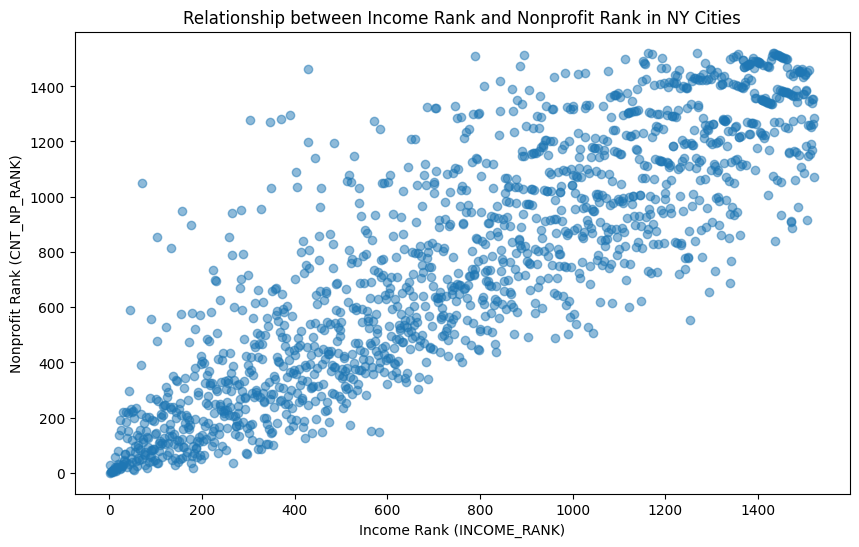

In [ ]:
# @title Relationship between Income Rank and Nonprofit Rank in NY Cities

# bmf_cities_df.info()

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(bmf_cities_df['inc_rank_seq'], bmf_cities_df['np_cnt_rank_seq'], alpha=0.5)
plt.title('Relationship between Income Rank and Nonprofit Rank in NY Cities')
plt.xlabel('Income Rank (INCOME_RANK)')
_ = plt.ylabel('Nonprofit Rank (CNT_NP_RANK)')

In [ ]:
display (df)
#df.info()

,EIN,NAME,ICO,STREET,CITY,STATE,ZIP,GROUP,SUBSECTION,AFFILIATION,CLASSIFICATION,RULING,DEDUCTIBILITY,FOUNDATION,ACTIVITY,ORGANIZATION,STATUS,TAX_PERIOD,ASSET_CD,INCOME_CD,FILING_REQ_CD,PF_FILING_REQ_CD,ACCT_PD,ASSET_AMT,INCOME_AMT,REVENUE_AMT,NTEE_CD,SORT_NAME,p_org_id,ntee_cat,ntee_define,class_cd_1,class_cd_2,class_cd_3,class_cd_4,activity_cd_1,activity_cd_2,activity_cd_3,act1_lu,act2_lu,act3_lu,RULE_DT,aff_lu,org_lu,found_lu,deduct_lu,zipcode,zipcode_type,major_city,post_office_city,common_city_list,uszip_county,state,radius_in_miles,area_code_list,population,population_density,land_area_in_sqmi,water_area_in_sqmi,housing_units,occupied_housing_units,median_home_value,median_household_income,bounds_west,bounds_east,bounds_north,bounds_south
0,002022084,ST ROSALIAS ROMAN CATHOLIC CHURCH,NaN,1230 65TH ST,BROOKLYN,NY,11219-5614,0928,3,9,1270,194603,1,10,001000000,5,1,NaN,0,0,6,0,12,NaN,NaN,NaN,NaN,NaN,0,no_NTEE,no_NTEE,1,2,7,0,1,0,0,"Church,synagogue, etc",na,na,1946-03-01,(9) Subordinate (in Group),Association,Church,Contributions deductible.,11219,STANDARD,Brooklyn,"Brooklyn, NY",['Brooklyn'],Kings County,NY,1.000000,718,92221.0,62225.0,1.48,0.00,28693.0,26177.0,726700.0,34316.0,-74.012702,-73.981181,40.647101,40.619712
1,002045409,GENERAL COUNCIL OF ASSEMBLIES OF GOD FULL GOSP...,NaN,3210 SOUTHWESTERN BLVD,ORCHARD PARK,NY,14127-1229,1678,3,9,7000,196408,1,10,029002000,5,1,NaN,0,0,6,0,8,NaN,NaN,NaN,NaN,NaN,1,no_NTEE,no_NTEE,7,0,0,0,29,2,0,Other religious activities,Association or convention of churches,na,1964-08-01,(9) Subordinate (in Group),Association,Church,Contributions deductible.,14127,STANDARD,Orchard Park,"Orchard Park, NY",['Orchard Park'],Erie County,NY,7.000000,716,29961.0,728.0,41.13,0.08,12586.0,11816.0,194500.0,77636.0,-78.809896,-78.677829,42.819514,42.671722
2,010263908,SKOWHEGAN SCHOOL OF PAINTING AND SCULPTURE INC,NaN,136 WEST 22ND STREET,NEW YORK,NY,10011-0000,0000,3,3,2000,194707,1,11,046119030,1,1,202212,8,8,1,0,12,37441974.0,14311291.0,9416151.0,A250,NaN,2,"(A) Arts, Culture & Humanities",Organizations that provide informal arts educa...,2,0,0,0,46,119,30,Private school,Other cultural or historical activities,"School, college, trade school, etc.",1947-07-01,Independent,Corporation,School,Contributions deductible.,10011,STANDARD,New York,"New York, NY",['New York'],New York County,NY,0.909091,"212,347,646,718,917,929",50984.0,77436.0,0.66,0.00,33252.0,30294.0,914500.0,104238.0,-74.012359,-73.990798,40.756703,40.731043
3,010284115,MAIN IDEA INC,% SARAH STERN TREASURER,180 EAST PROSPECT AVE 178,MAMARONECK,NY,10543-3709,0000,3,3,1200,196905,1,16,325059349,1,1,202212,6,4,1,0,12,1222568.0,365408.0,345314.0,NaN,NaN,3,no_NTEE,no_NTEE,1,2,0,0,325,59,349,Camp,059Other school related activities,Other youth organization or activities,1969-05-01,Independent,Corporation,Org with 1/3 income rules,Contributions deductible.,10543,STANDARD,Mamaroneck,"Mamaroneck, NY",['Mamaroneck'],Westchester County,NY,3.000000,914,20135.0,4928.0,4.09,0.18,7971.0,7436.0,598000.0,87316.0,-73.757999,-73.713686,40.980429,40.921536
4,010391592,MAINE JAZZ CAMP,NaN,VAN BRUNT STATION BOX 150-597,BROOKLYN,NY,11215-0000,0000,3,3,1000,198809,1,16,149319000,1,1,202312,2,3,2,0,12,21639.0,38091.0,38091.0,B99Z,NaN,4,(B) Education,Use this code for organizations that clearly p...,1,0,0,0,149,319,0,Other instruction and training,Other social activities,na,1988-09-01,Independent,Corporation,Org with 1/3 income rules,Contributions deductible.,11215,STANDARD,Brooklyn,"Brooklyn, NY",['Brooklyn'],Kings County,NY,1.000000,718,63488.0,29148.0,2.18,0.02,30073.0,28077.0,913200.0,95654.0,-74.002144,-73.970419,40.680033,40.644119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119760,992929125,SECURE BETTER LIVING INC,% BROOKLYNN DAVIS,313 BA

## Cities and Income Ranking

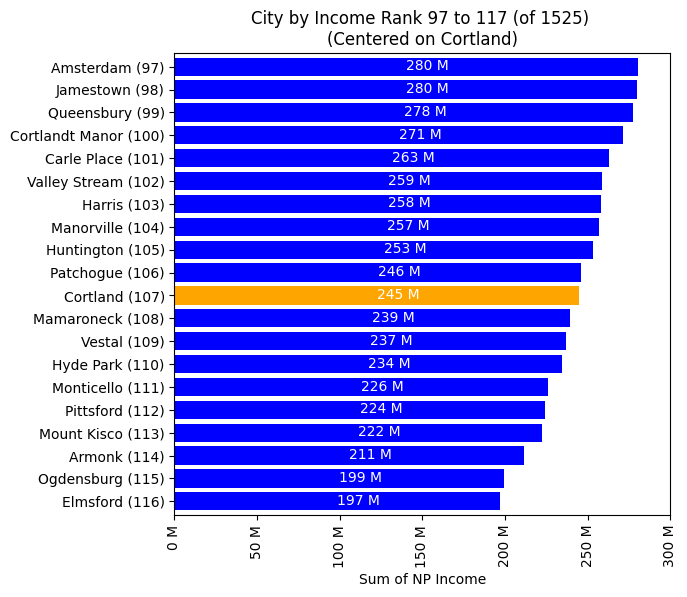

In [ ]:
# ------------------------------------
# Cities and NP Income Ranking (*)
# ------------------------------------

# Bar Horizontal of Cities and Sum of Incomes, Ranked
# Provide a City Name, Nbrhttps://colab.research.google.com/drive/1qZOp42U3HOeBFDizil4f82bP0BrBrA0Y#scrollTo=Cities_and_Income_Ranking of Results wanted
# or ranking range

# Notes:
#   Using ny_cities_df dataframe
#TODO:  add other census data to a cities dataframe

results_cnt = 20 # how many cities to get

# provide a city or give rank start/end
srch_city = 'CORTLAND'
#srch_city = 'NEW YORK'
srch_city = 'Cortland'

# Find Rank of City, then get half results count above and below in ranking
#filt = ny_cities_df['CITY'] == srch_city
filt = ny_cities_df['major_city'] == srch_city
srch_city_rank = ny_cities_df[filt]['INCOME_RANK'].values[0]

rank_start = ny_cities_df[filt]['INCOME_RANK'].values[0] - (int(results_cnt/2))
rank_end = ny_cities_df[filt]['INCOME_RANK'].values[0] + (int(results_cnt/2))

if rank_start < 0:
    rank_start = 0
rank_end = rank_start + results_cnt

cities_cnt = len(ny_cities_df.index) # Total Nbr of Cities
label_format =  '{:,.0f} M'

fig, ax = plt.subplots()

# sort out fig height depending on how rows being returned
figh = int( ( (rank_end - rank_start) / 3))
fig.set_figheight(figh)

y_pos =np.arange (rank_end - rank_start)

# get cities in rank range
filt = (ny_cities_df['INCOME_RANK'] >= rank_start) & (ny_cities_df['INCOME_RANK'] < rank_end)
selected_cities = ny_cities_df[filt].sort_values(by=['INCOME_RANK'])

# build bar color matrix
bar_color = "blue"
my_colors = [bar_color] * results_cnt
#my_colors = [bar_color] * len(selected_cities)

# make selected city another color
city_list = selected_cities['major_city'].to_list()
my_colors[city_list.index(srch_city)] = "orange"

# get income for each selected city
city_inc = selected_cities['INCOME_AMT'] / 1000000

# create labels for each city
city_labs = selected_cities['major_city'] + ' ' + \
            "(" + selected_cities['INCOME_RANK'].astype(str) + ")"

ax.barh(y_pos, city_inc, align='center', color=my_colors)

ax.set_yticks(y_pos, labels=city_labs)

ax.invert_yaxis()  # lowest rank (greater income) at top

ax.set_xticks(ax.get_xticks())
ticks_loc = ax.get_xticks().tolist()
ax.set_xticklabels([label_format.format(x) for x in ticks_loc], rotation=90)

# label values on bars
#matplotlib.pyplot.text(x, y, s, fontdict=None, **kwargs)
for index, value in enumerate(city_inc):
    plt.text(value/2, index + .15,
             label_format.format(value),
             color = 'white'
             )

ax.set_xlabel('Sum of NP Income')

chart_title = f'City by Income Rank {rank_start} to {rank_end} (of {cities_cnt}) '
chart_title += f'\n(Centered on {srch_city})'
#ax.set_title(f'City by Income Rank {rank_start} to {rank_end} (of {cities_cnt}) ')
ax.set_title(chart_title)

plt.margins(y=0.01)

plt.show()




## Cities and Count of Nonprofits Ranking

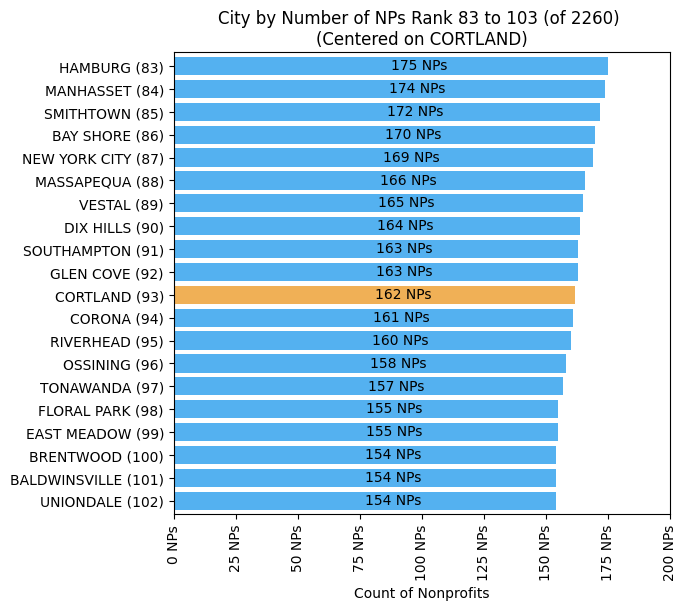

In [ ]:
# ------------------------------------
# Cities and Number of Nonprofits Ranking
# ------------------------------------

# Bar Horizontal of Cities and Sum of Incomes, Ranked
# Provide a City Name, Nbr of Results wanted
# or ranking range

# Notes:
#   Using ny_cities_df dataframe
#TODO:  add other census data to a cities dataframe

results_cnt = 20 # how many cities to get

# provide a city or give rank start/end
srch_city = 'CORTLAND'
#srch_city = 'NEW YORK'
#srch_city = 'BROOKLYN'
# Find Rank of City, then get half results count above and below in ranking
filt = ny_cities_df['CITY'] == srch_city
srch_city_rank = ny_cities_df[filt]['CNT_NP_RANK'].values[0]

rank_start = ny_cities_df[filt]['CNT_NP_RANK'].values[0] - (int(results_cnt/2))
rank_end = ny_cities_df[filt]['CNT_NP_RANK'].values[0] + (int(results_cnt/2))

if rank_start < 0:
    rank_start = 0
rank_end = rank_start + results_cnt

cities_cnt = len(ny_cities_df.index) # Total Nbr of Cities
label_format =  '{:,.0f} NPs'

fig, ax = plt.subplots()

# sort out fig height depending on how rows being returned
figh = int( ( (rank_end - rank_start) / 3))
fig.set_figheight(figh)

y_pos =np.arange (rank_end - rank_start)

# get cities in rank range
filt = (ny_cities_df['CNT_NP_RANK'] >= rank_start) & (ny_cities_df['CNT_NP_RANK'] < rank_end)
selected_cities = ny_cities_df[filt].sort_values(by=['CNT_NP_RANK'])

# build bar color matrix
bar_color = "#54b1f0"
my_colors = [bar_color] * results_cnt
#my_colors = [bar_color] * len(selected_cities)

# make selected city another color
city_list = selected_cities['CITY'].to_list()
my_colors[city_list.index(srch_city)] = "#f0b056"

# get income for each selected city
city_inc = selected_cities['NP_CNT']

# create labels for each city
city_labs = selected_cities['CITY'] + ' ' + \
            "(" + selected_cities['CNT_NP_RANK'].astype(str) + ")"

ax.barh(y_pos, city_inc, align='center', color=my_colors)

ax.set_yticks(y_pos, labels=city_labs)

ax.invert_yaxis()  # lowest rank (greater income) at top

ax.set_xticks(ax.get_xticks())
ticks_loc = ax.get_xticks().tolist()
ax.set_xticklabels([label_format.format(x) for x in ticks_loc], rotation=90)

# label values on bars
#matplotlib.pyplot.text(x, y, s, fontdict=None, **kwargs)
for index, value in enumerate(city_inc):
    plt.text(value/2, index + .15,
             label_format.format(value),
             color = 'black'
             )

ax.set_xlabel('Count of Nonprofits')

chart_title = f'City by Number of NPs Rank {rank_start} to {rank_end} (of {cities_cnt}) '
chart_title += f'\n(Centered on {srch_city})'
#ax.set_title(f'City by Income Rank {rank_start} to {rank_end} (of {cities_cnt}) ')
ax.set_title(chart_title)

plt.margins(y=0.01)

plt.show()




## Income and NTEE

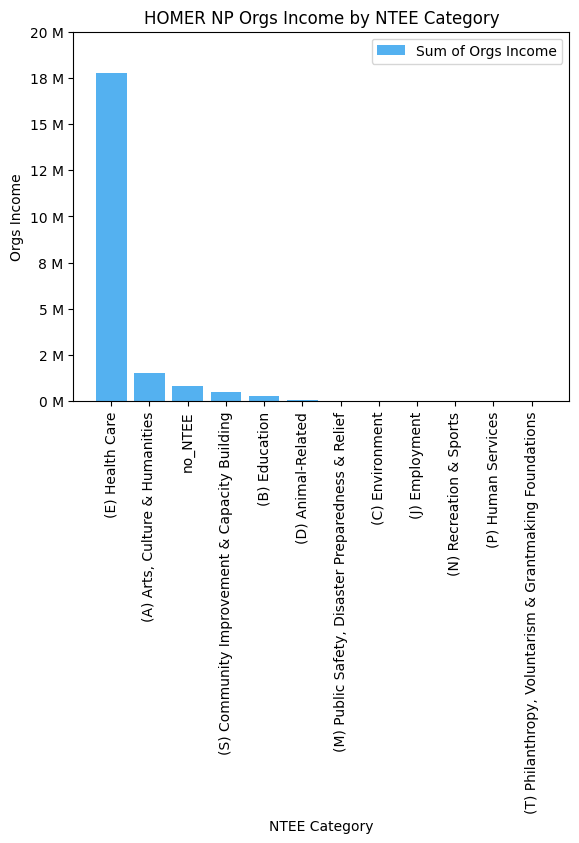

In [ ]:
# ----- INCOME BY NTEE category

srch_city = 'All NY'
#srch_city = 'CORTLAND'
srch_city = 'HOMER'

if srch_city == 'All NY':
  result = df.groupby(['ntee_cat'])['INCOME_AMT'].sum().sort_values(ascending=False)
else:
  filt = df['CITY'] == srch_city
  result = df[filt].groupby(['ntee_cat'])['INCOME_AMT'].sum().sort_values(ascending=False)

# result = df[filt].groupby(['ntee_cat'])['INCOME_AMT'].sum().sort_values(ascending=False)

label_format =  '{:,.0f} M'

fig, ax1 = plt.subplots()
#fig, (ax1, ax2)  = plt.subplots(2, 1)

ax1.bar(result.index,
        #result.values,
        result.values / 1000000,
        color="#54b1f0",
        label='Sum of Orgs Income')
ax1.legend()
#ax1.set_xticklabels(result.index, rotation=90)

# avoid weird warning...
ax1.xaxis.set_ticks(result.index)
ax1.xaxis.set_ticklabels(result.index,rotation=90)

# this odd line remove warning to use formatter before locator
ax1.set_yticks(ax1.get_yticks())
ticks_loc = ax1.get_yticks().tolist()
ax1.set_yticklabels([label_format.format(x) for x in ticks_loc])


ax1.set_xlabel('NTEE Category')
ax1.set_ylabel('Orgs Income')
ax1.set_title(f'{srch_city} NP Orgs Income by NTEE Category')

plt.show()


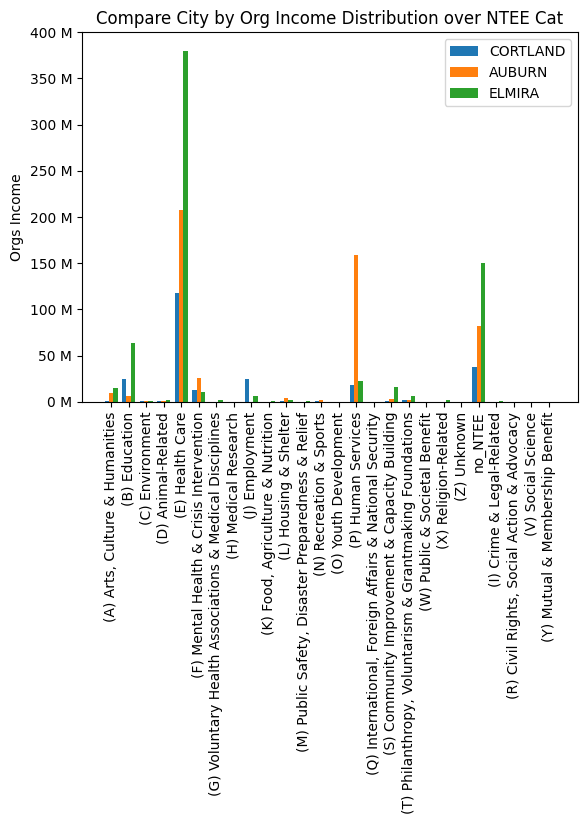

In [ ]:
# V2: Compare Orgs Income Sum over NTEEs of different Cities
# merge into one dataframe
# do grouped bar

#TODO:  Add Census Population
#TODO:  Add Cities List, iterate dataframe
#TODO:  Each NTEE as Percentage of Total to "normalize"
#TODO:  research concat vs join/merge.  docs say concatcreate copies.
#TODO:  research multi-index
#TODO:  skip certain codes, especially like Health Care

# NOTE: comparing all NY to cortland disappears cortland

cortland_ntee = df[df['CITY'] == 'CORTLAND'].groupby(['ntee_cat'])['INCOME_AMT'].agg(['sum'])
#display(cortland_ntee)
cortland_ntee=cortland_ntee.rename(columns = {'sum':'CORTLAND'})

# compare to different places

comp_city = 'AUBURN'
comp_ntee = df[df['CITY'] == comp_city].groupby(['ntee_cat'])['INCOME_AMT'].agg(['sum'])
comp_ntee=comp_ntee.rename(columns = {'sum': comp_city})

comp2_city = 'ELMIRA'
comp2_ntee = df[df['CITY'] == comp2_city].groupby(['ntee_cat'])['INCOME_AMT'].agg(['sum'])
comp2_ntee=comp2_ntee.rename(columns = {'sum': comp2_city})

# Combine the results into a single DataFrame - gives multi-index
# it's handy for iteration, but should research
#result = pd.concat([cortland_ntee, comp_ntee], keys=['ntee_cat', 'ntee_cat'], axis=1)
result = pd.concat([cortland_ntee, comp_ntee, comp2_ntee],
                   keys=['ntee_cat', 'ntee_cat', 'ntee_cat'],
                   axis=1)


# display(result)
# print (result.columns)
# print (result.info())
# print (result.describe())

# can access values with multi index
# result['ntee_cat', 'cortland_sum'].plot.bar(legend=True)

fig, ax = plt.subplots()
width = 0.25  # the width of the bars
multiplier = 0

x = np.arange(len(result['ntee_cat']))

for attribute, measurement in result['ntee_cat'].items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    # ax.bar_label(rects, padding=3)
    multiplier += 1
    # print ("Multiplier: ", multiplier)
    # print ("offset: ", offset)
    # print ("attribute: ", attribute)
    # print ("measurement: ", measurement)

label_format = '{:,.0f} M'

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Orgs Income')
ax.set_title('Compare City by Org Income Distribution over NTEE Cat')

#ax.set_xticks(x + width, result['ntee_cat'])
ax.set_xticks(x + width, result.index)
ax.legend(loc='upper right') #, ncols=3)

# avoid weird warning, formatter/locator order
#ax.xaxis.set_ticks(result['ntee_cat'])
#ax.xaxis.set_ticklabels(result['ntee_cat'],rotation=90)
ax.xaxis.set_ticklabels(result.index, rotation=90)

# this odd line remove warning to use formatter before locator
ax.set_yticks(ax.get_yticks())
ticks_loc = ax.get_yticks().tolist()
ax.set_yticklabels([label_format.format(x/1000000) for x in ticks_loc])

plt.show()




<Axes: xlabel='ntee_cat'>

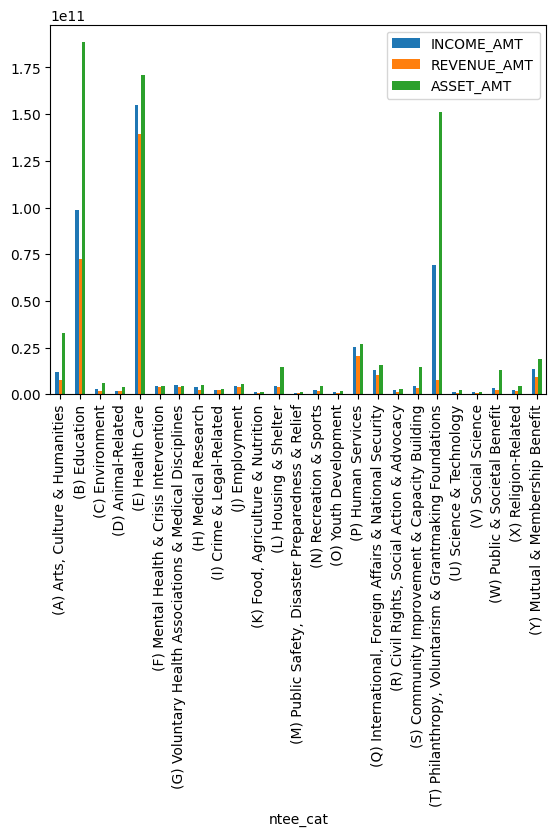

In [ ]:
# Using Pandas Plot with Filter
#

filt = ~(df['ntee_cat'].isin(['no_NTEE', 'invalid_NTEE', '(Z) Unknown']) )
#print (df.loc[filt])

#df.loc[filt].groupby(['ntee_cat'])['p_org_id'].count().plot.bar(legend=True)

df[filt].groupby(['ntee_cat'])[['INCOME_AMT', 'REVENUE_AMT', 'ASSET_AMT']].sum().plot.bar(legend=True)

#df.loc[filt].groupby(['ntee_cat'])['REVENUE_AMT'].sum().plot.bar(legend=True)



## Quick Plot Tests

In [ ]:
# testing summaries
# summarizing corland vs total

df.loc[df['CITY'] == 'CORTLAND', 'ntee_cat'].sum()

#Using loc:
#df.loc[df['CITY'] == 'CORTLAND'].INCOME_AMT.sum()

#Using groupby:
#df.groupby('CITY')['INCOME_AMT'].sum()

# Calculate sum of INCOME_AMT for CITY equals CORTLAND
cortland_income_sum = df[df['CITY'] == 'CORTLAND']['INCOME_AMT'].sum()

# Calculate total sum of INCOME_AMT for the entire DataFrame
total_income_sum = df['INCOME_AMT'].sum()

print("Sum of INCOME_AMT for CORTLAND:", cortland_income_sum)
print("Total sum of INCOME_AMT:", total_income_sum)



Sum of INCOME_AMT for CORTLAND: 244586221.0
Total sum of INCOME_AMT: 526874950693.0


<Axes: xlabel='ntee_cat'>

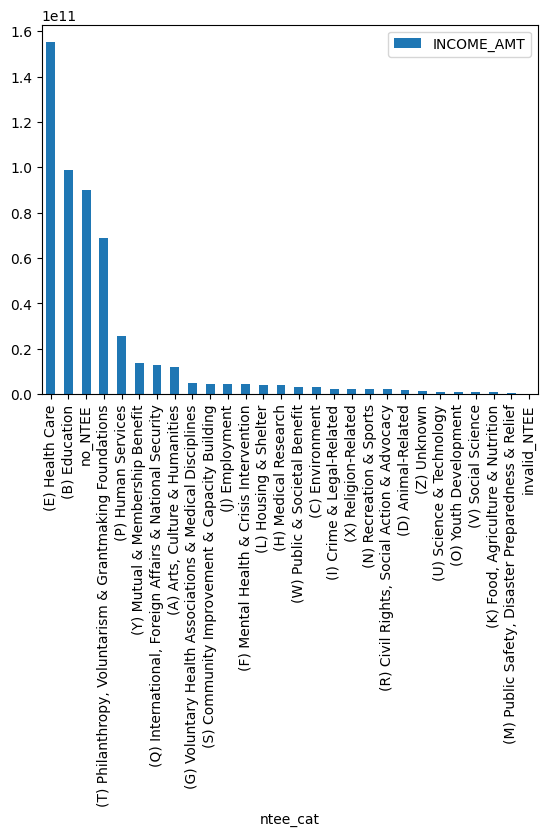

In [ ]:
# ----- INCOME BY ntee category
# simple pandas plot

# works
#df.groupby(['ntee_cat'])['INCOME_AMT'].sum().plot.bar(legend=True)

df.groupby(['ntee_cat'])['INCOME_AMT'].sum().sort_values(ascending=False).plot.bar(
    legend=True)



[]

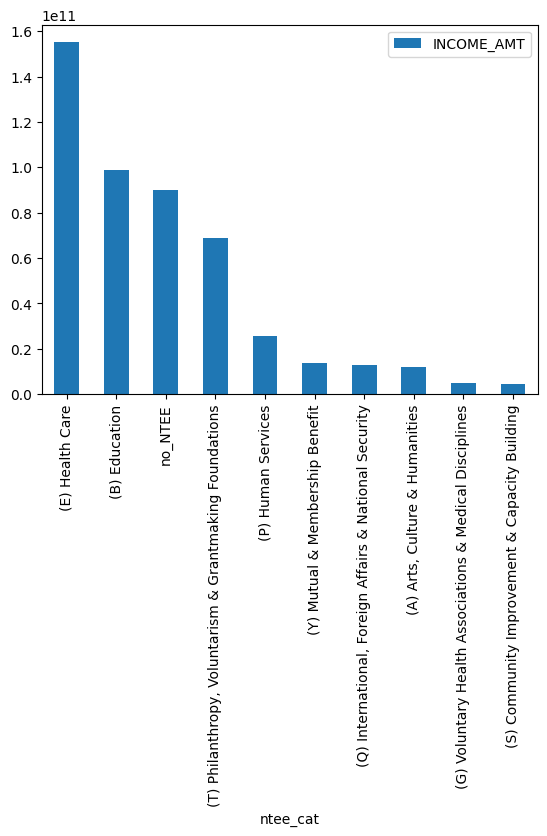

In [ ]:

df.groupby(['ntee_cat'])['INCOME_AMT'].sum('INCOME_AMT').sort_values().nlargest(10).plot.bar(legend=True).plot(legend=True,
                      title="Orgs by NTEE CAT",                                                                                                               xlabel="NTEE CAT",
                      ylabel="Nbr of Orgs",
                      table=True)



[]

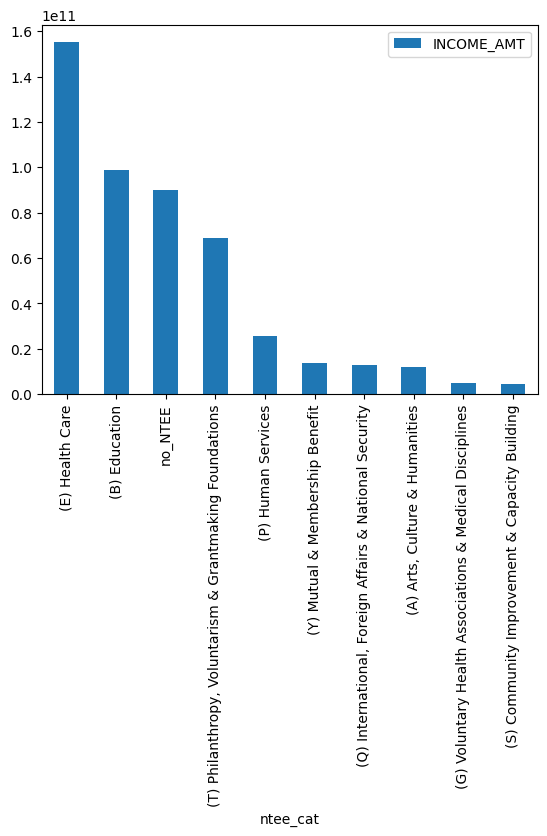

In [ ]:
df.groupby(['ntee_cat'])['INCOME_AMT'].sum('INCOME_AMT').sort_values().nlargest(10).plot.bar(legend=True).plot(legend=True,
                      xlabel="NTEE CAT",
                      ylabel="Nbr of Orgs",
                      title="Orgs by NTEE CAT",
                      table=True)



<Axes: title={'center': 'Count Orgs by NTEE Category'}, xlabel='NTEE Category', ylabel='Nbr of Orgs'>

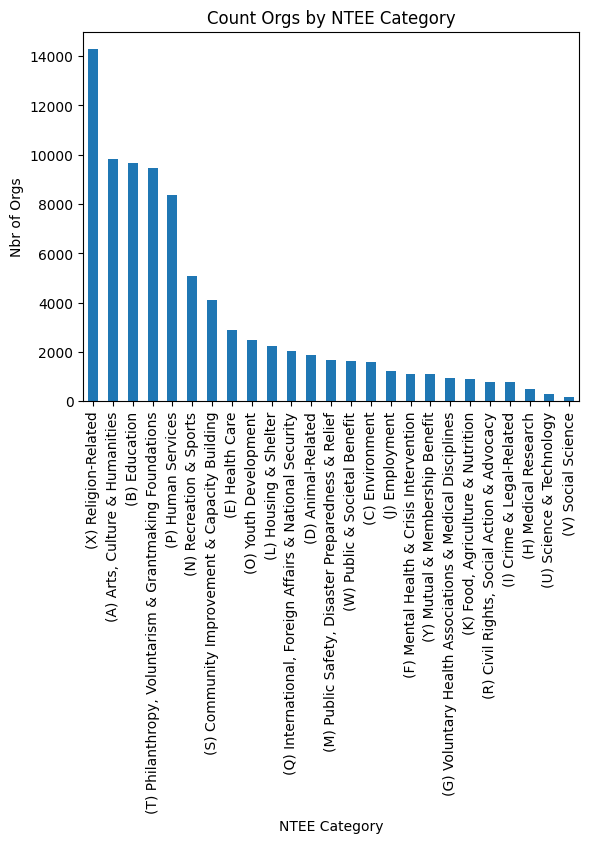

In [ ]:
# ----- Org Count BY ntee category


# df.groupby([['ntee_cat'], ['p_org_id']]).count().plot.bar(legend=True)
# df['ntee_cat'].groupby(['ntee_cat'], ['p_org_id']).count()
# df = data.groupby(['pulse', 'diet']).count()['p_org_id']
# df.groupby(['ntee_cat']).count()['p_org_id']
# df.groupby(['ntee_cat']).count()

# seems to work
#display (df.groupby(['ntee_cat'])['INCOME_AMT'].sum())

# display (df.groupby(['ntee_cat'])['p_org_id'].count())

# exclude = ['no_NTEE']

filt = ~(df['ntee_cat'].isin(['no_NTEE', 'invalid_NTEE', '(Z) Unknown']) )
#print (df.loc[filt])

df.loc[filt].groupby(['ntee_cat'])['p_org_id'].count().sort_values(ascending=False).plot.bar(legend=False,
                      title="Count Orgs by NTEE Category",
                      xlabel = "NTEE Category",
                      ylabel = "Nbr of Orgs")





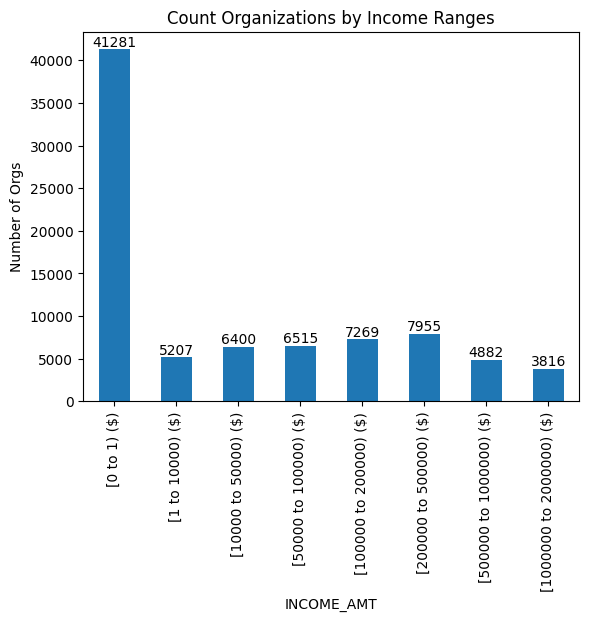

In [ ]:
# ---------------------------
# Plot Income with my defined bins
# ---------------------------
from matplotlib import pyplot as plt
import locale
import re

# TODO: format bins tidier.  have to break apart binning to apply format?
# label_format = {:,.0f}

bins = [0, 1,10000,50000,100000,200000, 500000,1000000, 2000000]

out = pd.cut(df['INCOME_AMT'], bins=bins, right=False, include_lowest=True)
#print (type(out), out.count())
#print (out.value_counts(sort=False))

# out.value_counts().reindex(out.cat.categories)

# collect labels for x axis
# print ("\nout cat: ", type(out.cat))
# print ("out cat categories: ", type(out.cat.categories))


xlabs = []
for c in out.cat.categories:
  # print (type(c), c)
  h = str(c)
  #i = re.sub(r"\(|\]|\.0", '', h).replace(","," to")
  i = h.replace(","," to")
  xlabs.append(i + " ($)")


#ax = out.value_counts(sort=False).plot.bar(rot=0, color="b")
ax = out.value_counts(sort=False).plot.bar()

ax.set_xticklabels(xlabs,rotation=90)

ax.set_ylabel("Number of Orgs")
ax.set_title("Count Organizations by Income Ranges")
ax.bar_label(ax.containers[0])
plt.show()




Text(0, 0.5, 'Nbr of Orgs')

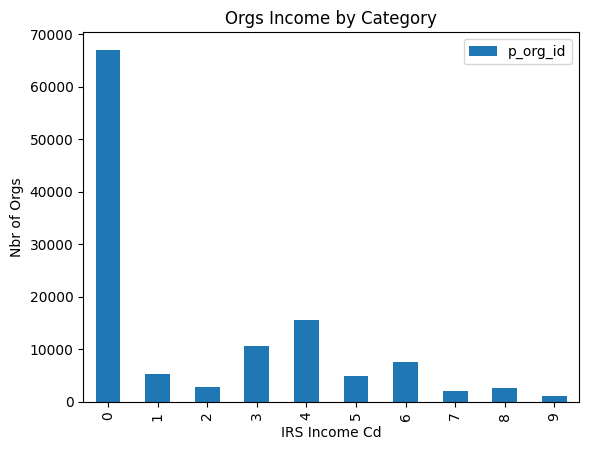

In [ ]:


filt = ~(df['ntee_cat'].isin(['no_NTEE', 'invalid_NTEE', '(Z) Unknown']) )
#print (df.loc[filt])

#df.loc[filt].groupby(['ntee_cat'])['p_org_id'].count().plot.bar(legend=True)

# df.loc[filt].groupby(['ntee_cat'])[['INCOME_AMT', 'REVENUE_AMT', 'ASSET_AMT']].sum().plot.bar(legend=True)

#df.groupby(['INCOME_CD'])['p_org_id'].count().plot.bar(legend=True)

ax = df.groupby(['INCOME_CD'])['p_org_id'].count().plot(legend="Orgs",
              title='Orgs Income by Category',
              kind='bar')
ax.set_xlabel("IRS Income Cd")
ax.set_ylabel("Nbr of Orgs")




## Orgs by Income (IRS Income Code)

In [ ]:
# ------------------------------------
# Building code for Orgs and IRS Income Code
# Trying to get a general version that find all the lookups
# and presents all columns
# could be used for any report where lookup codes are integers?
# x axis is the lookups
# y index is values


#result = df.groupby(['INCOME_CD'])['p_org_id'].count().sort_values(ascending=False)

category = 'INCOME_CD'
result = df.groupby(['INCOME_CD'])['p_org_id'].count()

# populate data dict with all lookups
data = {}

xy = zip(result.index, result.values)
for cat in xy:
  # print ("cat 0 type: ", type(cat[0]))
  # print ("x: ", cat[0], "y: ", cat[1] )
  # data[x] = y
  data[cat[0]] = cat[1]

# -- adding zeros to data
for cd in (cd for cd in bmf[category] if cd != 'define') :
  cd_int = int(cd)
  # print (cd, bmf['INCOME_CD'][cd]['short'])
  if cd_int in data:
    print (data[cd_int])
  else:
    data[cd_int] = 0

print (data.keys())
print (data.values())

#for x in data:
  #print ("income code: ", x,
  #       "yval: ", data[x],
  #       "lookup: ", bmf['INCOME_CD'][str(x)]['short']
  #       )



67046
5327
2808
10569
15644
5008
7557
2021
2629
1156
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
dict_values([67046, 5327, 2808, 10569, 15644, 5008, 7557, 2021, 2629, 1156])


ValueError: The number of FixedLocator locations (10), usually from a call to set_ticks, does not match the number of labels (8).

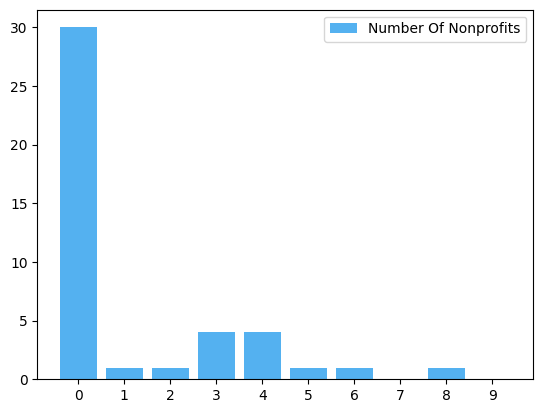

In [ ]:
# redo Orgs by IRS Income Code *** works

#srch_city = '(all)'
#srch_city = 'CORTLAND'
srch_city = 'HOMER'
#srch_city = 'ADAMS CENTER'

if srch_city == '(all)':
  #result = df.groupby(['ntee_cat'])['INCOME_AMT'].sum().sort_values(ascending=False)
  result = df.groupby(['INCOME_CD'])['p_org_id'].count()

else:
  filt = df['CITY'] == srch_city
  result = df[filt].groupby(['INCOME_CD'])['p_org_id'].count()

# populate data dict with all lookups
data = {}

xy = zip(result.index, result.values)
for cat in xy:
  data[cat[0]] = cat[1]

xlabs = []
# -- adding zeros to data and setup xlabels
for cd in (cd for cd in bmf[category] if cd != 'define') :
  xlabs.append(bmf['INCOME_CD'][cd]['short'])
  cd_int = int(cd)
  # print (cd, bmf['INCOME_CD'][cd]['short'])
  if cd_int not in data:
    data[cd_int] = 0

label_format =  '{:,.0f}'

fig, ax1 = plt.subplots()

ax1.bar(list(data.keys()),
        list(data.values()),
        color="#54b1f0",
        label='Number Of Nonprofits')
ax1.legend()
#ax1.set_xticklabels(result.index, rotation=90)

# avoid weird warning...
ax1.xaxis.set_ticks(list(data.keys()))
ax1.xaxis.set_ticklabels(xlabs,rotation=90)

# this odd line remove warning to use formatter before locator
ax1.set_yticks(ax1.get_yticks())
ticks_loc = ax1.get_yticks().tolist()
ax1.set_yticklabels([label_format.format(x) for x in ticks_loc])

ax1.set_xlabel('IRS Income Category')
ax1.set_ylabel('Number of Nonprofits')
ax1.set_title(f'{srch_city} NP Orgs and Income Category')

plt.show()




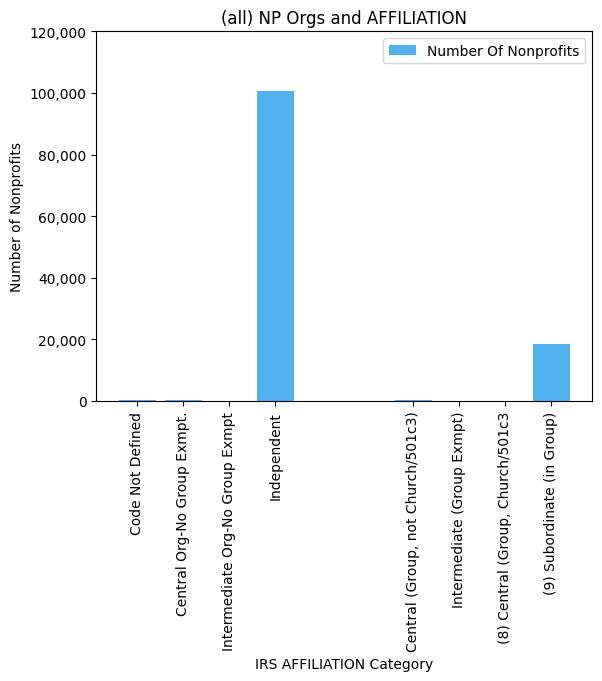

In [ ]:
# Reusable code to plot different variables - by category
# counting nonprofits by various data elements

category = 'INCOME_CD'
category = 'AFFILIATION'
#category = 'SUBSECTION'
#category = 'ORGANIZATION'


srch_city = '(all)'
#srch_city = 'CORTLAND'
#srch_city = 'ITHACA'
#srch_city = 'HOMER'
#srch_city = 'ADAMS CENTER'

if srch_city == '(all)':
  #result = df.groupby(['ntee_cat'])['INCOME_AMT'].sum().sort_values(ascending=False)
  result = df.groupby([category])['p_org_id'].count()

else:
  filt = df['CITY'] == srch_city
  result = df[filt].groupby([category])['p_org_id'].count()

# populate data dict with all lookups
data = {}
xlabs = []

xy = zip(result.index, result.values)
for cat in xy:
  data[cat[0]] = cat[1]


# -- adding zeros to data and setup xlabels
for cd in (cd for cd in bmf[category] if cd != 'define') :
  xlabs.append(bmf[category][cd]['short'])
  cd_int = int(cd)
  # print (cd, bmf['INCOME_CD'][cd]['short'])
  if cd_int not in data:
    data[cd_int] = 0

label_format =  '{:,.0f}'

# debug
#print ("data keys:  ", list(data.keys()) )
#print ("data vals:  ", list(data.values()) )
#print ("xlabs:  ", xlabs)


fig, ax1 = plt.subplots()

ax1.bar(list(data.keys()),
        list(data.values()),
        color="#54b1f0",
        label='Number Of Nonprofits')
ax1.legend()
#ax1.set_xticklabels(result.index, rotation=90)

# avoid weird warning...
ax1.xaxis.set_ticks(list(data.keys()))
ax1.xaxis.set_ticklabels(xlabs,rotation=90)

# this odd line remove warning to use formatter before locator
ax1.set_yticks(ax1.get_yticks())
ticks_loc = ax1.get_yticks().tolist()
ax1.set_yticklabels([label_format.format(x) for x in ticks_loc])

ax1.set_xlabel(f"IRS {category} Category")
ax1.set_ylabel('Number of Nonprofits')
ax1.set_title(f'{srch_city} NP Orgs and {category}')

plt.show()




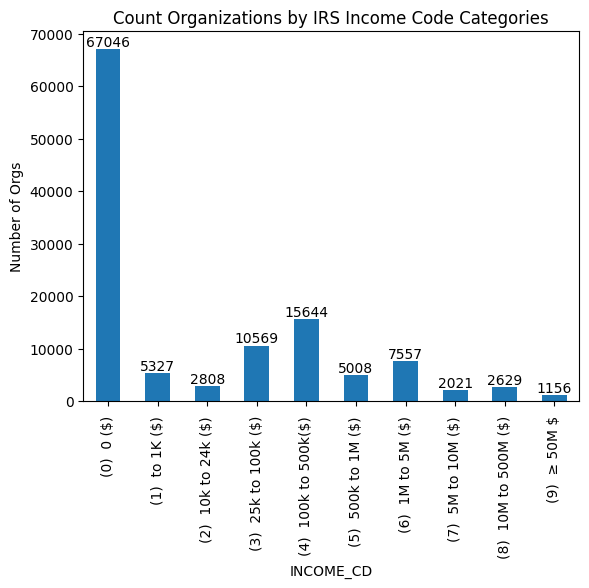

In [ ]:
# -- obsolete ---
# ---------------------------------------------
# Using IRS Income Code, Count Orgs by Income
# Lookup Income Code
# --------------------------------------------

# doesn't work for small cities because it's
# setting the labels to the lookups,
# but sometimes there is no entry

from matplotlib import pyplot as plt
import locale
import re

xlabs = []

for c in (c for c in bmf['INCOME_CD'] if c != 'define') :
  # print (c, ":", bmf['INCOME_CD'][c] )
  xlabs.append(f"({c})  {bmf['INCOME_CD'][c]['short']} ")

ax = df.groupby(['INCOME_CD'])['p_org_id'].count().plot.bar(rot=0)

ax.set_xticklabels(xlabs,rotation=90)

ax.set_ylabel("Number of Orgs")
ax.set_title("Count Organizations by IRS Income Code Categories")
ax.bar_label(ax.containers[0])
plt.show()



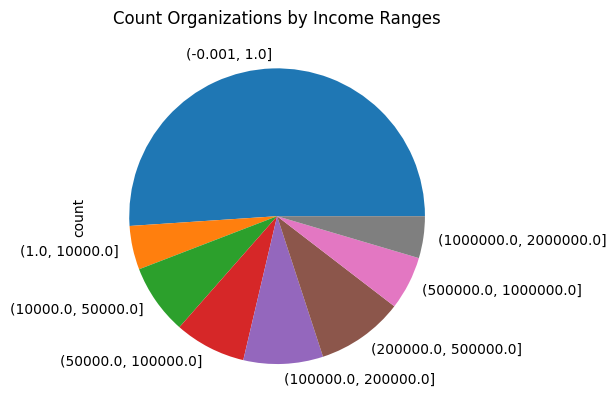

In [ ]:
# can i make a pie chart from same org count / income

# Plot income in bins

bins = [0,1,10000,50000,100000,200000, 500000,1000000, 2000000]

out = pd.cut(df['INCOME_AMT'], bins=bins, include_lowest=True)
#out.count()
#out.value_counts(sort=False)

# works -- but why is there a bracket in there?
out.value_counts().reindex(out.cat.categories)

# collect labels for x axis
import re
xlabels = []
for c in out.cat.categories:
  h = str(c)
  i = re.sub(r"\(|\]|\.0", '', h).replace(","," to")
  xlabels.append(i)

# xlabs = ["1", "2", "3","4", "5", "6", "7", "8"]

#df[df.columns[1:]].sum().plot.pie()

ax = out.value_counts(sort=False).plot.pie()
# ax.set_xticklabels(xlabs)
ax.set_xticklabels(ax.get_xticklabels())

# ax.set_ylabel("Number of Orgs")
ax.set_title("Count Organizations by Income Ranges")
# ax.bar_label(ax.containers[0])
plt.show()



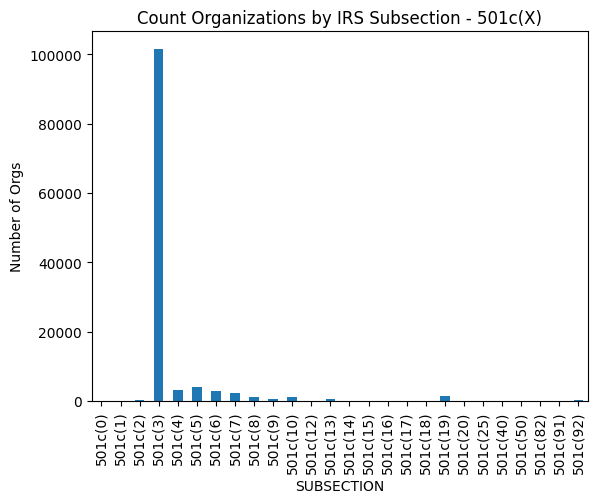


List of IRS Subsections
501c(define): Subsection Codes are the codes shown under section 501(c) of the Internal Revenue Code of 1986 which define the category under which an organization may be exempt. A table of subsection and classification codes can be found on page 6. From one to three subsection codes may be selected per request. If classification code is also selected only one subsection code may be selected.
501c(1): Corporations Organized Under Act of Congress (including Federal Credit Unions
501c(2): Title Holding Corporations for Exempt Organization
501c(3): Charitable Organization
501c(4): Civic Leagues and Social Welfare Organizations and Local Associations of Employees
501c(5): Labor, Agricultural and Horticultural Organizations
501c(6): Business Leagues, etc.
501c(7): Social and Recreation Clubs
501c(8): Fraternal Beneficiary Societies
501c(9): Voluntary Employees' Beneficiary Associations
501c(10): Domestic Fraternal Societies
501c(11): Teachers' Retirement Fund Associa

In [ ]:
# this one would be better with just 501c(x) in x
# table of lookups below

# --------------------------------
# Count Orgs By Subsection-- 501cX
# look up Subsection Code
# -------------------------------

#TODO:  why don't 90s show up in list after plot?
#TODO: compare cities



from matplotlib import pyplot as plt
import locale
import re

xlabs = []

result = df.groupby(['SUBSECTION'])['p_org_id'].count()
# xlabs = result.index
for x in result.index:
  xlabs.append(f"501c({x})")

#for c in (c for c in bmf['SUBSECTION'] if c != 'define') :
  # print (c, ":", bmf['SUBSECTION'][c] )
  # xlabs.append(f"({c})  {bmf['SUBSECTION'][c]} ")

#ax = df.groupby(['SUBSECTION'])['p_org_id'].count().plot.bar(rot=0)
ax = result.plot.bar(rot=0)

ax.set_xticklabels(xlabs,rotation=90)

ax.set_ylabel("Number of Orgs")
ax.set_title("Count Organizations by IRS Subsection - 501c(X)")
#ax.bar_label(ax.containers[0])
plt.show()

print ("\nList of IRS Subsections")

#for c in (c for c in bmf['SUBSECTION'] if c != 'define') :
for c in  bmf['SUBSECTION']:
  print (f"501c({c}): {bmf['SUBSECTION'][c]['full']}" )
  # xlabs.append(f"501c({c}):  {bmf['SUBSECTION'][c]} ")






## Orgs, Subsection, Org Type

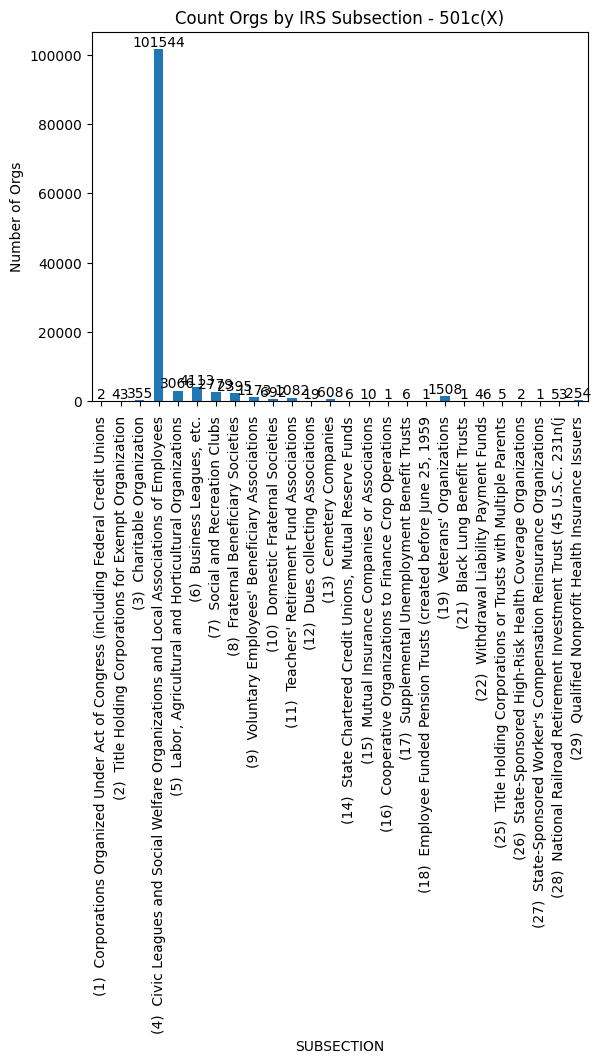

In [ ]:
# --------------------------------
# Count Orgs By Subsection-- 501cX
# look up Subsection Code
# -------------------------------

from matplotlib import pyplot as plt
import locale
import re

xlabs = []

for c in (c for c in bmf['SUBSECTION'] if c != 'define') :
  # print (c, ":", bmf['SUBSECTION'][c] )
  xlabs.append(f"({c})  {bmf['SUBSECTION'][c]['short']} ")

ax = df.groupby(['SUBSECTION'])['p_org_id'].count().plot.bar(rot=0)

ax.set_xticklabels(xlabs,rotation=90)

ax.set_ylabel("Number of Orgs")
ax.set_title("Count Orgs by IRS Subsection - 501c(X)")
ax.bar_label(ax.containers[0])
plt.show()




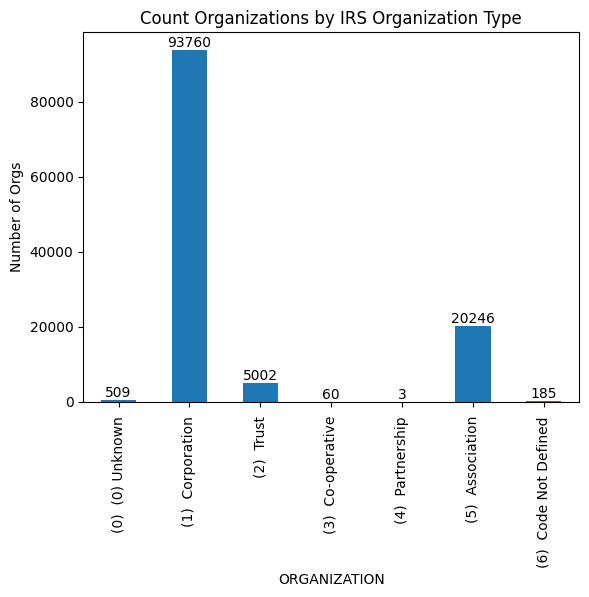

In [ ]:
# -------------------------
# count Orgs by ORGANIZATION Type
# lookup Organization Type Code
# ------------------------------

from matplotlib import pyplot as plt
import locale
import re

xlabs = []

for c in (c for c in bmf['ORGANIZATION'] if c != 'define') :
  # print (c, ":", bmf['INCOME_CD'][c] )
  xlabs.append(f"({c})  {bmf['ORGANIZATION'][c]} ")

ax = df.groupby(['ORGANIZATION'])['p_org_id'].count().plot.bar(rot=0)

ax.set_xticklabels(xlabs,rotation=90)

ax.set_ylabel("Number of Orgs")
ax.set_title("Count Organizations by IRS Organization Type")
ax.bar_label(ax.containers[0])
plt.show()



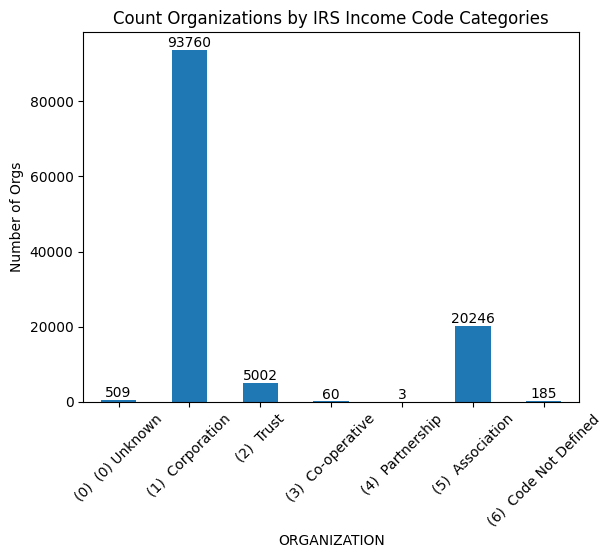

In [ ]:
# ok try this one for looking up ORGANIZATION code

from matplotlib import pyplot as plt
import locale
import re

xlabs = []

# TODO: check small datasets when there is no data for some lookup
# can use results.index as standard approach

for c in (c for c in bmf['ORGANIZATION'] if c != 'define') :
  xlabs.append(f"({c})  {bmf['ORGANIZATION'][c]}")

ax = df.groupby(['ORGANIZATION'])['p_org_id'].count().plot.bar()

ax.set_xticklabels(xlabs,rotation=45)

ax.set_ylabel("Number of Orgs")
ax.set_title("Count Organizations by IRS Org Type Categories")
ax.bar_label(ax.containers[0])
plt.show()



## Ruling, Ruling Date

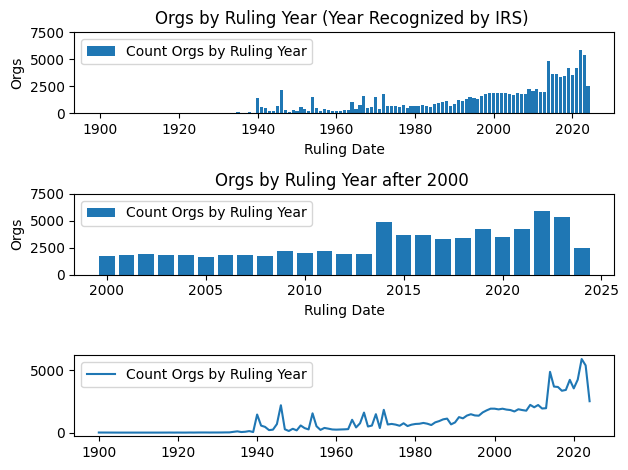

In [ ]:
# --- Plot RULING Dates

# result = df['RULING'].groupby(df['RULING']).count()

result = df.groupby(df['RULE_DT'].dt.year)['p_org_id'].count()

# result = cortland_df.groupby(['ntee_cat'])['INCOME_AMT'].sum().sort_values(ascending=False)

# label_format = '{:,.0f} M'

#fig, ax1 = plt.subplots()
fig, (ax1, ax2, ax3)  = plt.subplots(3, 1)

ax3.plot(result.index,
        result.values,
        #result.values / 1000000,
        #color='#FF0000',
        label='Count Orgs by Ruling Year')
ax3.legend()


ax1.bar(result.index,
        result.values,
        #result.values / 1000000,
        #color='#FF0000',
        label='Count Orgs by Ruling Year')
ax1.legend()
#ax1.set_xticklabels(result.index, rotation=90)

# avoid weird warning...
#ax1.xaxis.set_ticks(result.index)
#ax1.xaxis.set_ticklabels(result.index,rotation=90)

# this odd line remove warning to use formatter before locator
ax1.set_yticks(ax1.get_yticks())
ticks_loc = ax1.get_yticks().tolist()
# ax1.set_yticklabels([label_format.format(x) for x in ticks_loc])

ax1.set_xlabel('Ruling Date')
ax1.set_ylabel('Orgs')
ax1.set_title('Orgs by Ruling Year (Year Recognized by IRS) ')

# --- ax2 ----

filt = (df.RULE_DT > '2000-01-01')
result2 = df[filt].groupby(df['RULE_DT'].dt.year)['p_org_id'].count()

ax2.bar(result2.index,
        result2.values,
        #result.values / 1000000,
        #color='#FF0000',
        label='Count Orgs by Ruling Year')
ax2.legend()
#ax1.set_xticklabels(result.index, rotation=90)

# avoid weird warning...
#ax1.xaxis.set_ticks(result.index)
#ax1.xaxis.set_ticklabels(result.index,rotation=90)

# this odd line remove warning to use formatter before locator
ax2.set_yticks(ax1.get_yticks())
ticks_loc = ax2.get_yticks().tolist()
# ax1.set_yticklabels([label_format.format(x) for x in ticks_loc])

ax2.set_xlabel('Ruling Date')
ax2.set_ylabel('Orgs')
ax2.set_title('Orgs by Ruling Year after 2000 ')

fig.tight_layout()
plt.show()



In [ ]:
# look at count orgs by ruling

#cortland_ntee = df[df['CITY'] == 'CORTLAND'].groupby(['ntee_cat'])['INCOME_AMT'].agg(['sum'])
# df[df['CITY'] == 'CORTLAND'].groupby(['ntee_cat'])['INCOME_AMT'].agg(['sum'])


#df.groupby(df.your_date_column.dt.month)['values_column'].sum()

# df.groupby(df.RULE_DT.dt.month)['INCOME_AMT'].sum()
# df.groupby(df.RULE_DT.dt.year)['INCOME_AMT'].sum()
# df.groupby(df.RULE_DT.dt.year)['p_org_id'].count()

df.groupby(df['RULE_DT'].dt.year)['p_org_id'].count()

# applying groupby
#df.groupby(pd.Grouper(key='RULE_DT', axis=0,
#                      freq='1Y', sort=True)).count()

# df.groupby(pd.Grouper(key='RULE_DT', axis=0,
#                      freq='1Y', sort=True)).count()

# df.groupby(pd.Grouper(key='Date_of_Purchase', axis=0, freq='M')).sum()




RULE_DT
1900.0       7
1905.0       1
1910.0       1
1913.0       1
1915.0       1
          ... 
2020.0    3534
2021.0    4229
2022.0    5878
2023.0    5369
2024.0    2509
Name: p_org_id, Length: 113, dtype: int64

## Affiliation Plot

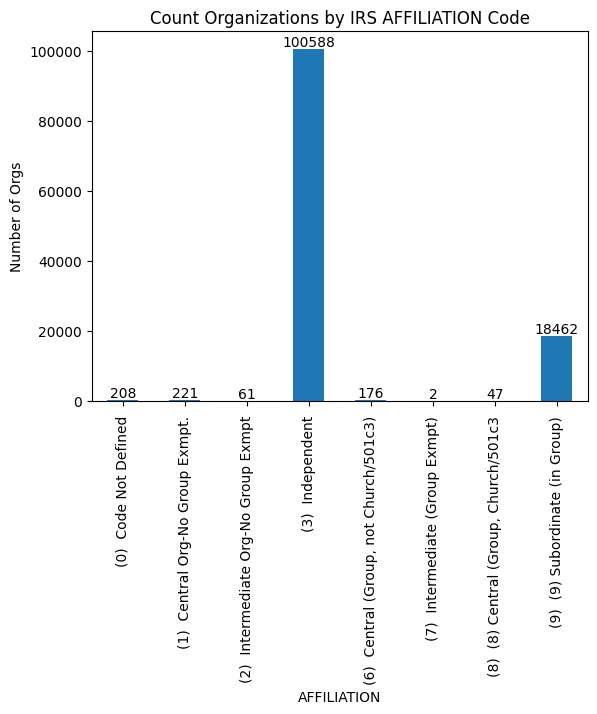


List of IRS Affiliation Codes
Affiliation Code defines the organizational grouping. (eg. Independent or an affiliate)
0 : Code Not Defined
1 : Central - This code is used if the organization is a central type organization (no group exemption) of a National, Regional or Geographic grouping of organizations.
2 : Intermediate - This code is used if the organization is an intermediate organization (no group exemption) of a National, Regional or Geographic grouping of organizations (such as a state headquarters of a national organization).
3 : Independent - This code is used if the organization is an independent organization or an independent auxiliary (i.e., not affiliated with a National, Regional, or Geographic grouping of organizations).
6 : Central - This code is used if the organization is a parent (group ruling) and is not a church or 501(c)(1) organization.
7 : Intermediate - This code is used if the organization is an group exemption intermediate organization of a National, Region

In [ ]:
# affiliation plot

xlabs = []

for c in (c for c in bmf['AFFILIATION'] if c != 'define') :
  #print (c, ":", bmf['AFFILIATION'][c] )
  xlabs.append(f"({c})  {bmf['AFFILIATION'][c]['short']} ")

# TODO: add 0 to affiliation lookup
# TODO: add short descriptions for these plots
#xlabs.append("(0) Not defined")

#ax = df.groupby(['INCOME_CD'])['p_org_id'].count().plot.bar(rot=0)

ax = df.groupby(['AFFILIATION'])['p_org_id'].count().plot.bar(rot=0)

ax.set_xticklabels(xlabs,rotation=90)

ax.set_ylabel("Number of Orgs")
ax.set_title("Count Organizations by IRS AFFILIATION Code")
ax.bar_label(ax.containers[0])
plt.show()

print ("\nList of IRS Affiliation Codes")
print (bmf['AFFILIATION']['define']['full'])

for c in (c for c in bmf['AFFILIATION'] if c != 'define') :
  print (c, ":", bmf['AFFILIATION'][c]['full'] )





## Activity

In [ ]:
# ACT1-3 NOT Implemented

# df.groupby(['ACTIVITY'])['p_org_id'].count()
#df.groupby(['ACT1'])['p_org_id'].count()

for c in (c for c in bmf['ACTIVITY'] if c != 'define') :
  print (c, ":", bmf['ACTIVITY'][c] )
  #xlabs.append(f"({c})  {bmf['FOUNDATION'][c]}")



## Foundation

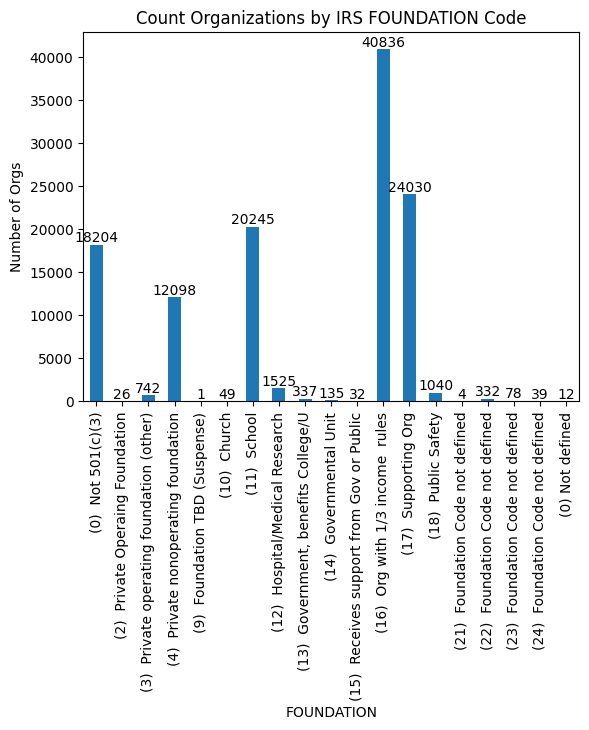

Foundation Code.  The program can select either the single foundation code requested from the following list, or one of the following ranges of codes:  02-04 2. 10-15 3. 16-18 4. 10-18
0 : All organizations except 501(c)(3)
2 : Private operating foundation exempt from paying excise taxes or investment income
3 : Private operating foundation (other)
4 : Private nonoperating foundation
9 : Suspense
10 : Church
11 : School
12 : Hospital or medical research organization
13 : Organization which operates for benefit of college or university and is owned or operated by a governmental unit
14 : Governmental unit
15 : Organization which receives a substantial part of its support from a governmental unit or the general public
16 : Organization that normally receives no more than one-third of its support from gross investment income and unrelated business income and at the same time more than one-third of its support from contributions, fees, and gross receipts related to exempt purposes.
17 : Or

In [ ]:
# Foundation Plot

# print (df.groupby(['FOUNDATION'])['p_org_id'].count())

xlabs = []

for c in (c for c in bmf['FOUNDATION'] if c != 'define') :
  #print (c, ":", bmf['AFFILIATION'][c] )
  xlabs.append(f"({c})  {bmf['FOUNDATION'][c]['short']}")

xlabs.append("(0) Not defined")

#ax = df.groupby(['INCOME_CD'])['p_org_id'].count().plot.bar(rot=0)

ax = df.groupby(['FOUNDATION'])['p_org_id'].count().plot.bar(rot=0)

ax.set_xticklabels(xlabs,rotation=90)

ax.set_ylabel("Number of Orgs")
ax.set_title("Count Organizations by IRS FOUNDATION Code")
ax.bar_label(ax.containers[0])
plt.show()


print (bmf['FOUNDATION']['define']['full'] )
for c in (c for c in bmf['FOUNDATION'] if c != 'define') :
  print (c, ":", bmf['FOUNDATION'][c]['full'] )





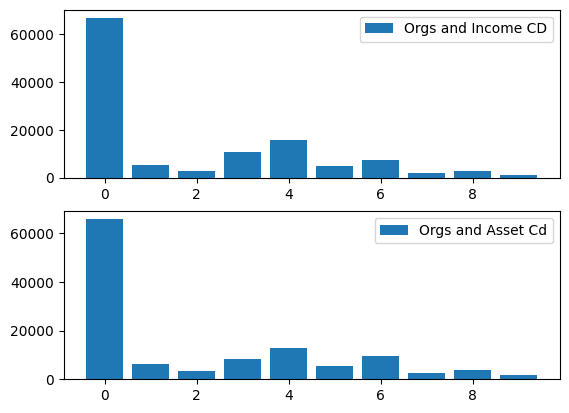

In [ ]:
# creating figure and defining ax
# feels more sensible and explicit


result = df.groupby(['INCOME_CD']).size()

fig, (ax1, ax2)  = plt.subplots(2, 1)

ax1.bar(result.index,
        result.values,
        #color='#FF0000',
        #linestyle='--',
        label='Orgs and Income CD')
ax1.legend()
ax1.set_ylabel = 'Orgs'
ax1.set_xlabel = 'Income Code'
ax1.set_title = 'Title'



result2 = df.groupby(['ASSET_CD']).size()
ax2.bar(result2.index,
         result2.values,
         #color='#FF0000',
         #linestyle='--',
        label='Orgs and Asset Cd')

ax2.legend()
ax2.set_ylabel = 'Orgs'
ax2.set_xlabel = 'Asset Code'
ax2.set_title = 'Orgs and Asset'


plt.show()


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   X       5 non-null      int64
 1   Y       5 non-null      int64
dtypes: int64(2)
memory usage: 208.0 bytes


# 6 ScratchPad

The project is a learning exercise.  I'm  leaving Miscellaneous ideas and code stubs for reference.

# 7 Data Checking

https://www.irs.gov/irm/part25/irm_25-007-001

In [ ]:
# --- Data Review ----

print (" --- check NTEE_CD ---")
print ("Type: ", df['NTEE_CD'].dtype)
print ("Nulls: ", df['NTEE_CD'].isnull().sum())

# How many are not 3 chars
print ("Check counts by length:\n", df['NTEE_CD'].str.len().value_counts())

#TODO:  Reseach Find the (13) 2 char entries; 12767 4 char entries


 --- check NTEE_CD ---
Type:  object
Nulls:  34139
Check counts by length:
 NTEE_CD
3.0    72846
4.0    12767
2.0       13
Name: count, dtype: int64


In [ ]:
# --- check out cortland that have NTEE Cd

#pd.isna(df['NTEE_CD'])

#filt = (combined_df['NTEE_CD'] == 'Cortland') & (combined_df['StateAbbreviationCd'] == 'NY')
filt =  ~pd.isna(df['NTEE_CD'])

df.loc[filt]



,EIN,NAME,ICO,STREET,CITY,STATE,ZIP,GROUP,SUBSECTION,AFFILIATION,CLASSIFICATION,RULING,DEDUCTIBILITY,FOUNDATION,ACTIVITY,ORGANIZATION,STATUS,TAX_PERIOD,ASSET_CD,INCOME_CD,FILING_REQ_CD,PF_FILING_REQ_CD,ACCT_PD,ASSET_AMT,INCOME_AMT,REVENUE_AMT,NTEE_CD,SORT_NAME,p_org_id,ntee_cat,ntee_define
2,10263908,SKOWHEGAN SCHOOL OF PAINTING AND SCULPTURE INC,NaN,136 WEST 22ND STREET,NEW YORK,NY,10011-0000,0,3,3,2000,194707,1,11,46119030,1,1,202212.0,8,8,1,0,12,37441974.0,14311291.0,9416151.0,A250,NaN,2,"(A) Arts, Culture & Humanities",Organizations that provide informal arts educa...
4,10391592,MAINE JAZZ CAMP,NaN,VAN BRUNT STATION BOX 150-597,BROOKLYN,NY,11215-0000,0,3,3,1000,198809,1,16,149319000,1,1,202312.0,2,3,2,0,12,21639.0,38091.0,38091.0,B99Z,NaN,4,(B) Education,Use this code for organizations that clearly p...
5,10426275,ANDROSCOGGIN ALUMNI ASSOCIATION INC,% SKP LLP,601 WEST ST,HARRISON,NY,10528-2508,0,3,3,1000,200609,1,15,0,1,1,202312.0,3,3,2,0,12,82137.0,30865.0,30865.0,B82,NaN,5,(B) Education,Organizations that enable students who demonst...
8,10548911,TSUNIS FAMILY FOUNDATION INC,% JOHN C TSUNIS,2929 EXPRESSWAY DRIVE NORTH,ISLANDIA,NY,11749-0000,0,3,3,1000,200211,1,4,0,1,1,202212.0,4,1,0,1,12,210618.0,5538.0,NaN,T22,NaN,8,"(T) Philanthropy, Voluntarism & Grantmaking Fo...",Private foundations that make grants based on ...
10,10550737,AMERICAN AMATEUR SAMBO FEDERATION INC,% J KOGAN,3111 OCEAN PKWY APT 7C,BROOKLYN,NY,11235-8441,0,3,3,1000,200608,1,15,0,1,1,202312.0,0,0,2,0,12,0.0,0.0,0.0,N70,NaN,10,(N) Recreation & Sports,Organizations that sponsor sports competitions...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119760,992929125,SECURE BETTER LIVING INC,% BROOKLYNN DAVIS,313 BARROWS ST,GROTON,NY,13073-1309,0,3,3,1250,202405,1,16,0,1,1,NaN,0,0,2,0,12,NaN,NaN,NaN,L80,SECURE BETTER LIVING,119760,(L) Housing & Shelter,Organizations that provide supportive services...
119761,992935396,NY BEE CLUB INC,% BELINDA HESTER,3420 42ND ST APT 3L,LONG IS CITY,NY,11101-1284,0,3,3,1200,202405,1,16,0,1,1,NaN,0,0,2,0,12,NaN,NaN,NaN,S80,NaN,119761,(S) Community Improvement & Capacity Building,Organizations whose members are business and p...
119762,992943517,GOTHAM BARREL CLUB INC,NaN,1870 SUYDAM ST,RIDGEWOOD,NY,11385-1159,0,3,3,1000,202405,1,15,0,1,1,NaN,0,0,2,0,12,NaN,NaN,NaN,D12,NaN,119762,(D) Animal-Related,Organizations that raise and distribute funds ...
119763,992971404,CULTURAL DIVERSITY INITIATIVE INC,% ARINA VOYNENKO,36-01 37TH AVENUE 2ND FL,LONG ISLAND CITY,NY,11101-1632,0,3,3,1000,202405,1,15,0,1,1,NaN,0,0,2,0,12,NaN,NaN,NaN,W99,NaN,119763,(W) Public & Societal Benefit,Use this code for organizations that clearly p...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119765 entries, 0 to 119764
Data columns (total 29 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   EIN               119765 non-null  int64  
 1   NAME              119765 non-null  object 
 2   ICO               73739 non-null   object 
 3   STREET            119765 non-null  object 
 4   CITY              119765 non-null  object 
 5   STATE             119765 non-null  object 
 6   ZIP               119765 non-null  object 
 7   GROUP             119765 non-null  int64  
 8   SUBSECTION        119765 non-null  int64  
 9   AFFILIATION       119765 non-null  int64  
 10  CLASSIFICATION    119765 non-null  int64  
 11  RULING            119765 non-null  int64  
 12  DEDUCTIBILITY     119765 non-null  int64  
 13  FOUNDATION        119765 non-null  int64  
 14  ACTIVITY          119765 non-null  int64  
 15  ORGANIZATION      119765 non-null  int64  
 16  STATUS            11

In [ ]:

print ("Orgs by NTEE Category")
print (df['ntee_cat'].value_counts().sort_index())

print ("\nOrgs by Count in NTEE Category")
print (df['ntee_cat'].value_counts().sort_values())


Orgs by NTEE Category
ntee_cat
(A) Arts, Culture & Humanities                              9821
(B) Education                                               9681
(C) Environment                                             1576
(D) Animal-Related                                          1870
(E) Health Care                                             2898
(F) Mental Health & Crisis Intervention                     1122
(G) Voluntary Health Associations & Medical Disciplines      959
(H) Medical Research                                         504
(I) Crime & Legal-Related                                    771
(J) Employment                                              1220
(K) Food, Agriculture & Nutrition                            893
(L) Housing & Shelter                                       2252
(M) Public Safety, Disaster Preparedness & Relief           1666
(N) Recreation & Sports                                     5083
(O) Youth Development                                      

In [ ]:
# ORGANIZATION: do the lookup tables match the data

print (df.groupby(['ORGANIZATION'])['p_org_id'].count())

for c in (c for c in bmf['ORGANIZATION'] if c != 'define') :
  print (c, ":", bmf['ORGANIZATION'][c] )


# 185 rows with ORGANIZATION code 6 not in lookup

pd.set_option("display.max_columns", 185)

filt = df['ORGANIZATION'] == 6

df.loc[filt]

# TODO: find meaning of org 6 or add to lookup



ORGANIZATION
0      509
1    93760
2     5002
3       60
4        3
5    20246
6      185
Name: p_org_id, dtype: int64
1 : Corporation
2 : Trust
3 : Co-operative
4 : Partnership
5 : Association


,EIN,NAME,ICO,STREET,CITY,STATE,ZIP,GROUP,SUBSECTION,AFFILIATION,CLASSIFICATION,RULING,DEDUCTIBILITY,FOUNDATION,ACTIVITY,ORGANIZATION,STATUS,TAX_PERIOD,ASSET_CD,INCOME_CD,FILING_REQ_CD,PF_FILING_REQ_CD,ACCT_PD,ASSET_AMT,INCOME_AMT,REVENUE_AMT,NTEE_CD,SORT_NAME,p_org_id,ntee_cat,ntee_define
2534,66035912,HORACE HURLBUTT MEMORIAL FUND TRUST 2815030414,% PEOPLES UNITED BANK,285 DELAWARE AVE FL 2ND,BUFFALO,NY,14202-1812,0,92,3,1000,197012,0,0,928000000,6,12,202312.0,5,4,0,1,12,561656.0,460223.0,NaN,NaN,NaN,2534,no_NTEE,no_ntee
2535,66035931,WESTPORT WESTON FOUNDATION TRUST 2815030753,% PEOPLES UNITED BANK,285 DELAWARE AVE FL 2ND,BUFFALO,NY,14202-1812,0,92,3,1000,197012,0,0,928000000,6,12,202312.0,5,4,0,1,12,648113.0,129546.0,NaN,NaN,NaN,2535,no_NTEE,no_ntee
2558,66233812,CARL CAMPBELL TR FBO ROSCOE LIBRARY,% ORANGE COUNTY TRUST CO,117 GRAND STREET SUITE 100,GOSHEN,NY,10924-1804,0,92,3,1000,0,0,0,909000000,6,12,202403.0,3,3,0,1,3,92773.0,69242.0,NaN,NaN,NaN,2558,no_NTEE,no_ntee
6757,112761787,KIATA INC,% D SULLIVAN & MANNING,2262A CENTRE AVE,BELLMORE,NY,11710-3407,0,91,3,1000,0,0,0,909000000,6,12,NaN,0,3,1,0,12,NaN,NaN,NaN,NaN,NaN,6757,no_NTEE,no_ntee
8743,113067126,FOREIGN & DOMESTIC MISS SOCIETY,NaN,388 GREENWICH ST TAX 19TH FL,NEW YORK,NY,10013-2362,0,92,3,1000,0,0,4,909000000,6,12,202312.0,1,2,0,1,12,9933.0,13308.0,NaN,NaN,NaN,8743,no_NTEE,no_ntee
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69885,366756150,J SPENCER & CHRISTINE L STANDISH CHARITABLE TR...,NaN,1 SCHUYLER MEADOW RD,LOUDONVILLE,NY,12211-1423,0,92,3,1000,0,0,0,909000000,6,12,NaN,0,0,0,0,12,NaN,NaN,NaN,NaN,NaN,69885,no_NTEE,no_ntee
83694,510252549,C BAINBRIDGE SMITH FUND UW ALGA LAW BAR ASSOCI...,% CITIBANK NA MARTIN A CRUZ,388 GREENWICH ST TAX 19TH FL,NEW YORK,NY,10013-2362,0,92,3,1000,0,0,0,909000000,6,12,202312.0,6,6,0,1,12,1228684.0,1377736.0,NaN,NaN,NaN,83694,no_NTEE,no_ntee
84653,526025653,EDWIN B PARKER TRUST UW,% COLUMBIA UNIV SCHOOL OF LAW,435 WEST 116TH STREET,NEW YORK,NY,10027-7237,0,91,3,1000,190012,0,0,909000000,6,12,202306.0,8,6,1,0,6,15500048.0,4762174.0,630437.0,NaN,NaN,84653,no_NTEE,no_ntee
84674,526174408,CARL W SCHAFER TRUST UW,% FIRST NATL BK & TR CO OF W MD,626 COMMERCE DRIVE - 3RD FLOOR,AMHERST,NY,14228-2307,0,92,3,1000,0,0,0,909000000,6,12,202312.0,6,4,0,1,12,1438923.0,294971.0,NaN,NaN,NaN,84674,no_NTEE,no_ntee


In [ ]:
# FOUNDATION: do the bmf lookup tables match the data

print (df.groupby(['FOUNDATION'])['p_org_id'].count())

for c in (c for c in bmf['FOUNDATION'] if c != 'define') :
  print (c, ":", bmf['FOUNDATION'][c] )

# codes go to 18, but data has 21 to 24
#TODO: find meanings or just add undefined to lookup


FOUNDATION
0     18204
2        26
3       742
4     12098
7         1
9        49
10    20245
11     1525
12      337
13      135
14       32
15    40836
16    24030
17     1040
18        4
21      332
22       78
23       39
24       12
Name: p_org_id, dtype: int64
0 : All organizations except 501(c)(3)
2 : Private operating foundation exempt from paying excise taxes or investment income
3 : Private operating foundation (other)
4 : Private nonoperating foundation
9 : Suspense
10 : Church
11 : School
12 : Hospital or medical research organization
13 : Organization which operates for benefit of college or university and is owned or operated by a governmental unit
14 : Governmental unit
15 : Organization which receives a substantial part of its support from a governmental unit or the general public
16 : Organization that normally receives no more than one-third of its support from gross investment income and unrelated business income and at the same time more than one-third of its suppo

In [ ]:
# ACCT_PD: do the lookup tables match the data

print (bmf['ACCT_PD']['define'])

print (df.groupby(['ACCT_PD'])['p_org_id'].count())


#for c in (c for c in bmf['ACCT_PD'] if c != 'define') :
#  print (c, ":", bmf['ACCT_PD'][c] )



KeyError: 'ACCT_PD'

## Subsection and Classification

In [ ]:
# check subsection and classification

# https://www.irs.gov/charities-non-profits/other-tax-exempt-organizations

# how many rows have subsection, but no classification?
# how many rows have classification, but no subsection?

print ("Null Subsection: ", df['SUBSECTION'].isnull().sum())

print ("Null CLASSIFICATION: ", df['CLASSIFICATION'].isnull().sum())

# don't believe, but total
#df.groupby(['SUBSECTION', 'CLASSIFICATION']).size()
#df.groupby(['SUBSECTION', 'CLASSIFICATION']).size().sum()


#filt = (df['SUBSECTION'] == 0) # & (df['CLASSIFICATION'] == 1200)
#df.loc[filt]

#filt = (df['SUBSECTION'] == 0)  & (df['CLASSIFICATION'] == '0000')
#df.loc[filt]

filt =  (df['CLASSIFICATION'] == '0000')
df.loc[filt]




Null Subsection:  0
Null CLASSIFICATION:  0


In [ ]:

for c in (c for c in bmf['SUBSECTION'] if c != 'define') :
  print (c, ":", bmf['SUBSECTION'][c] )


1 : Corporations Organized Under Act of Congress (including Federal Credit Unions
2 : Title Holding Corporations for Exempt Organization
3 : Charitable Organization
4 : Civic Leagues and Social Welfare Organizations and Local Associations of Employees
5 : Labor, Agricultural and Horticultural Organizations
6 : Business Leagues, etc.
7 : Social and Recreation Clubs
8 : Fraternal Beneficiary Societies
9 : Voluntary Employees' Beneficiary Associations
10 : Domestic Fraternal Societies
11 : Teachers' Retirement Fund Associations
12 : Benevolent Life Insurance Associations, Mutual Ditch or Irrigation Companies, Mutual or Cooperative Telephone Companies, or Like Organizations (if 85 percent or more of the organization's income consists of amounts collected from members for the sole purpose of meeting losses and expenses
13 : Cemetery Companies (owned and operated exclusively for the benefit of their members or which are not operated for profit
14 : State Chartered Credit Unions, Mutual Reser

In [ ]:
# seperate each classification

#c = df[['CLASSIFICATION', 'SUBSECTION']].head(10)

for index, ss, clsfn in df.loc[:, ['SUBSECTION', 'CLASSIFICATION']].head(10).itertuples():
  ss_str = str(ss)
  print ("501c(" + ss_str + ")  " + bmf['SUBSECTION'][ss_str]  )
  # print ("ss: ", ss_str)
  print ("\t classification(s) codes: ", clsfn)

  for each_c in clsfn:
    if each_c == "0":
      break
    ss_class = ss_str + "_" + each_c
    print ("\t\t", bmf['SS_Class'][ss_class])




501c(3)  Charitable Organization
	 classification(s) codes:  1270
		 Charitable Organization
		 Educational Organization
		 Religious Organization
501c(3)  Charitable Organization
	 classification(s) codes:  7000
		 Religious Organization
501c(3)  Charitable Organization
	 classification(s) codes:  2000
		 Educational Organization
501c(3)  Charitable Organization
	 classification(s) codes:  1200
		 Charitable Organization
		 Educational Organization
501c(3)  Charitable Organization
	 classification(s) codes:  1000
		 Charitable Organization
501c(3)  Charitable Organization
	 classification(s) codes:  1000
		 Charitable Organization
501c(10)  Domestic Fraternal Societies
	 classification(s) codes:  1000
		 Domestic Fraternal Societies Associations
501c(6)  Business Leagues, etc.
	 classification(s) codes:  2000
		 Business League
501c(3)  Charitable Organization
	 classification(s) codes:  1000
		 Charitable Organization
501c(8)  Fraternal Beneficiary Societies
	 classification(s) codes

## Status, Other

In [ ]:
# STATUS: do the lookup tables match the data


df.groupby(['STATUS'])['p_org_id'].count()

#
#for c in (c for c in bmf['STATUS'] if c != 'define') :
#  print (c, ":", bmf['STATUS'][c] )


STATUS
1     119304
2         67
12       314
25        80
Name: p_org_id, dtype: int64

In [ ]:
# FILING_REQ_CD

# FILING_REQ_CD: do the lookup tables match the data

#df.groupby(['FILING_REQ_CD'])['p_org_id'].count()

#
for c in (c for c in bmf['FILING_REQ_CD'] if c != 'define') :
  print (c, ":", bmf['FILING_REQ_CD'][c] )



3 : 990 - Group return
7 : 990 - Government 501(c)(1)
1 : 990 (all other) or 990EZ return
2 : 990 - Not required to file (income less than $25,000)
6 : 990 - Not required to file (church)
13 : 990 - Not required to file (religious organization)
14 : 990 - Not required to file (instrumentalities of states or political subdivisions)
0 : 990 - Not required to file(all other)


In [ ]:
# quick dump of csv to check sums and counts
cortland_df.to_csv('/content/drive/My Drive/irs_data/cortland_geo.csv')

## Formatting

In [ ]:
# Format dollar columns
# https://pbpython.com/styling-pandas.html

format_mapping = {"INCOME_AMT": "${:,.0f}", "REVENUE_AMT": "${:,.0f}", "ASSET_AMT": "${:,.0f}"}

df.style.format(format_mapping)


,EIN,NAME,ICO,STREET,CITY,STATE,ZIP,GROUP,SUBSECTION,AFFILIATION,CLASSIFICATION,RULING,DEDUCTIBILITY,FOUNDATION,ACTIVITY,ORGANIZATION,STATUS,TAX_PERIOD,ASSET_CD,INCOME_CD,FILING_REQ_CD,PF_FILING_REQ_CD,ACCT_PD,ASSET_AMT,INCOME_AMT,REVENUE_AMT,NTEE_CD,SORT_NAME
449,10939780,FREE & ACCEPTED MASONS OF NEW YORK,% JASON C TRABUCCO,15 EXCELSIOR ST,CORTLAND,NY,13045-2301,265,10,9,1000,194012,2,0,279036000,5,1,202312.000000,0,0,2,0,12,$0,$0,$0,nan,438 MARATHON LODGE
949,30469943,DISABLED AMERICAN VETERANS AUXILIARY INC,% CAROL WHITMARSH,14813 STATE ROUTE 90,CORTLAND,NY,13045-0000,2473,4,9,1000,197310,1,0,908921000,5,1,202306.000000,0,0,2,0,6,$0,$0,$0,nan,153 CORTLAND MEMORIAL
1285,43658949,SONS OF ITALY IN AMERICA,% STEPHANIE DENSMORE,176 ELM ST,CORTLAND,NY,13045-2322,3610,8,9,1000,194106,2,0,0,5,1,202312.000000,0,0,2,0,12,$0,$0,$0,Z99,1730 STELLA D ORO
14649,115227037,CORTLANDVILLE FIRE DEPARTMENT INCORPORATED,nan,999 NYS ROUTE 13,CORTLAND,NY,13045-3548,0,3,3,1000,198602,1,15,407994000,1,1,202212.000000,4,3,1,0,12,"$220,657","$50,438","$49,043",M24Z,nan
18383,132951986,1890 HOUSE MUSEUM AND CENTER FOR THE ARTS,nan,37 TOMPKINS STREET,CORTLAND,NY,13045-0000,0,3,3,1000,197810,1,15,60000000,1,1,202212.000000,4,3,1,0,12,"$438,205","$74,274","$74,274",A82Z,nan
29419,136162018,AUTOMOTIVE LIFT INSTITUTE INC,nan,3699 LUKER RD,CORTLAND,NY,13045-9397,0,6,3,2000,194611,2,0,403000000,1,1,202312.000000,6,6,1,0,12,"$2,656,368","$2,408,508","$1,605,329",nan,nan
34198,141806291,NEW YORK STATE FALLEN FIRE FIGHTERS MEMORIAL COMMITTEE INC,% JOHN TUCKER,14 JEWETT AVE,CORTLAND,NY,13045-2009,0,3,3,1000,200302,1,15,0,1,1,202404.000000,0,0,2,0,4,$0,$0,$0,A84,nan
35991,150278960,CORTLAND COUNTY CHAMBER OF COMMERCE INC,nan,83 MAIN STREET,CORTLAND,NY,13045-0000,0,6,3,3000,194507,2,0,200000000,1,1,202212.000000,5,5,1,0,12,"$597,489","$551,599","$471,803",nan,nan
35992,150279005,CORTLAND COUNTRY CLUB INC,nan,4514 RTE 281,CORTLAND,NY,13045-8894,0,7,3,1000,194507,2,0,280000000,1,1,202212.000000,4,6,1,0,12,"$348,094","$1,273,111","$1,273,111",nan,nan
35993,150279165,ROTARY INTERNATIONAL,% CLUB PRESIDENT,PO BOX 5248,CORTLAND,NY,13045-5248,573,4,9,3000,195805,2,0,520349200,5,1,202206.000000,0,0,2,0,6,$0,$0,$0,nan,CORTLAND ROTARY CLUB


In [ ]:
# df.loc['Total Inc'] = pd.Series(df['INCOME_AMT'].sum(), index=['INCOME_AMT'])
# df.loc['Total Rev'] = pd.Series(df['REVENUE_AMT'].sum(), index=['REVENUE_AMT'])

format_mapping = {"INCOME_AMT": "${:,.0f}", "REVENUE_AMT": "${:,.0f}", "ASSET_AMT": "${:,.0f}"}

cortland_df.sort_values(by="NAME").style.format(format_mapping)

cortland_df.iloc[:, [1, 3, 4, 24, 25, 26]]


In [ ]:
# Sum Amounts with Formatting


print ("Cortland")
Total_Cort_Inc = cortland_df['INCOME_AMT'].sum()
print ("Cortland Income Amt: ", end='')
ia= locale.currency( Total_Cort_Inc, grouping=True )
print (ia[:-3])


# Total = df['INCOME_AMT'].sum()
Total = cortland_df['REVENUE_AMT'].sum()
print ("Cortland Revenue Amt: ", end='')
ia= locale.currency( Total, grouping=True )
print (ia[:-3])


print ("NY State")
NY_Total_Inc = df['INCOME_AMT'].sum()
ia= locale.currency( NY_Total_Inc, grouping=True )
print ("NY Total Income Amt: ", ia[:-3])


ratio_cort = Total_Cort_Inc / NY_Total_Inc
pct_cort = ratio_cort * 100
print ("Calc Pct: ", pct_cort)

print("Round Calc Pct: ", round(pct_cort,2))

print(f"F format: {ratio_cort:.2%}")


# df.dtypes

# display(df)

# fodder to be deleted

In [ ]:
import requests
import pandas as pd

# Replace with your own API key from the US Census Bureau


# Base URL for population estimates
base_url = "https://api.census.gov/data/2023/pep/population"

API_KEY = userdata.get('census_api_key')


# Function to get population estimates for Minor Civil Divisions (MCDs) in New York
def get_population_estimates(state_code="36", year="2023"):
    params = {
        'get': 'NAME,POP',
        'for': 'minor_civil_division:*',
        'in': f'state:{state_code}',
        'time': year,
        'key': API_KEY
    }

    response = requests.get(base_url, params=params)

    if response.status_code == 200:
        data = response.json()
        # Convert to pandas DataFrame
        columns = data[0]
        population_data = pd.DataFrame(data[1:], columns=columns)
        return population_data
    else:
        print(f"Error: {response.status_code}")
        return None

# Fetch data for the years 2020, 2021, 2022, and 2023
years = ['2022', '2023']
all_data = []

for year in years:
    print(f"Fetching data for {year}...")
    data = get_population_estimates(year=year)
    if data is not None:
        data['Year'] = year
        all_data.append(data)

# Combine all data into a single DataFrame
if all_data:
    combined_data = pd.concat(all_data)
    # Save to CSV file
    combined_data.to_csv('ny_population_estimates_2020_2023.csv', index=False)
    print("Data saved to ny_population_estimates_2020_2023.csv")
else:
    print("No data available.")



Fetching data for 2022...
Error: 404
Fetching data for 2023...
Error: 404
No data available.


### draft Rank Cities by Income of NPs, series

In [ ]:
# -- Cities and Income drafting
# queries for drafting the charts

#filt = ny_cities_df['INCOME_RANK'] == 1
#ny_cities_df[filt]

filt = (ny_cities_df['INCOME_RANK'] > 93) & (ny_cities_df['INCOME_RANK'] < 102)
#ny_cities_df['INCOME_AMT'][filt].sort_values()

#ny_cities_df['INCOME_AMT'][filt].sort_values() / 1000000

ny_cities_df[['INCOME_RANK', 'CITY']][filt].sort_values(by=['INCOME_RANK'])
t = ny_cities_df[['INCOME_RANK', 'CITY']][filt].sort_values(by=['INCOME_RANK'])
print (t.values[2][1])


#by=['INCOME_RANK']
#ny_cities_df.info()


# --- building chart queries

results_cnt = 40
srch_city = 'CORTLAND'
filt = ny_cities_df['CITY'] == srch_city

# ny_cities_df.reset_index(inplace=True)

# get rank of selected city
np_inc_rank= ny_cities_df[filt][['INCOME_RANK']].values[0][0]
print (np_inc_rank, type(np_inc_rank))

#print (ny_cities_df[filt])
#print (srch_city, "np cnt rank",ny_cities_df[filt][['CNT_NP_RANK']].values[0][0])
#print (srch_city, "np inc rank",ny_cities_df[filt][['INCOME_RANK']].values[0][0])

#print (ny_cities_df[filt][['INCOME_RANK']].values[0][0] - 10)
#city_inc = ny_cities_df['INCOME_AMT'][filt].sort_values() / 1000000

print (type(city_inc))


#ny_cities_df['INCOME_AMT'][filt].sort_values() / 1000000
filt = (ny_cities_df['INCOME_RANK'] > 93) & (ny_cities_df['INCOME_RANK'] < 123)

#ny_cities_df[['INCOME_RANK']][filt].sort_values(by=['INCOME_RANK'])
ny_cities_df[filt].sort_values(by=['INCOME_RANK'])


#print (ny_cities_df[filt][['INCOME_RANK']].values[0][0])

#ny_cities_df[filt][['CITY', 'INCOME_RANK']]



113 <class 'numpy.int64'>
<class 'pandas.core.series.Series'>


,INCOME_RANK,CITY,NP_CNT,CNT_NP_RANK,INCOME_AMT
74,94,MINEOLA,186,74,314462198.0
600,95,WEST POINT,24,600,314101754.0
179,96,BETHPAGE,106,179,305956068.0
72,97,ROME,187,72,298870639.0
37,98,NIAGARA FALLS,277,37,294449468.0
73,99,OSWEGO,186,73,290272891.0
77,100,EAST HAMPTON,182,77,289474992.0
187,101,RENSSELAER,104,187,283111161.0
140,102,AMSTERDAM,130,140,280281663.0
227,103,SCOTIA,84,227,278910407.0


<Axes: ylabel='CITY'>

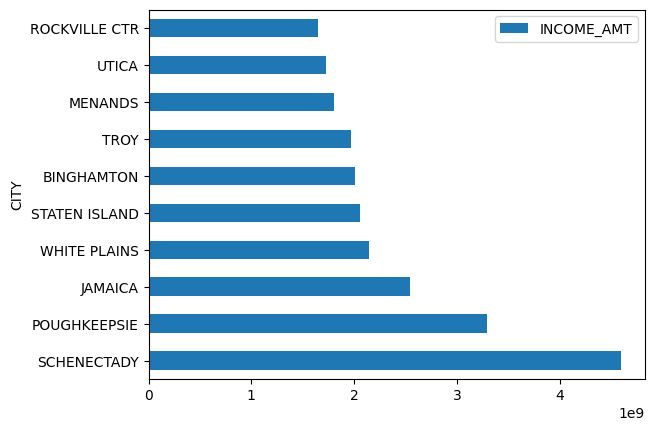

In [ ]:
# Quick draft pandas plot of city incomee

# list of cities by sum of income
# series of income amt with index city

city_inc_ser = df.groupby(['CITY'])['INCOME_AMT'].sum().sort_values(ascending=False)

#df.groupby(['CITY'])['INCOME_AMT'].sum().sort_values(ascending=False).plot.barh(legend=True)

rank_start = 10
rank_end = 20

city_inc_ser.iloc[rank_start:rank_end].plot.barh(legend=True)


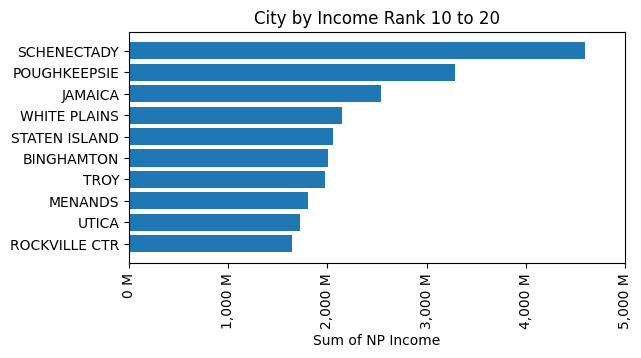

In [ ]:
#  Bar Horizontal of Cities and Sum of Incomes, Ranked

#TODO: Add Rank and enable search for city, return 10 before, after
#TODO: replace wah with city_inc?
from matplotlib.pyplot import figure

label_format =  '{:,.0f} M'

rank_start = 10
rank_end = 20

fig, ax = plt.subplots()
#plt.figure().set_figheight(25)

# sort out fig height depending on how rows being returned
figh = int((rank_end - rank_start) / 3)
fig.set_figheight(figh)

y_pos = np.arange(len(city_inc_df.iloc[rank_start:rank_end].index))
city_inc = city_inc_df.iloc[rank_start:rank_end].values / 1000000

ax.barh(y_pos, city_inc, align='center')
ax.set_yticks(y_pos, labels=city_inc_df.iloc[rank_start:rank_end].index)
ax.invert_yaxis()  # labels read top-to-bottom

ax.set_xticks(ax.get_xticks())
ticks_loc = ax.get_xticks().tolist()
ax.set_xticklabels([label_format.format(x) for x in ticks_loc], rotation=90)


ax.set_xlabel('Sum of NP Income')
ax.set_title(f'City by Income Rank {rank_start} to {rank_end}')

plt.show()

In [ ]:
# option to load ntee codes into dataframe and do merges

df_ntee = pd.read_csv('/content/drive/My Drive/irs_data/IRS_Code_Lookups/NCCS_NTEE.csv')


# could then convert to dict...
# ntee_dict = pd.to_dict(file)

# for merge, rename NTEE_CD so it matches master file

#df_ntee.rename(columns={'NTEE Code':'NTEE_CD'}, inplace=True)

# display(df_ntee)

filt = df_ntee["NTEE Code"].str.len() ==  1

df_ntee[filt]



In [ ]:
# plot bins -- various code tests


# from stack exchange
# out = pd.cut(s, bins=[0, 0.35, 0.7, 1], include_lowest=True)
# ax = out.value_counts(sort=False).plot.bar(rot=0, color="b", figsize=(6,4))
# ax.set_xticklabels([c[1:-1].replace(","," to") for c in out.cat.categories])
# plt.show()


# seems to work
#out = cortland_df['NAME'].groupby(pd.cut(cortland_df['INCOME_AMT'], bins))

# out.value_counts(sort=False).plot.bar(rot=0, color="b", figsize=(6,4))

# out.value_counts(sort=False)

# gives count by bins
#out.count()


# out = pd.cut(s, bins=bins, include_lowest=True)
# replace s
out = pd.cut(cortland_df['INCOME_AMT'], bins=bins, include_lowest=True)
#out.count()
#out.value_counts(sort=False)

# works -- but why is there a bracket in there?
out.value_counts().reindex(out.cat.categories)
#print ("out categories")
#print (out.cat.categories)


import re
xlabs = []
# create list for labels?
for c in out.cat.categories:
  h = str(c)
  i = re.sub(r"\(|\]|\.0", '', h).replace(","," to")
  xlabs.append(i)

# print (xlabs)

#print (xlabs)

#c[1:-1].replace(","," to") for c in out.cat.categories


# -- stack exchange
#ax = out.value_counts(sort=False).plot.bar(rot=0, color="b", figsize=(6,4))
#ax.set_xticklabels([c[1:-1].replace(","," to") for c in out.cat.categories])
# plt.show()


#ax = out.value_counts(sort=False).plot.bar(rot=0, color="b", figsize=(6,4))
#ax = out.value_counts(sort=False).plot.bar(rot=0, color="b")
# ax.set_xticklabels([c[1:-1].replace(","," to") for c in out.cat.categories])

# this works
#ax = out.value_counts(sort=False).plot.bar(rot=0, color="b", figsize=(6,4))
#ax.set_xticklabels(ax.get_xticklabels(),rotation=90) # works

ax = out.value_counts(sort=False).plot.bar(rot=0, color="b")
ax.set_xticklabels(xlabs,rotation=90)
plt.show()


# ax.set_xticklabels(xlabs)
#ax.set_xticklabels(rotation=90)


#ax.get_xticklabels()

# works
#for c in out.cat.categories:
#  print (c)


#[c[1:-1].replace(","," to") for c in out.cat.categories]


#plt.show()


#ax = out.count().plot.bar(rot=0, color="b", figsize=(6,4))
#ax.set_xticklabels([c[1:-1].replace(","," to") for c in bins])
#plt.show()




NameError: name 'bins' is not defined

In [ ]:
# --- fiddle ---
#ntee_cat = [  str(i)[0] if i else 'nan' for i in cortland_df['NTEE_CD']]
#tmp = cortland_df.groupby(ntee_cat)['INCOME_AMT'].sum()

#tmp.plot(legend=True)
#tmp.plot.bar(legend=True)
